# place_and_time.ipynb

In [1]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
sys.path.append('/home1/dscho/code/projects/manning_replication')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, place_analysis, goldmine_behavior

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = {1: 2.05, 2: 3.125, 3: 6.45}

In [2]:
def draw_maze_precise(_self,
                      maze_vals,
                      scaling_factor=1,
                      do_convolve=True,
                      all_pos=None,
                      show_nav=False,
                      draw_base=True,
                      cbar_label='',
                      ax=None,
                      **kws):
    """Convert maze_vals to a 2D map of the maze environment."""
    _origin = _self.maze.origin * scaling_factor
    
    # Map values to the 2D maze.
    maze_map = np.zeros(_self.maze.shape * scaling_factor)
    for point, val in maze_vals.items():
        point -= _origin
        maze_map[tuple(point)] = val
    
    # Mask out walls.
    mask = np.zeros(_self.maze.shape * scaling_factor)
    for idx, row in _self.maze.maze.query("(region=='wall')").iterrows():
        maze_tile = (np.array(row['coords']) * scaling_factor) - _origin
        mask[np.meshgrid(range(maze_tile[0][0], maze_tile[1][0]),
                         range(maze_tile[0][1], maze_tile[1][1]))] = 1
    
    # Convolve maze values with a 2D Gaussian, handling NaNs.
    if do_convolve:
        sigma = 2 * scaling_factor # m the subject can move in 0.5s
        kernel = Gaussian2DKernel(sigma, sigma)
        maze_map[maze_map==0] = np.nan
        maze_map = convolve(maze_map, kernel, mask=mask)
    
    # Make the heatmap.
    if ax is None:
        ax = plt.gca()
    kws['vmin'] = kws.get('vmin', 0)
    kws['vmax'] = kws.get('vmax', np.max(maze_map[np.isfinite(maze_map)]))
    kws['cmap'] = kws.get('cmap', _self.plot_params['cmap'])
    alpha_nav = kws.pop('alpha_nav', 0.3)
    labelpad = kws.pop('labelpad', _self.plot_params['labelpad'])
    ax = sns.heatmap(maze_map.T, mask=mask.T, ax=ax, **kws)
    if show_nav:
        for iTrial, trial in enumerate(all_pos.keys()):
            ax.plot(all_pos[trial][:, 0] - _origin[0], 
                    all_pos[trial][:, 1] - _origin[1], 
                    color='#b2babf', alpha=alpha_nav, linewidth=0.3)
    if draw_base:
        base_coords = np.array(_self.maze.maze.query("(region=='base')")['coords'].tolist())
        base_points = np.concatenate((base_coords[:, 0, :], base_coords[:, 1, :]))
        base_min = (np.min(base_points, axis=0) - _self.maze.origin) * scaling_factor
        base_max = (np.max(base_points, axis=0) - _self.maze.origin) * scaling_factor
        base_width, base_height = base_max - base_min
        rect = patches.Rectangle(base_min, base_width, base_height, 
                                 fill=False, lw=1, ec='#b2babf')
        ax.add_patch(rect)
    ax.set_facecolor('#40291c')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=_self.plot_params['font']['tick'])
    cbar_ticks = np.linspace(kws['vmin'], kws['vmax'], 5)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['{:g}'.format(x) for x in np.round(cbar_ticks, 1)])
    cbar.set_label(cbar_label, fontsize=_self.plot_params['font']['label'], labelpad=labelpad)

    return ax, maze_map, mask

In [3]:
def trial_raster2(neuron, 
                  ax=None,
                  events=None,
                  plot_labels=True,
                  plot_title=True,
                  font=None,
                  proj_dir='/home1/dscho/projects/time_cells',
                  **kws):
    """Plot spike rasters for each trial, and return ax."""
    subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
    trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
    dsr = 1000  # downsampling rate in Hz
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    if events is None:
        events = goldmine_behavior.Events(subj_sess)
    if font is None:
        font = od([('tick', 12),
                   ('label', 16),
                   ('annot', 14),
                   ('fig', 16)])
    ax_labels = {'Delay1': 'Delay 1',
                 'Delay2': 'Delay 2',
                 'Encoding': 'Encoding',
                 'Retrieval': 'Retrieval'}
    
    # Load the neuron's original spike data.
    spikes_f = os.path.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
    spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))

    dsr_ratio = np.int(1000 / dsr)  # spike and event times start out in ms
    trial_phase_durs = od([('Delay1', np.int(1e4 / dsr_ratio)),
                           ('Encoding', np.int(3e4 / dsr_ratio)),
                           ('Delay2', np.int(1e4 / dsr_ratio)),
                           ('Retrieval', np.int(3e4 / dsr_ratio))])
    
    # Skip over partial trials.
    trial_counts = events.event_times.query("(gameState=={})".format(trial_phases)).groupby('trial').size()
    include_trials = trial_counts[trial_counts==len(trial_phases)].index.tolist()
        
    # For each trial, convert spike times to a downsampled spike train.
    for trial in include_trials:
        spike_train = []
        for trial_phase in trial_phases:
            row = events.event_times.query("(trial=={}) & (gameState=='{}')".format(trial, trial_phase)).sort_values('trial', ascending=True)
            assert len(row) == 1
            row = row.iloc[0]
            
            # Find spike times within each event window.
            event_start, event_stop = row['time']
            spike_times = spikes['spike_times'][(spikes['spike_times']>=event_start) & (spikes['spike_times']<event_stop)] - event_start
            duration = event_stop - event_start
            spike_times = spike_times[(spike_times<trial_phase_durs[trial_phase])]
#             print(trial, trial_phase, event_start, event_stop, duration, spike_times[0], spike_times[-1], trial_phase_durs[trial_phase])
            
            # Downsample times.
            if dsr_ratio != 1:
                spike_times = np.array(np.unique(np.rint(spike_times / dsr_ratio).astype(np.int)))
                duration = np.rint(duration / dsr_ratio).astype(np.int)
                        
            # Convert spike times to spike train.
            spike_train_ = np.zeros(trial_phase_durs[trial_phase])
            spike_train_[spike_times] = trial
            spike_train_[spike_train_==0] = np.nan
            spike_train.append(spike_train_)
#             print('Trial {} {}: {} spikes'.format(row['trial'], row['gameState'], len(spike_times)))
                
        spike_train = np.concatenate(spike_train)
        ax.plot(spike_train, linewidth=0, marker='|', 
                markerfacecolor='k', markeredgecolor='k',
                markersize=3, markeredgewidth=0.2)

    # Concentate spikes across trial phases.
    v_lines = np.cumsum([0] + list(trial_phase_durs.values()))
    for x in v_lines[1:]:
        ax.axvline(x=x, color='k', alpha=1, linewidth=0.8) # '#b2babf' alpha=0.66 colors[1]

    xticks = np.arange(0, v_lines[-1] + 1, 10 * dsr)
    ax.set_xlim([-1*dsr, v_lines[-1] + (1*dsr)])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0, (v_lines[-1]/dsr)+1, 10, dtype=np.int), 
                          fontsize=font['tick'], rotation=0)
    ax.invert_yaxis()
    if 'ymin' in kws and 'ymax' in kws:
        ax.set_ylim([ymin, ymax])
    yticks = np.arange(6, np.max(include_trials)+1, 6, dtype=np.int)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=font['tick'], rotation=0)
    if plot_labels:
        ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=8)
        ax.set_ylabel('Trial', fontsize=font['label'], labelpad=8)
        annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
        for ii in range(len(annot_x)):
            ax.text(annot_x[ii]/v_lines[-1], 1.1, ax_labels[trial_phases[ii]], ha='center', 
                    va='center', fontsize=font['annot'], transform=ax.transAxes)
    if plot_title:
        ax_title = '{}, {}, ch{}, unit{}'.format(spikes['subj_sess'], spikes['hemroi'], spikes['chan'], spikes['unit'])
        ax.set_title(ax_title, loc='left', pad=30, fontsize=font['fig'])
    
    return ax

In [4]:
def trial_raster3(neuron,
                  trial_phases=['Delay1', 'Encoding', 'Delay2', 'Retrieval'],
                  ax=None,
                  events=None,
                  xtick_inc=10,
                  rastersize=1,
                  rasterwidth=0.1,
                  ax_linewidth=0.5,
                  plot_vlines=True,
                  plot_labels=True,
                  plot_trial_phases=True,
                  plot_title=True,
                  font=None,
                  proj_dir='/home1/dscho/projects/time_cells',
                  **kws):
    """Plot spike rasters for each trial, and return ax."""
    subj_sess, chan, unit = neuron.replace('ch', '').replace('CSC', '').replace('unit', '').split('-')
    dsr = 1000  # downsampling rate in Hz
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    if events is None:
        events = goldmine_behavior.Events(subj_sess)
    if font is None:
        font = od([('tick', 12),
                   ('label', 16),
                   ('annot', 14),
                   ('fig', 16)])
    if 'labelpad' not in font:
        font['labelpad'] = 1
        
    ax_labels = {'Delay1': 'Delay 1',
                 'Delay2': 'Delay 2',
                 'Encoding': 'Encoding',
                 'Retrieval': 'Retrieval'}
    
    # Load the neuron's original spike data.
    spikes_f = os.path.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl')
    spikes = dio.open_pickle(spikes_f.format(subj_sess, chan, unit))

    dsr_ratio = np.int(1000 / dsr)  # spike and event times start out in ms
    trial_phase_durs_ = od([('Delay1', np.int(1e4 / dsr_ratio)),
                            ('Encoding', np.int(3e4 / dsr_ratio)),
                            ('Delay2', np.int(1e4 / dsr_ratio)),
                            ('Retrieval', np.int(3e4 / dsr_ratio))])
    trial_phase_durs = od([])
    for k in trial_phases:
        trial_phase_durs[k] = trial_phase_durs_[k]
    
    # Skip over partial trials.
    trial_counts = events.event_times.query("(gameState=={})".format(['Delay1', 'Encoding', 'Delay2', 'Retrieval'])).groupby('trial').size()
    include_trials = trial_counts[trial_counts==4].index.tolist()
        
    # For each trial, convert spike times to a downsampled spike train.
    for iTrial, trial in enumerate(include_trials):
        spike_train = []
        for trial_phase in trial_phases:
            row = events.event_times.query("(trial=={}) & (gameState=='{}')".format(trial, trial_phase)).sort_values('trial', ascending=True)
            assert len(row) == 1
            row = row.iloc[0]
            
            # Find spike times within each event window.
            event_start, event_stop = row['time']
            spike_times = spikes['spike_times'][(spikes['spike_times']>=event_start) & (spikes['spike_times']<event_stop)] - event_start
            duration = event_stop - event_start
            #print(trial, event_start, event_stop, duration, len(spike_times), spike_times[0], spike_times[-1], trial_phase_durs[trial_phase])
            spike_times = spike_times[(spike_times<trial_phase_durs[trial_phase])]
            
            # Downsample times.
            if dsr_ratio != 1:
                spike_times = np.array(np.unique(np.rint(spike_times / dsr_ratio).astype(np.int)))
                duration = np.rint(duration / dsr_ratio).astype(np.int)
                        
            # Convert spike times to spike train.
            spike_train_ = np.zeros(trial_phase_durs[trial_phase])
            spike_train_[spike_times] = iTrial + 1
            spike_train_[spike_train_==0] = np.nan
            spike_train.append(spike_train_)
                
        spike_train = np.concatenate(spike_train)
        ax.plot(spike_train, linewidth=0, marker='|', 
                markerfacecolor='k', markeredgecolor='k',
                markersize=rastersize, markeredgewidth=rasterwidth)

    # Concentate spikes across trial phases.
    v_lines = np.cumsum([0] + list(trial_phase_durs.values()))
    if plot_vlines:
        for x in v_lines[1:]:
            ax.axvline(x=x, color='k', alpha=1, linewidth=ax_linewidth)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(ax_linewidth)
    ax.tick_params(axis='both', which='both', length=2, width=ax_linewidth, pad=1)
    xticks = np.arange(0, v_lines[-1] + 1, xtick_inc * dsr)
    ax.set_xlim([-1*dsr, v_lines[-1] + (1*dsr)])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0, (v_lines[-1]/dsr)+1, xtick_inc, dtype=np.int), 
                       fontsize=font['tick'], rotation=0)
    if 'ymin' in kws and 'ymax' in kws:
        ax.set_ylim([ymin, ymax+1])
    ax.invert_yaxis()
    yticks = np.arange(6, len(include_trials)+1, 6, dtype=np.int)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=font['tick'], rotation=0)
    if plot_labels:
        ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=font['labelpad'])
        ax.set_ylabel('Trial', fontsize=font['label'], labelpad=font['labelpad'])
        if plot_trial_phases:
            annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
            for ii in range(len(annot_x)):
                ax.text(annot_x[ii]/v_lines[-1], 1.1, ax_labels[trial_phases[ii]], ha='center', 
                        va='center', fontsize=font['annot'], transform=ax.transAxes)
    if plot_title:
        mean_fr_ = mean_fr.query("(neuron=='{}') & (game_state=='{}')".format(neuron, game_state)).iloc[0]
        info_z = mean_fr_['obs_info_z']
        fr_z_max = mean_fr_['obs_fr_z_max']
        ax_title = ('{}-{}-{}, {}, $TI_z$={:.1f}, $FR_z$={:.1f}'
                    .format(spikes['subj_sess'], spikes['chan'], spikes['unit'], spikes['hemroi'], info_z, fr_z_max))
        if len(trial_phases) == 1:
            ax_title += ', {}'.format(trial_phases[0])
        ax.set_title(ax_title, loc='left', pad=6, fontsize=font['fig'])
    
    return ax

In [5]:
def calc_time_field(v,
                    z_thresh=2):
    """Return the time field given a Z-scored firing rate vector.
    
    The time field is given by contiguous time bins surrounding
    the maximum Z-scored firing rate that are greater than
    z_thresh. If the maximum firing rate is less than z_thresh,
    a v-length vector of zeros is returned.
    """
    time_field = np.zeros(len(v))
    peak = v.argmax()
    
    # Check that the firing rate peak > z_thresh.
    if v[peak]<=z_thresh:
        return time_field
    else:
        time_field[peak] = 1
    
    # Move backwards from the peak firing rate.
    for iBin in range(peak, -1, -1):
        if v[iBin]>z_thresh:
            time_field[iBin] = 1
        else:
            break
    
    # Move forwards from the peak firing rate.
    for iBin in range(peak, len(time_field)):
        if v[iBin]>z_thresh:
            time_field[iBin] = 1
        else:
            break
    
    return time_field

In [7]:
proj_dir = '/home1/dscho/projects/time_cells'
roi_mapping = {'A': 'Amygdala',
               'AC': 'Frontal',
               'AH': 'Hippocampus',
               'AI': 'Frontal',
               'EC': 'EC',
               'FOp': 'Frontal',
               'FOP': 'Frontal',
               'HGa': 'Cortical',
               'MFG': 'Frontal',
               'MH': 'Hippocampus',
               'O': 'Cortical',
               'OF': 'Frontal',
               'PHG': 'Cortical',
               'PI-SMG': 'Frontal',
               'TO': 'Cortical',
               'TPO': 'Cortical'}

In [6]:
# start_time = time()

# sessions = [os.path.basename(f).split('-')[0] 
#             for f in glob(os.path.join(proj_dir, 'analysis', 'events', '*.pkl'))]

# for subj_sess in sessions:
#     events = goldmine_behavior.Events(subj_sess)
#     _d = events.save_time_indices(overwrite=False)
    
# print('Done in {:.2f}s'.format(time() - start_time))

In [8]:
z_thresh = 2

files = np.sort(glob(op.join(proj_dir, 'analysis', 'fr_by_time_and_pos', '*info_rates.pkl')))
print('Found {} files'.format(len(files)))

mean_fr = pd.concat([dio.open_pickle(f) for f in files]).reset_index(drop=True)

if 'neuron' not in mean_fr.columns:
    mean_fr.insert(0, 'neuron', mean_fr.apply(lambda x: '{}-{}-{}'.format(x['subj_sess'], x['chan'], x['unit']), axis=1))
if 'roi' not in mean_fr:
    mean_fr.insert(8, 'roi', mean_fr['hemroi'].apply(lambda x: roi_mapping[x[1:]]))
else:
    mean_fr['roi'] = mean_fr['hemroi'].apply(lambda x: roi_mapping[x[1:]])
if 'obs_fr_max_ind' not in mean_fr:
    mean_fr.insert(13, 'obs_fr_max_ind', mean_fr['obs_fr'].apply(lambda x: np.argmax(x)))
if 'obs_fr_z_max_ind' not in mean_fr:
    mean_fr.insert(15, 'obs_fr_z_max_ind', mean_fr['obs_fr_z'].apply(lambda x: np.argmax(x)))               
if 'obs_fr_z_abs_max_ind' not in mean_fr:
    mean_fr.insert(17, 'obs_fr_z_abs_max_ind', mean_fr['obs_fr_z'].apply(lambda x: np.argmax(np.abs(x))))
if 'obs_fr_z_abs_max' not in mean_fr:
    mean_fr.insert(18, 'obs_fr_z_abs_max', mean_fr['obs_fr_z'].apply(lambda x: x[np.argmax(np.abs(x))]))
if 'obs_fr_z_abs_max_sign' not in mean_fr:
    mean_fr.insert(19, 'obs_fr_z_abs_max_sign', mean_fr['obs_fr_z_abs_max'].apply(lambda x: 1 if x>0 else -1))
if 'obs_fr_z_abs_max_above_thresh' not in mean_fr:
    mean_fr.insert(20, 'obs_fr_z_abs_max_above_thresh', mean_fr['obs_fr_z_abs_max'].apply(lambda x: np.abs(x)>z_thresh))
if 'time_field' not in mean_fr:
    mean_fr.insert(21, 'time_field', mean_fr['obs_fr_z'].apply(lambda x: calc_time_field(x, z_thresh)))
if 'time_field_size' not in mean_fr:
    mean_fr.insert(22, 'time_field_size', mean_fr['time_field'].apply(np.sum))
    
all_neurons = np.sort(list(mean_fr['neuron'].unique()))

# FDR correct p-values across all neurons.
alpha = 0.05
mean_fr['sig'] = np.nan
mean_fr['sig_fdr'] = np.nan
for idx, grp in mean_fr.groupby(['game_state', 'fr_cat']):
    pvals = grp['pval']
    mean_fr.loc[grp.index, 'sig'] = pvals < alpha
    sig_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[0]
    mean_fr.loc[grp.index, 'sig_fdr'] = sig_fdr
mean_fr['crit_sig'] = mean_fr.apply(lambda x: np.all((x['sig']==True, 
                                                      x['obs_fr_z_abs_max_sign']==1, 
                                                      x['obs_fr_z_abs_max_above_thresh']==True)), 
                                    axis=1)

print('{} neurons'.format(len(all_neurons)))
print('mean_fr:', mean_fr.shape)

Found 270 files
270 neurons
mean_fr: (2700, 30)


In [9]:
# Load mean FR files for the delay intervals.
files = glob(os.path.join(proj_dir, 'analysis', 'fr_by_time_bin', '*mean_fr_by_time.pkl'))
print('{} files'.format(len(files)))
    
mean_fr_by_time = pd.concat([dio.open_pickle(f) for f in files]).reset_index(drop=True)

# # Keep only the Delay1 and Delay2 rows.
# mean_fr_by_time = mean_fr_by_time.query("(gameState==['Delay1', 'Delay2'])").reset_index(drop=True)

# Convert channel and unit values from string to numeric.
mean_fr_by_time['chan'] = mean_fr_by_time['chan'].apply(lambda x: x[1:] if (x[0]=='C') else x)
mean_fr_by_time['unit'] = mean_fr_by_time['unit'].apply(lambda x: x[4:] if (x[0] == 'u') else x)

# Add the neuron unique ID column.
if 'neuron' not in mean_fr_by_time:
    mean_fr_by_time.insert(0, 'neuron', mean_fr_by_time.apply(lambda x: '{}-{}-{}'.format(x['subj_sess'], x['chan'], x['unit']), axis=1))

# Format data types.
mean_fr_by_time['neuron'] = mean_fr_by_time['neuron'].astype(str)
mean_fr_by_time['subj_sess'] = mean_fr_by_time['subj_sess'].astype(str)
mean_fr_by_time['chan'] = mean_fr_by_time['chan'].astype(np.int)
mean_fr_by_time['unit'] = mean_fr_by_time['unit'].astype(np.int)

# Add ROI labels.
if 'hemroi' not in mean_fr_by_time:
    mean_fr_by_time.insert(4, 'hemroi', mean_fr_by_time.apply(lambda x: spike_preproc.roi_lookup(x['subj_sess'], x['chan']), axis=1))
if 'roi' not in mean_fr_by_time:
    mean_fr_by_time.insert(5, 'roi', mean_fr_by_time['hemroi'].apply(lambda x: roi_mapping[x[1:]]))
else:
    mean_fr_by_time['roi'] = mean_fr_by_time['hemroi'].apply(lambda x: roi_mapping[x[1:]])
    
# Change some column names.
remap_cols = {'gameState': 'game_state',
              'fr': 'obs_fr',
              'z_fr': 'obs_fr_z',
              'z_fr_max': 'obs_fr_z_max',
              'z_fr_max_ind': 'obs_fr_z_max_ind',
              'tis': 'obs_info',
              'z_tis': 'obs_info_z'}
mean_fr_by_time.rename(columns=remap_cols, inplace=True)

# Add the cell's firing rate across the session.
def f(x):
    output = mean_fr.query("(neuron=='{}')".format(x))
    if len(output) > 0:
        return output.iloc[0]['fr']
    else:
        return np.nan
if 'fr' not in mean_fr_by_time:
    mean_fr_by_time.insert(8, 'fr', mean_fr_by_time['neuron'].apply(lambda x: f(x)))

# Add other columns that we need.
if 'fr_cat' not in mean_fr_by_time:
    mean_fr_by_time.insert(9, 'fr_cat', 'fr_by_time')
if 'obs_fr_max' not in mean_fr_by_time:
    mean_fr_by_time.insert(13, 'obs_fr_max', mean_fr_by_time['obs_fr'].apply(np.max))
if 'obs_fr_max_ind' not in mean_fr_by_time:
    mean_fr_by_time.insert(14, 'obs_fr_max_ind', mean_fr_by_time['obs_fr'].apply(np.argmax))
def pval_to_pval_ind(p, n_perm=1000):
    return np.rint((p * (n_perm + 1)) - 1).astype(np.int)
if 'pval_ind' not in mean_fr_by_time:
    mean_fr_by_time.insert(19, 'pval_ind', mean_fr_by_time['pval'].apply(lambda x: pval_to_pval_ind(x)))
if 'obs_fr_z_max_ind' not in mean_fr_by_time:
    mean_fr_by_time.insert(15, 'obs_fr_z_max_ind', mean_fr_by_time['obs_fr_z'].apply(lambda x: np.argmax(x)))               
if 'obs_fr_z_abs_max_ind' not in mean_fr_by_time:
    mean_fr_by_time.insert(17, 'obs_fr_z_abs_max_ind', mean_fr_by_time['obs_fr_z'].apply(lambda x: np.argmax(np.abs(x))))
if 'obs_fr_z_abs_max' not in mean_fr_by_time:
    mean_fr_by_time.insert(18, 'obs_fr_z_abs_max', mean_fr_by_time['obs_fr_z'].apply(lambda x: x[np.argmax(np.abs(x))]))
if 'obs_fr_z_abs_max_sign' not in mean_fr_by_time:
    mean_fr_by_time.insert(19, 'obs_fr_z_abs_max_sign', mean_fr_by_time['obs_fr_z_abs_max'].apply(lambda x: 1 if x>0 else -1))
if 'obs_fr_z_abs_max_above_thresh' not in mean_fr_by_time:
    mean_fr_by_time.insert(20, 'obs_fr_z_abs_max_above_thresh', mean_fr_by_time['obs_fr_z_abs_max'].apply(lambda x: np.abs(x)>z_thresh))
if 'time_field' not in mean_fr_by_time:
    mean_fr_by_time.insert(21, 'time_field', mean_fr_by_time['obs_fr_z'].apply(lambda x: calc_time_field(x, z_thresh)))
if 'time_field_size' not in mean_fr_by_time:
    mean_fr_by_time.insert(22, 'time_field_size', mean_fr_by_time['time_field'].apply(np.sum))

# FDR correct across all neurons.
alpha = 0.05
mean_fr_by_time['sig'] = mean_fr_by_time['pval'] < alpha
mean_fr_by_time['sig_fdr'] = ''
for game_state in mean_fr_by_time['game_state'].unique():
    pvals = mean_fr_by_time.loc[mean_fr_by_time['game_state']==game_state, 'pval']
    sig_fdr = sm.stats.multipletests(pvals, alpha, method='fdr_tsbky')[0]
    mean_fr_by_time.loc[mean_fr_by_time['game_state']==game_state, 'sig_fdr'] = sig_fdr
mean_fr_by_time['crit_sig'] = mean_fr_by_time.apply(lambda x: np.all((x['sig']==True, 
                                                                      x['obs_fr_z_abs_max_sign']==1, 
                                                                      x['obs_fr_z_abs_max_above_thresh']==True)), 
                                                    axis=1)

print('{} neurons'.format(len(mean_fr_by_time['neuron'].unique())))
print('mean_fr_by_time:', mean_fr_by_time.shape)

168 files
168 neurons
mean_fr_by_time: (1272, 30)


In [9]:
# # Append delay period rows to mean_fr.
# mean_fr = pd.concat((mean_fr, mean_fr_by_time[mean_fr.columns])).sort_values(['neuron', 'game_state', 'fr_cat']).reset_index(drop=True)

# print('{} neurons'.format(len(all_neurons)))
# print('mean_fr:', mean_fr.shape)

In [15]:
sig_col = 'crit_sig'
game_state = 'Delay2'

l1 = np.unique(mean_fr_by_time.query("(game_state=='{}') & ({}==True)".format(game_state, sig_col))['neuron'])
l2 = np.unique(mean_fr.query("(game_state=='{}') & ({}==True) & (fr_cat=='fr_by_time') & (subj!='U530')".format(game_state, sig_col))['neuron'])

remove_units = [x for x in l2 if x not in l1]
print('{} in mean_fr, not mean_fr_by_time:'.format(sig_col))
print(len(remove_units))
print(remove_units, end='\n\n')

add_units = [x for x in l1 if x not in l2]
print('{} in mean_fr_by_time, not mean_fr:'.format(sig_col))
print(len(add_units))
print(add_units)

crit_sig in mean_fr, not mean_fr_by_time:
1
['U518_ses1-67-2']

crit_sig in mean_fr_by_time, not mean_fr:
7
['U518_ses1-12-1', 'U518_ses1-13-2', 'U518_ses1-38-1', 'U518_ses1-49-1', 'U518_ses1-70-1', 'U518_ses1-73-2', 'U518_ses1-79-1']


In [11]:
# Delay 2 inconsistencies
# -----------------------
# mean_fr_by_time not mean_fr: 'U518_ses1-12-1', 'U518_ses1-13-2', 'U518_ses1-38-1', 'U518_ses1-49-1', 'U518_ses1-70-1', 'U518_ses1-73-2', 'U518_ses1-79-1'
# mean_fr not mean_fr_by_time: 'U518_ses1-67-2'

In [10]:
# Make a list of significant neurons for each trial phase category.
sig_col = 'crit_sig'

sig_cells = od([])
for game_state in mean_fr['game_state'].unique():
    if game_state in ['Delay1', 'Delay2']:
        sig_cells[(game_state, 'fr_by_time')] = np.array(mean_fr.query("({}==True) & (game_state=='{}')".format(sig_col, game_state))
                                                                .sort_values(['obs_fr_max_ind', 'obs_info_z'], ascending=(True, False))['neuron'].tolist())
    else:
        for fr_cat in mean_fr['fr_cat'].unique():
            sig_cells[(game_state, fr_cat)] = np.array(mean_fr.query("(fr_cat=='{}') & ({}==True) & (game_state=='{}')".format(fr_cat, sig_col, game_state))
                                                              .sort_values(['obs_fr_max_ind', 'obs_info_z'], ascending=(True, False))['neuron'].tolist())
        
for game_state in ['Encoding', 'Retrieval']:
    sig_cells[(game_state, 'time')] = [x for x in sig_cells[(game_state, 'fr_by_time')]
                                       if x in sig_cells[(game_state, 'fr_by_time_subpos')]]
    sig_cells[(game_state, 'pos')] = [x for x in sig_cells[(game_state, 'fr_by_pos')] 
                                      if x in sig_cells[(game_state, 'fr_by_pos_subtime')]]
    
# --------------------
# FIX AND REMOVE LATER
remove_units = ['U518_ses1-67-2']
add_units = ['U518_ses1-12-1', 'U518_ses1-13-2', 'U518_ses1-38-1', 'U518_ses1-49-1', 
             'U518_ses1-70-1', 'U518_ses1-73-2', 'U518_ses1-79-1']
sig_cells[('Delay2', 'fr_by_time')] = np.array([x for x in sig_cells[('Delay2', 'fr_by_time')] if x not in remove_units] + 
                                               [x for x in add_units if x not in list(sig_cells[('Delay2', 'fr_by_time')])])
# --------------------

sig_cells[('delay', 'time')] = np.unique(np.concatenate((sig_cells[('Delay1', 'fr_by_time')], 
                                                         sig_cells[('Delay2', 'fr_by_time')])))
sig_cells[('nav', 'time')] = np.unique(np.concatenate((sig_cells[('Encoding', 'fr_by_time')], 
                                                       sig_cells[('Retrieval', 'fr_by_time')])))
sig_cells[('nav', 'pos')] = np.unique(np.concatenate((sig_cells[('Encoding', 'fr_by_pos')], 
                                                      sig_cells[('Retrieval', 'fr_by_pos')])))
sig_cells[('any', 'time')] = np.unique(np.concatenate((sig_cells[('Delay1', 'fr_by_time')], 
                                                       sig_cells[('Delay2', 'fr_by_time')],
                                                       sig_cells[('Encoding', 'fr_by_time')], 
                                                       sig_cells[('Retrieval', 'fr_by_time')])))

In [16]:
(mean_fr_by_time.query("(neuron=='U518_ses1-15-2') & (game_state==['Delay1', 'Delay2', 'Encoding', 'Retrieval'])")
 [['subj', 'sess', 'chan', 'unit', 'fr', 'hemroi', 'fr_cat', 'game_state', 
   'obs_fr_max_ind', 'obs_fr_max', 'obs_fr_z_max_ind', 'obs_fr_z_max', 'obs_fr_z_abs_max_sign', 
   'time_field_size', 'obs_info_z', 'pval_ind', 'pval', 'crit_sig']])

,subj,sess,chan,unit,fr,hemroi,fr_cat,game_state,obs_fr_max_ind,obs_fr_max,obs_fr_z_max_ind,obs_fr_z_max,obs_fr_z_abs_max_sign,time_field_size,obs_info_z,pval_ind,pval,crit_sig
210,U518,ses1,15,2,1.388314,RTO,fr_by_time,Delay1,0,2.407743,0,3.463454,1,2.0,3.344168,7,0.007992,True
211,U518,ses1,15,2,1.388314,RTO,fr_by_time,Encoding,2,1.826925,2,2.540093,1,2.0,0.872482,166,0.166833,False
212,U518,ses1,15,2,1.388314,RTO,fr_by_time,Delay2,0,2.158519,0,2.991359,1,2.0,1.106548,139,0.139860,False
213,U518,ses1,15,2,1.388314,RTO,fr_by_time,Retrieval,3,1.867292,3,2.989090,1,3.0,2.065233,36,0.036963,True


In [22]:
mean_fr.query("(neuron=='U518_ses1-38-1')")[['subj', 'sess', 'chan', 'unit', 'fr', 'hemroi', 'fr_cat', 'game_state', 
                                             'obs_fr_max_ind', 'obs_fr_max', 'obs_fr_z_max_ind', 'obs_fr_z_max', 'obs_fr_z_abs_max_sign', 
                                             'time_field_size', 'obs_info_z', 'pval_ind', 'pval', 'crit_sig']]

,subj,sess,chan,unit,fr,hemroi,fr_cat,game_state,obs_fr_max_ind,obs_fr_max,obs_fr_z_max_ind,obs_fr_z_max,obs_fr_z_abs_max_sign,time_field_size,obs_info_z,pval_ind,pval,crit_sig
510,U518,ses1,38,1,5.459134,LMH,fr_by_time,Delay1,19,5.946935,19,2.231118,1,1.0,2.164422,36,0.036963,True
511,U518,ses1,38,1,5.459134,LMH,fr_by_time,Delay2,3,5.481478,3,1.902449,1,0.0,-2.296302,998,0.998002,False
512,U518,ses1,38,1,5.459134,LMH,fr_by_time,Encoding,40,6.705883,40,2.167122,-1,1.0,5.130983,0,0.000999,False
513,U518,ses1,38,1,5.459134,LMH,fr_by_pos,Encoding,25,11.195356,192,3.515778,-1,1.0,4.649799,0,0.000999,False
514,U518,ses1,38,1,5.459134,LMH,fr_by_time_subpos,Encoding,40,6.793383,40,2.369497,1,1.0,-0.523326,662,0.662338,False
515,U518,ses1,38,1,5.459134,LMH,fr_by_pos_subtime,Encoding,64,11.089352,192,3.414704,-1,2.0,2.896255,5,0.005994,False
516,U518,ses1,38,1,5.459134,LMH,fr_by_time,Retrieval,51,7.240065,15,2.857805,-1,2.0,5.743160,0,0.000999,False
517,U518,ses1,38,1,5.459134,LMH,fr_by_pos,Retrieval,159,11.667678,85,3.226018,-1,1.0,4.529961,0,0.000999,False
518,U518,ses1,38,1,5.459134,LMH,fr_by_time_subpos,Retrieval,52,7.162494,10,2.876066,1,2.0,0.766457,204,0.204795,False
519,U518,ses1,38,1,5.459134,LMH,fr_by_pos_subtime,Retrieval,79,11.878871,85,3.047261,1,1.0,2.610587,8,0.008991,True


In [12]:
table1 = (mean_fr
          .groupby('roi')
          .agg({'subj': lambda x: len(np.unique(x)), 
                'subj_sess': lambda x: len(np.unique(x)),
                'neuron': lambda x: len(np.unique(x))}))
table1.rename(columns={'subj': 'Subjects', 
                       'subj_sess': 'Sessions', 
                       'neuron': 'Units'}, 
              inplace=True)
display(table1)
print('Subjects: {}'.format(len(mean_fr['subj'].unique())),
      'Sessions: {}'.format(len(mean_fr['subj_sess'].unique())),
      'Units: {}'.format(len(mean_fr['neuron'].unique())), sep='\n')

,Subjects,Sessions,Units
roi,,,
Amygdala,4,5,36
Cortical,3,5,88
EC,4,6,58
Frontal,5,6,32
Hippocampus,5,7,56


Subjects: 5
Sessions: 7
Units: 270


In [359]:
def sum_pct(x):
    return '{} ({:.1%})'.format(np.sum(x), np.mean(x))

mean_fr.groupby(['fr_cat', 'game_state']).agg({'unit': len, 
                                               'sig': lambda x: sum_pct(x), 
                                               'sig_fdr': lambda x: sum_pct(x),
                                               'crit_sig': lambda x: sum_pct(x)})

unit          sig      sig_fdr    crit_sig
fr_cat            game_state                                            
fr_by_pos         Encoding     270  129 (47.8%)  109 (40.4%)  91 (33.7%)
                  Retrieval    270  112 (41.5%)   86 (31.9%)  95 (35.2%)
fr_by_pos_subtime Encoding     270   71 (26.3%)   41 (15.2%)  68 (25.2%)
                  Retrieval    270   68 (25.2%)   46 (17.0%)  59 (21.9%)
fr_by_time        Delay1       270   49 (18.1%)    24 (8.9%)  39 (14.4%)
                  Delay2       270   43 (15.9%)     7 (2.6%)  31 (11.5%)
                  Encoding     270  117 (43.3%)  107 (39.6%)  73 (27.0%)
                  Retrieval    270  116 (43.0%)   92 (34.1%)  78 (28.9%)
fr_by_time_subpos Encoding     270   42 (15.6%)    12 (4.4%)  27 (10.0%)
                  Retrieval    270   50 (18.5%)    13 (4.8%)  34 (12.6%)

In [751]:
print('Delay: {}'.format(len(np.unique(list(sig_cells[('Delay1', 'fr_by_time')]) + list(sig_cells[('Delay2', 'fr_by_time')])))),
      'Nav: {}'.format(len(np.unique(list(sig_cells[('Encoding', 'time')]) + list(sig_cells[('Retrieval', 'time')])))), sep='\n')

Delay: 59
Nav: 44


In [16]:
print('Delay: {}'.format(len(np.unique(list(sig_cells[('Delay1', 'fr_by_time')]) + list(sig_cells[('Delay2', 'fr_by_time')])))),
      'Nav: {}'.format(len(np.unique(list(sig_cells[('Encoding', 'time')]) + list(sig_cells[('Retrieval', 'time')])))), sep='\n')

Delay: 79
Nav: 68


In [58]:
for k in sig_cells.keys():
    print('{:<9} | {:<17} | {}'.format(k[0], k[1], '{} ({:.1%})'.format(len(sig_cells[k]), len(sig_cells[k])/len(all_neurons))))

Delay1    | fr_by_time        | 39 (14.4%)
Delay2    | fr_by_time        | 37 (13.7%)
Encoding  | fr_by_time        | 73 (27.0%)
Encoding  | fr_by_pos         | 91 (33.7%)
Encoding  | fr_by_time_subpos | 27 (10.0%)
Encoding  | fr_by_pos_subtime | 68 (25.2%)
Retrieval | fr_by_time        | 78 (28.9%)
Retrieval | fr_by_pos         | 95 (35.2%)
Retrieval | fr_by_time_subpos | 34 (12.6%)
Retrieval | fr_by_pos_subtime | 59 (21.9%)
Encoding  | time              | 19 (7.0%)
Encoding  | pos               | 46 (17.0%)
Retrieval | time              | 29 (10.7%)
Retrieval | pos               | 49 (18.1%)
delay     | time              | 63 (23.3%)
nav       | time              | 116 (43.0%)
nav       | pos               | 133 (49.3%)
any       | time              | 146 (54.1%)


In [6]:
# Load output files from place_analysis.calc_fr_by_time_and_pos()
proj_dir = '/home1/dscho/projects/time_cells'

files = glob(op.join(proj_dir, 'analysis', 'fr_by_time_and_pos', '*.pkl'))
print('Found {} files'.format(len(files)))

Found 336 files


In [15]:
sig_cells[('delay', 'time')]

array(['U518_ses0-11-1', 'U518_ses0-13-2', 'U518_ses0-15-1',
       'U518_ses0-16-1', 'U518_ses0-16-2', 'U518_ses0-30-1',
       'U518_ses0-32-1', 'U518_ses0-38-1', 'U518_ses0-38-3',
       'U518_ses0-4-1', 'U518_ses0-40-1', 'U518_ses0-65-1',
       'U518_ses0-67-1', 'U518_ses0-67-2', 'U518_ses0-68-1',
       'U518_ses0-72-1', 'U518_ses0-73-1', 'U518_ses0-79-1',
       'U518_ses0-9-1', 'U518_ses1-11-1', 'U518_ses1-12-1',
       'U518_ses1-13-2', 'U518_ses1-15-2', 'U518_ses1-37-1',
       'U518_ses1-38-1', 'U518_ses1-4-1', 'U518_ses1-40-1',
       'U518_ses1-49-1', 'U518_ses1-65-2', 'U518_ses1-67-1',
       'U518_ses1-67-2', 'U518_ses1-70-1', 'U518_ses1-73-2',
       'U518_ses1-79-1', 'U521_ses0-19-2', 'U521_ses0-21-1',
       'U521_ses0-23-1', 'U521_ses0-56-1', 'U526_ses0-12-1',
       'U526_ses0-15-1', 'U526_ses0-17-3', 'U526_ses0-21-1',
       'U526_ses0-41-2', 'U527_ses0-11-1', 'U527_ses0-16-1',
       'U527_ses0-17-1', 'U527_ses0-45-1', 'U527_ses0-45-2',
       'U527_ses0-48-1', 'U

In [ ]:
time_bins = 20
n_perm = 1000

spikes_by_time = []
for iUnit in range(len(sig_cells[('delay', 'time')])):
    subj_sess, chan, unit = sig_cells[('delay', 'time')][iUnit].split('-')
    neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))

    # Load events, firing rate vectors, and time bin indices.
    if ('events' not in locals()) and ('events' not in globals()):
        events = goldmine_behavior.Events(subj_sess)
    elif subj_sess != events.event_times.iloc[0]['subj_sess']:
        events = goldmine_behavior.Events(subj_sess)
    if subj_sess == 'U518_ses1':
        events.event_times = events.event_times.loc[events.event_times['trial']!=31].reset_index(drop=True)
    
    sum_spikes = []
    for game_state in ['Delay1', 'Delay2']:
        twise_spikes = (events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                          .apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0)).tolist())
        sum_spikes.append(np.sum([[np.nansum(x) for x in np.array_split(x, time_bins)]
                                  for x in twise_spikes], axis=0)) # time_bin; sum over trials
    spikes_by_time.append(np.concatenate(sum_spikes)) # time_bin; Delay 1 cat Delay 2 time bins
spikes_by_time = np.array(spikes_by_time)

In [63]:
events.events.query("(bad_trials!='')")['trial'].unique().tolist()

events.events.query("(bad_trials!='')").apply(lambda x: '{}-{}'.format(x['trial'], x['gameState']), axis=1).unique()

events.events.query("(bad_trials!='')")[['trial', 'gameState']].drop_duplicates().groupby('trial')['gameState'].apply(lambda x: list(np.unique(x))).reset_index().values.tolist()

#events.events.query("(bad_trials!='')")[['trial', 'gameState']].drop_duplicates().groupby('trial').agg({'gameState': lambda x: list(np.unique(x))})#.values.tolist()

[[4, ['Retrieval']], [24, ['Delay1']], [30, ['Delay1']]]

In [78]:
reload(goldmine_behavior)

<module 'time_cells.goldmine_behavior' from '/home1/dscho/code/projects/time_cells/goldmine_behavior.py'>

In [594]:
# subj_sess = 'U532_ses0'
# events = goldmine_behavior.Events(subj_sess)
# events.event_times['time'] = events.event_times['time_bins'].apply(lambda x: [x[0], x[-1]])
# events.event_times['duration'] = events.event_times['time'].apply(lambda x: x[-1] - x[0])

In [27]:
def unit_from_file(file):
    """Return unique unit name from the spike file name."""
    subj_sess, chan, unit, _ = op.basename(file).split('-')
    chan = chan.replace('CSC', '')
    unit = unit.replace('unit', '')
    return '{}-{}-{}'.format(subj_sess, chan, unit)

In [28]:
# Get neurons from the session.
globstr = op.join(events.proj_dir, 'analysis', 'spikes', '*-spikes.pkl')
spike_files = {unit_from_file(_f): _f 
               for _f in glob(globstr)}
neurons = list(spike_files.keys())
print('{} neurons'.format(len(neurons)))

335 neurons


In [1]:
time_bin_dur = 500
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

twise_spikes_by_time = od([('Delay1', od([])),
                           ('Encoding', od([])),
                           ('Delay2', od([])),
                           ('Retrieval', od([]))])
for game_state in game_states:
    for iUnit in range(len(neurons)):
        subj_sess, chan, unit = neurons[iUnit].split('-')
        neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))

        # Load events, firing rate vectors, and time bin indices.
        if ('events' not in locals()) and ('events' not in globals()):
            events = events_proc.load_events(subj_sess)
        elif subj_sess != events.event_times.iloc[0]['subj_sess']:
            events = events_proc.load_events(subj_sess)
        events.event_times['time'] = events.event_times.query("(gameState=={})".format(game_states))['time_bins'].apply(lambda x: [x[0], x[-1]])
        events.event_times['duration'] = events.event_times.query("(gameState=={})".format(game_states))['time'].apply(lambda x: x[-1] - x[0])
        
        twise_spikes = (events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                          .apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0)).tolist())
        twise_spikes_by_time[game_state]['{}-{}-{}'.format(subj_sess, chan, unit)] = np.array([[np.nansum(x) for x in np.split(x, int(len(x)/time_bin_dur))]
                                                                                               for x in twise_spikes]) # trial x time_bin

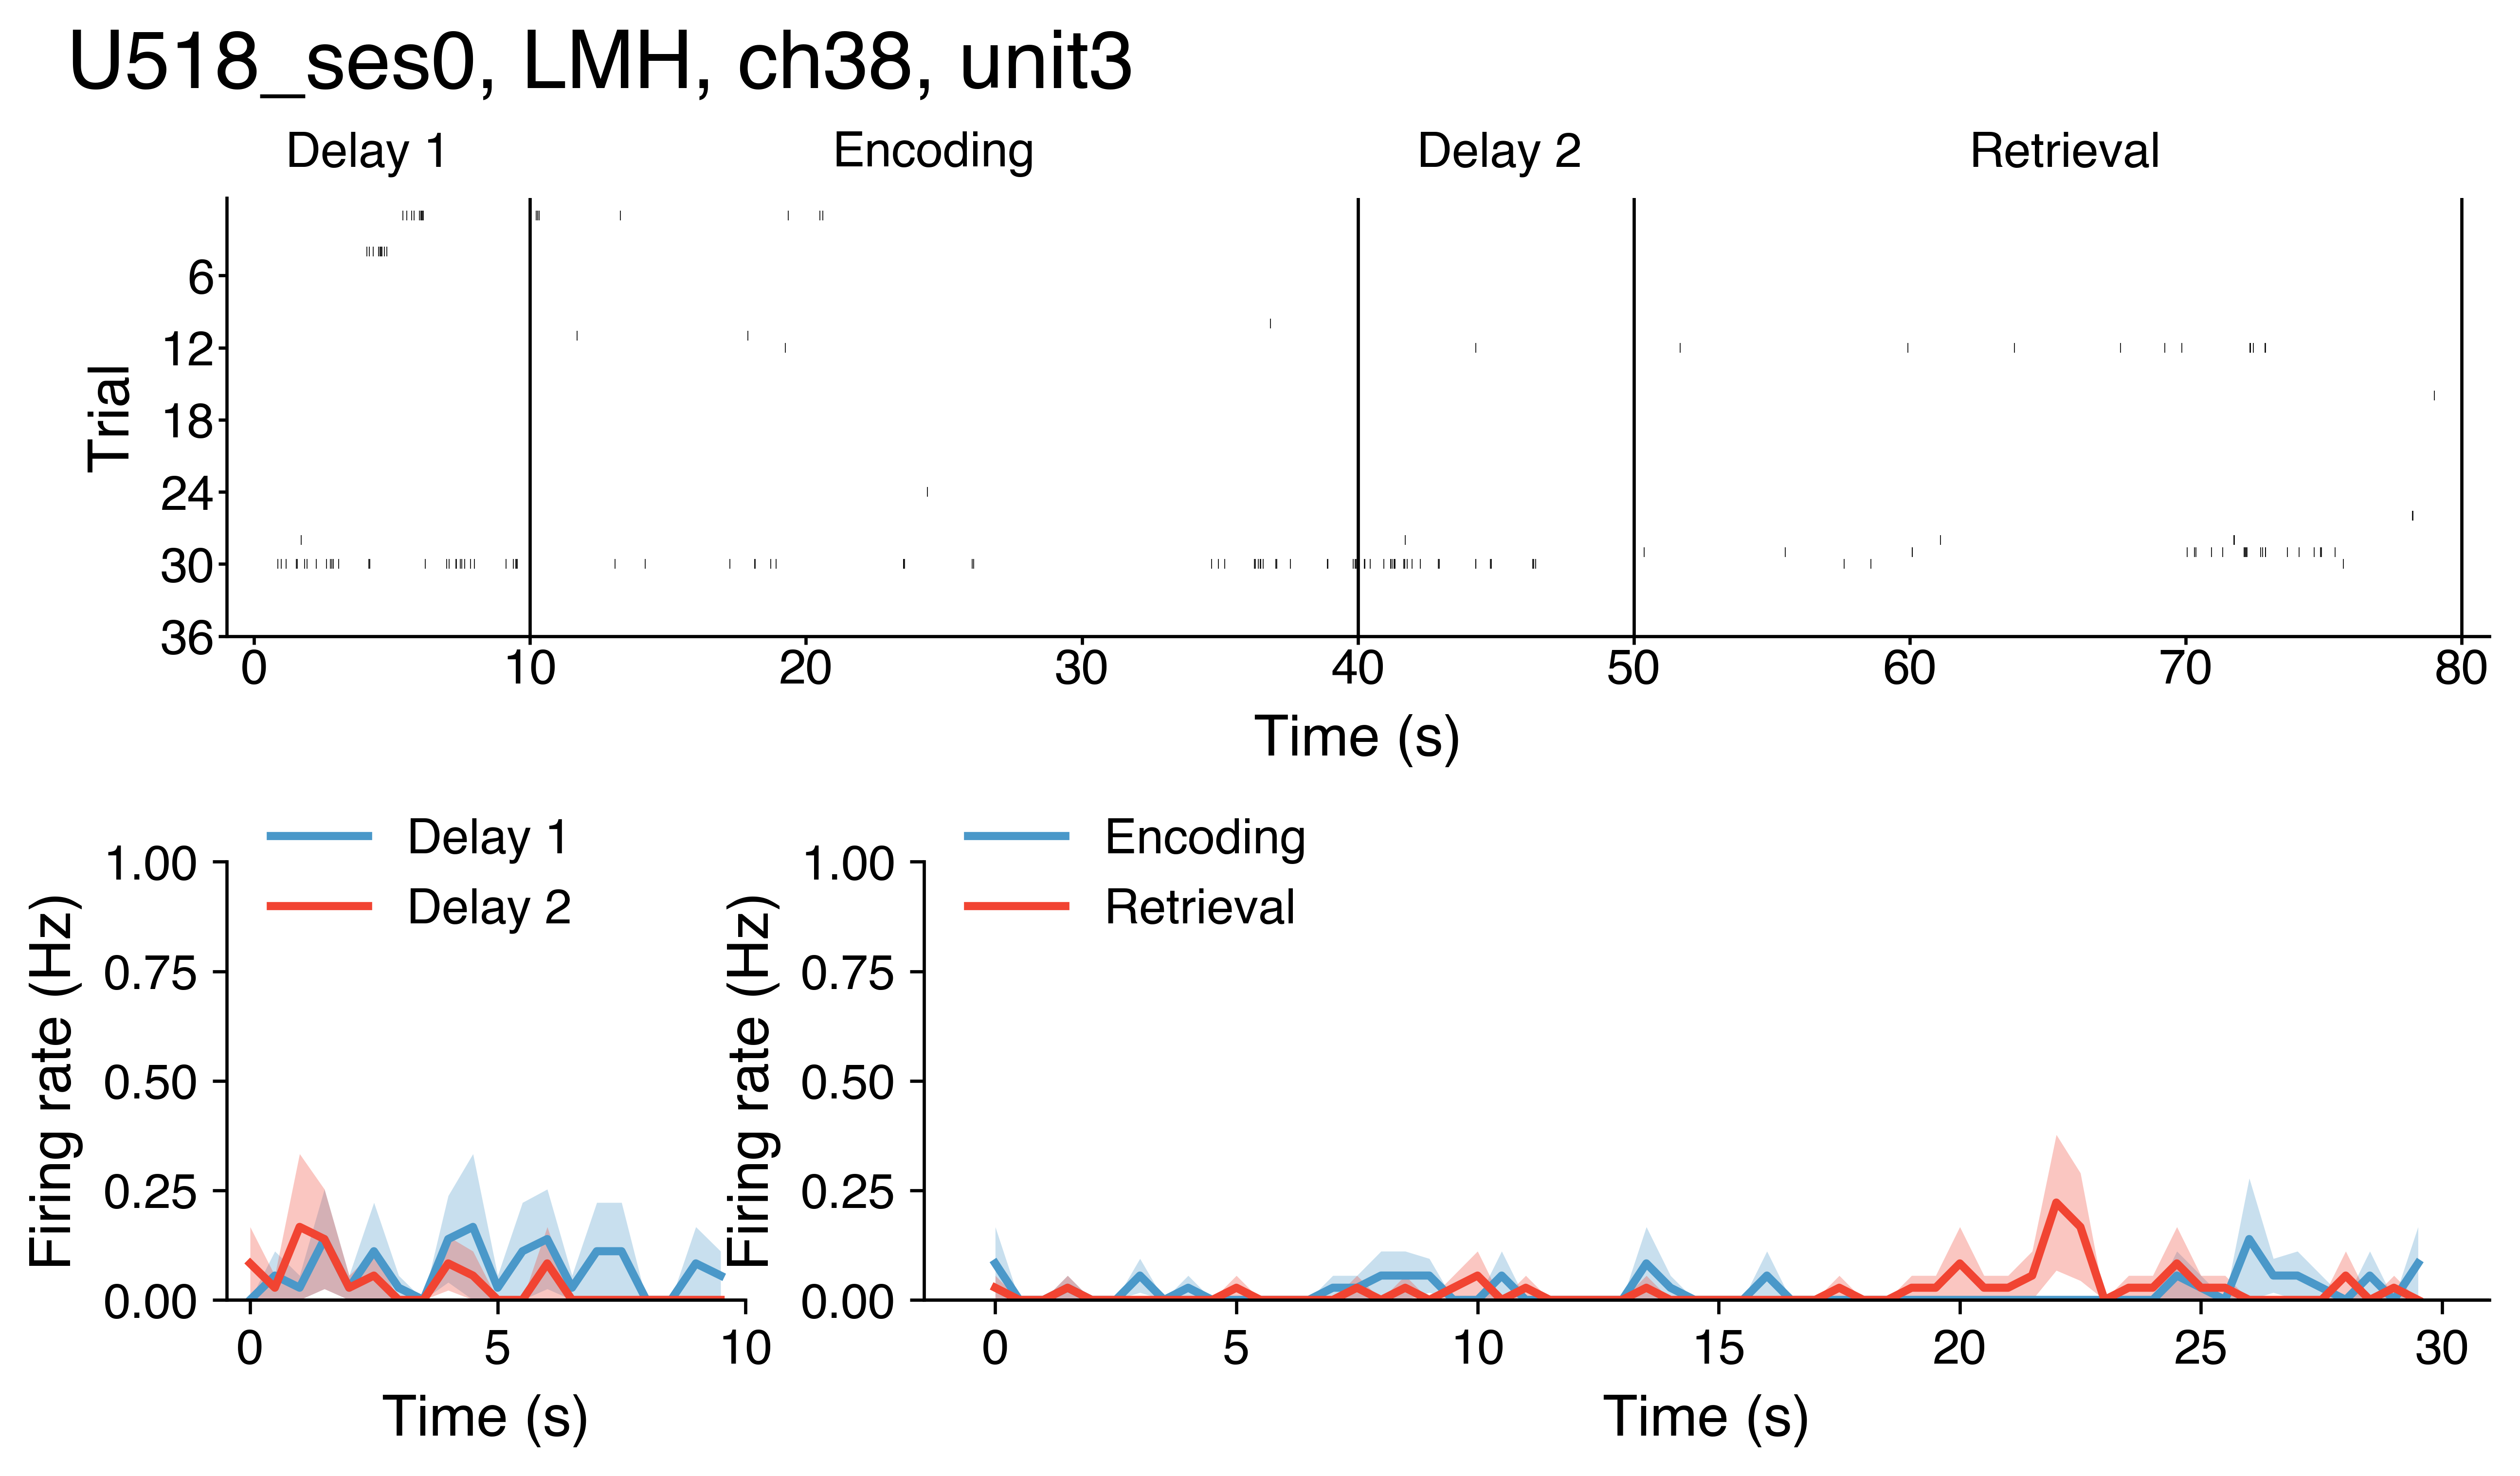

In [37]:
# Save spike raster and mean firing rate by trial phase plots
# for every neuron in the dataset.
add_sig_stars = False
savefig = False
overwrite = True
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']


for neuron in ['U518_ses0-38-3']:#neurons: #sig_cells[('any', 'time')]:
    subj_sess, chan, unit = neuron.split('-')
    hemroi = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))['hemroi']
    
    # Check if output file exists.
    fstr = '{}-CSC{}-unit{}-{}'.format(subj_sess, chan, unit, hemroi)
    fname = op.join(proj_dir, 'figs', '{}-Delay1_Delay2_Encoding_Retrieval_activity.png'.format(fstr))
    if op.exists(fname) and not overwrite:
        continue
    
    # Load events, firing rate vectors, and time bin indices.
    if ('events' not in locals()) and ('events' not in globals()):
        events = events_proc.load_events(subj_sess)
    elif subj_sess != events.event_times.iloc[0]['subj_sess']:
        events = events_proc.load_events(subj_sess)
    events.event_times['time'] = events.event_times.query("(gameState=={})".format(game_states))['time_bins'].apply(lambda x: [x[0], x[-1]])
    events.event_times['duration'] = events.event_times.query("(gameState=={})".format(game_states))['time'].apply(lambda x: x[-1] - x[0])
    
    twise_fr_by_time = od([])
    for game_state in game_states:
        twise_fr_by_time[game_state] = twise_spikes_by_time[game_state][neuron]
    
    # Determine significance levels.
    sig_levels = od([])
    if add_sig_stars:
        alphas = [0.05, 0.01, 0.001]
        for game_state in ['Delay1', 'Delay2']:
            pval = mean_fr.query("(subj_sess=='{}') & (chan=={}) & (unit=={}) & (game_state=='{}') & (fr_cat=='fr_by_time')".format(subj_sess, chan, unit, game_state)).iloc[0]['pval']
            sig_levels[game_state] = ''
            for alpha in alphas:
                if pval < alpha:
                    sig_levels[game_state] += '*'

        for game_state in ['Encoding', 'Retrieval']:
            pval = (mean_fr.query("(subj_sess=='{}') & (chan=={}) & (unit=={}) & (game_state=='{}') & (fr_cat=='fr_by_time')".format(subj_sess, chan, unit, game_state)).iloc[0]['pval'],
                    mean_fr.query("(subj_sess=='{}') & (chan=={}) & (unit=={}) & (game_state=='{}') & (fr_cat=='fr_by_time_subpos')".format(subj_sess, chan, unit, game_state)).iloc[0]['pval'])
            sig_levels[game_state] = ''
            for alpha in alphas:
                if (pval[0] < alpha) & (pval[1] < alpha):
                    sig_levels[game_state] += '*'
    
    # -------------------------------------------
    # PLOTTING
    plt.close()
    fig = plt.figure(figsize=(10, 5), dpi=600)
    n_rows = 50
    n_cols = 104
    ax = [plt.subplot2grid((n_rows, n_cols), (0, 0), rowspan=20, colspan=104),
          plt.subplot2grid((n_rows, n_cols), (30, 0), rowspan=20, colspan=24),
          plt.subplot2grid((n_rows, n_cols), (30, 32), rowspan=20, colspan=72)]
    ax = np.ravel(ax)
    
    # Spike raster plot.
    i = 0
    font['labelpad'] = 5
    ax[i] = trial_raster3('{}-{}-{}'.format(subj_sess, chan, unit),
                          events=events, 
                          rastersize=2.5,
                          rasterwidth=0.2,
                          ax_linewidth=0.8,
                          plot_title=False, 
                          font=font, 
                          ax=ax[i])
    
    # Delay 1 and Delay 2 mean +/- SEM firing rates.
    i = 1
    ymin = np.max((0, np.floor(np.min((np.min(np.mean(twise_fr_by_time['Delay1'], axis=0) - stats.sem(twise_fr_by_time['Delay1'], axis=0)),
                                       np.min(np.mean(twise_fr_by_time['Delay2'], axis=0) - stats.sem(twise_fr_by_time['Delay2'], axis=0)))))))
    ymax = np.ceil(np.max((np.max(np.mean(twise_fr_by_time['Delay1'], axis=0) + stats.sem(twise_fr_by_time['Delay1'], axis=0)),
                           np.max(np.mean(twise_fr_by_time['Delay2'], axis=0) + stats.sem(twise_fr_by_time['Delay2'], axis=0)))))
    for ii, game_state in enumerate(['Delay1', 'Delay2']):
        means_ = np.mean(twise_fr_by_time[game_state], axis=0)
        sems_ = stats.sem(twise_fr_by_time[game_state], axis=0)
        ax[i].axhline(0, color='k', linewidth=0.8)
        ax[i].fill_between(np.arange(len(means_)), means_ + sems_, means_ - sems_,
                           color=colors[ii], linewidth=0, alpha=0.3)
        ax[i].plot(means_, color=colors[ii], linewidth=2)
    ax[i].set_xticks(np.linspace(0, 20, 3))
    ax[i].set_xticklabels(np.linspace(0, 10, 3, dtype=np.int))
    ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
    ax[i].set_ylim([ymin, ymax])
    ax[i].set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=5)
    custom_lines = [Line2D([0], [0], label='Delay 1 {}'.format(sig_levels.get('Delay1', '')), color=colors[0], linewidth=2),
                    Line2D([0], [0], label='Delay 2 {}'.format(sig_levels.get('Delay2', '')), color=colors[1], linewidth=2)]
    legend = ax[i].legend(handles=custom_lines, fontsize=font['tick'], loc='upper left', bbox_to_anchor=(0, 1.2))

    # Encoding and retrieval mean +/- SEM firing rates.
    i = 2
    ymin = np.max((0, np.floor(np.min((np.min(np.mean(twise_fr_by_time['Encoding'], axis=0) - stats.sem(twise_fr_by_time['Encoding'], axis=0)),
                                       np.min(np.mean(twise_fr_by_time['Retrieval'], axis=0) - stats.sem(twise_fr_by_time['Retrieval'], axis=0)))))))
    ymax = np.ceil(np.max((np.max(np.mean(twise_fr_by_time['Encoding'], axis=0) + stats.sem(twise_fr_by_time['Encoding'], axis=0)),
                           np.max(np.mean(twise_fr_by_time['Retrieval'], axis=0) + stats.sem(twise_fr_by_time['Retrieval'], axis=0)))))
    for ii, game_state in enumerate(['Encoding', 'Retrieval']):
        means_ = np.mean(twise_fr_by_time[game_state], axis=0)
        sems_ = stats.sem(twise_fr_by_time[game_state], axis=0)
        ax[i].axhline(0, color='k', linewidth=0.8)
        ax[i].fill_between(np.arange(len(means_)), means_ + sems_, means_ - sems_,
                           color=colors[ii], linewidth=0, alpha=0.3)
        ax[i].plot(means_, color=colors[ii], linewidth=2)
    ax[i].set_xticks(np.linspace(0, 60, 7))
    ax[i].set_xticklabels(np.linspace(0, 30, 7, dtype=np.int))
    ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
    ax[i].set_ylim([ymin, ymax])
    ax[i].set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=5)
    custom_lines = [Line2D([0], [0], label='Encoding {}'.format(sig_levels.get('Encoding', '')), color=colors[0], linewidth=2),
                    Line2D([0], [0], label='Retrieval {}'.format(sig_levels.get('Retrieval', '')), color=colors[1], linewidth=2)]
    legend = ax[i].legend(handles=custom_lines, fontsize=font['tick'], loc='upper left', bbox_to_anchor=(0, 1.2))

    fig_title = '{}, {}, ch{}, unit{}'.format(subj_sess, hemroi, chan, unit)
    fig.text(0.07, 0.97, fig_title, color='k', fontsize=font['fig']+4, ha='left', va='center')

    if savefig:
        fig.savefig(fname, format='png', dpi=600, bbox_inches='tight')
    
fig.show()

In [732]:
np.sort(sig_cells[('Delay2', 'fr_by_time')])

array(['U518_ses0-11-1', 'U518_ses0-13-2', 'U518_ses0-16-2',
       'U518_ses0-30-1', 'U518_ses0-36-1', 'U518_ses0-38-3',
       'U518_ses0-4-1', 'U518_ses0-4-2', 'U518_ses0-40-1',
       'U518_ses0-65-1', 'U518_ses0-67-1', 'U518_ses0-67-2',
       'U518_ses0-73-1', 'U518_ses0-78-1', 'U518_ses0-79-1',
       'U518_ses0-9-1', 'U518_ses1-11-1', 'U518_ses1-12-1',
       'U518_ses1-13-2', 'U518_ses1-38-1', 'U518_ses1-4-1',
       'U518_ses1-42-1', 'U518_ses1-49-1', 'U518_ses1-65-2',
       'U518_ses1-67-1', 'U518_ses1-70-1', 'U518_ses1-73-2',
       'U518_ses1-79-1', 'U521_ses0-17-2', 'U521_ses0-19-2',
       'U521_ses0-23-1', 'U521_ses0-24-2', 'U526_ses0-12-1',
       'U526_ses0-15-1', 'U526_ses0-17-3', 'U527_ses0-13-2',
       'U527_ses0-16-1', 'U527_ses0-17-1', 'U527_ses0-45-1',
       'U527_ses0-57-1', 'U527_ses0-61-1', 'U527_ses0-9-2',
       'U530_ses0-44-2', 'U530_ses0-7-3', 'U530_ses0-73-1',
       'U530_ses0-75-1', 'U530_ses0-82-1', 'U530_ses1-13-1',
       'U530_ses1-79-1', 'U530

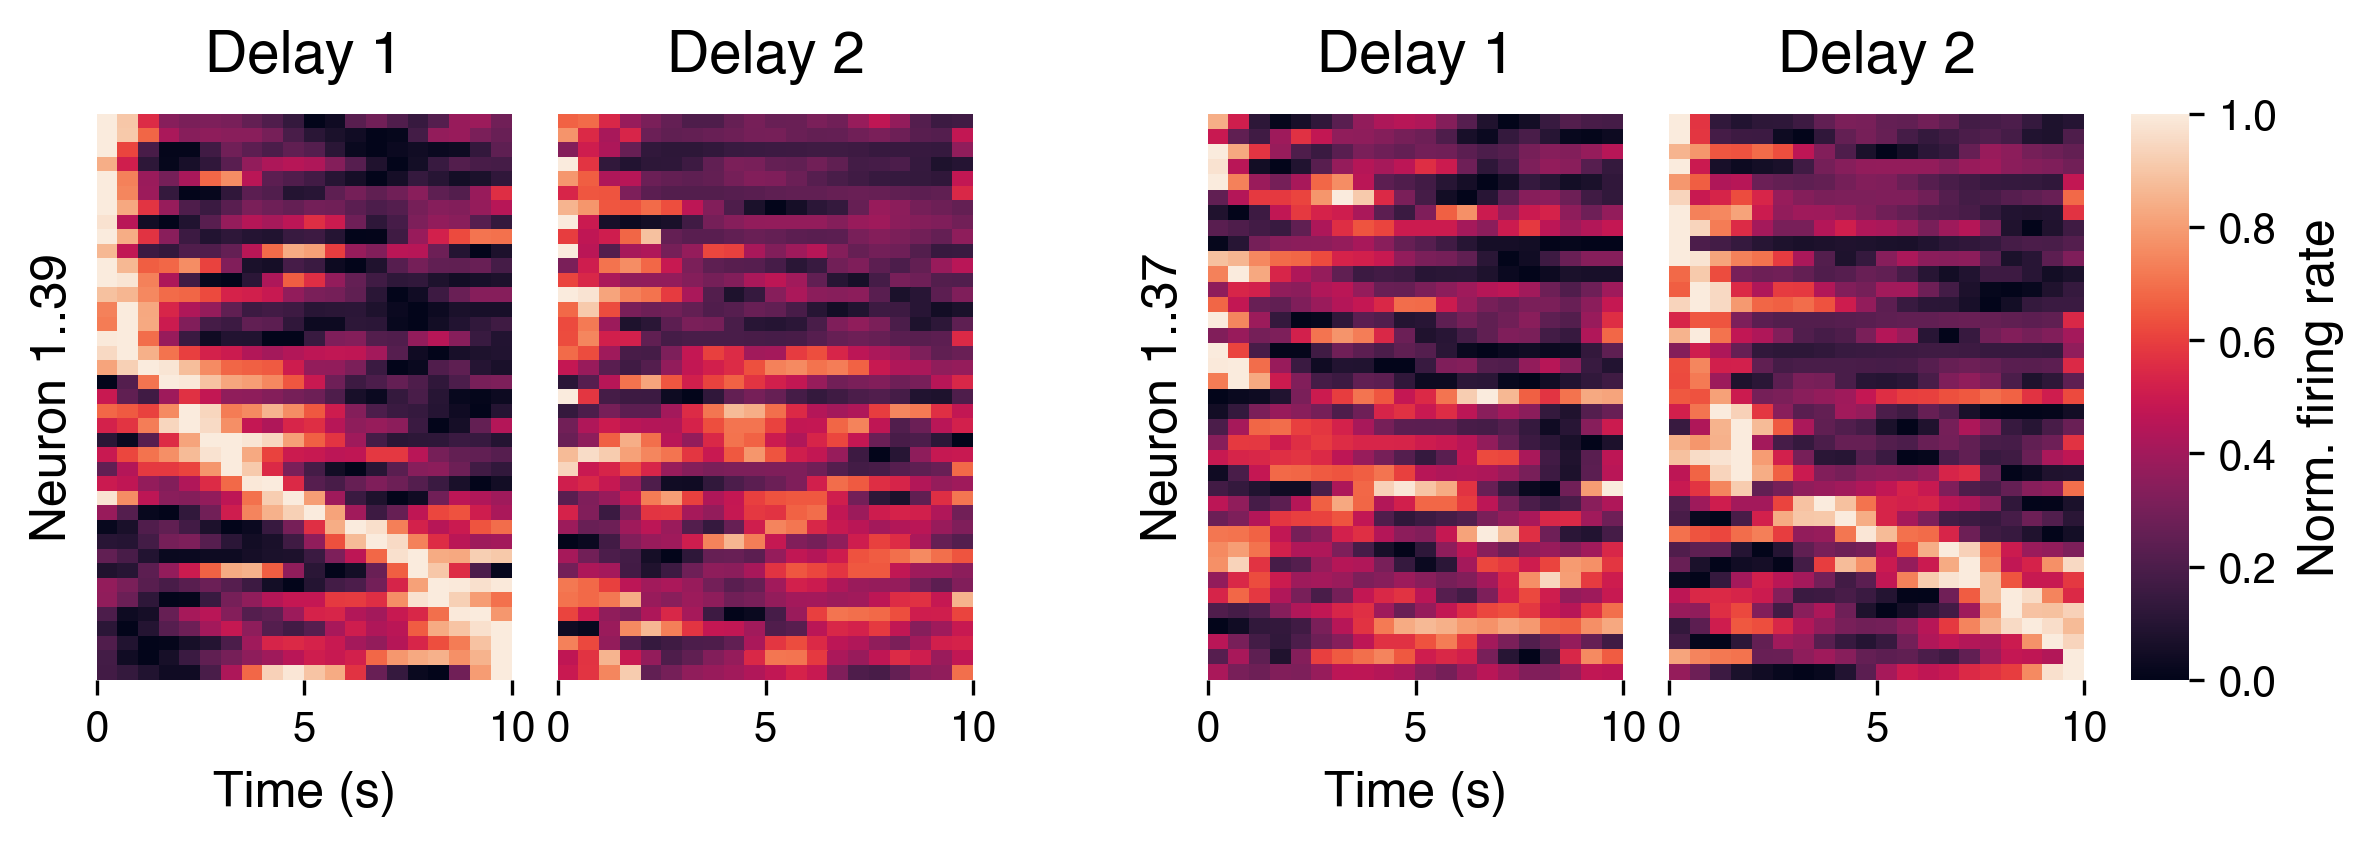

In [80]:
fr_cols = ['obs_fr_z_max_ind', 'obs_fr_z']
# fr_cols = ['obs_fr_max_ind', 'obs_fr']

plt.close()
fig = plt.figure(figsize=(9, 2.5), dpi=300)
grid_shp = (15, 100)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=15, colspan=20),
      plt.subplot2grid(grid_shp, (0, 22), rowspan=15, colspan=20),
      plt.subplot2grid(grid_shp, (0, 53), rowspan=15, colspan=20),
      plt.subplot2grid(grid_shp, (0, 75), rowspan=15, colspan=20),
      plt.subplot2grid(grid_shp, (0, 97), rowspan=15, colspan=3)]
ax = np.ravel(ax)

font = od([('tick', 10),
           ('label', 12),
           ('annot', 12),
           ('fig', 14)])

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Delay1': 'Delay 1 Time Cells',
             'Delay2': 'Delay 2 Time Cells',
             'Encoding': 'Encoding Time Cells',
             'Retrieval': 'Retrieval Time Cells',
             'Delay1_Delay2': 'Delay Time Cells',
             'Encoding_Retrieval': 'Navigation Time Cells'}

# The trial phases we want to examine significant time cells for.
game_states = ['Delay1', 'Delay2']
n_neurons = []
vmin = 0
vmax = 1
v_lines = [0, 20, 40]
for i, game_state in enumerate(game_states):
    add_cbar = False
    
    neurons = list(mean_fr.query("(fr_cat=='fr_by_time') & (neuron=={}) & (game_state=='{}')"
                                 .format(list(sig_cells[(game_state, 'fr_by_time')]), game_state))
                          .sort_values([fr_cols[0], 'roi', 'obs_info_z'], 
                                       ascending=(True, True, False))['neuron'].tolist())
    n_neurons.append(len(neurons))
#    # Scale Delay1 and Delay2 separately for each neuron
#     fr_mat = [minmax_scale([mean_fr.query("(fr_cat=='fr_by_time') & (neuron=='{}') & (game_state=='{}')"
#                                           .format(neuron, game_states[0])).iloc[0][fr_cols[1]].tolist()
#                             for neuron in neurons], axis=1),
#               minmax_scale([mean_fr.query("(fr_cat=='fr_by_time') & (neuron=='{}') & (game_state=='{}')"
#                                           .format(neuron, game_states[1])).iloc[0][fr_cols[1]].tolist()
#                             for neuron in neurons], axis=1)]
    
    # Scale Delay1 and Delay2 together for each neuron
    fr_mat = minmax_scale(np.hstack(([mean_fr.query("(fr_cat=='fr_by_time') & (neuron=='{}') & (game_state=='{}')"
                                                    .format(neuron, game_states[0])).iloc[0][fr_cols[1]].tolist()
                                      for neuron in neurons],
                                     [mean_fr.query("(fr_cat=='fr_by_time') & (neuron=='{}') & (game_state=='{}')"
                                                    .format(neuron, game_states[1])).iloc[0][fr_cols[1]].tolist()
                                      for neuron in neurons])), axis=1)
    fr_mat = [fr_mat[:, :20], fr_mat[:, 20:]]
    
    # Plot the firing rate heatmaps.
    for i_ in range(2):
        ii = (2*i) + i_
        if ii == len(ax)-2:
            add_cbar = True
        ax[ii] = sns.heatmap(fr_mat[i_], ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket', square=False, 
                             cbar=add_cbar, cbar_ax=ax[ii+1])
        ax[ii].tick_params(axis='y', which='both', length=0, pad=8)
        ax[ii].set_xticks(np.arange(0, fr_mat[i_].shape[1]+1, 10))
        ax[ii].set_xticklabels(np.arange(0, (fr_mat[i_].shape[1]+1)/2, 5, dtype=np.int), 
                                 fontsize=font['tick'], rotation=0)
        ax[ii].set_yticks([])
        if i_ == 0:
            ax[ii].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
            ax[ii].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=5)
        ax[ii].set_title(ax_labels[game_states[i_]], pad=10, fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'])
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=5)
        
fig.show()

if False:
    fstr = '-'.join(['{}{}'.format(n_neurons[ii], game_states[ii]) for ii in range(len(game_states))])
    fig.savefig(os.path.join(proj_dir, 'figs', 'all_time_cell_FRs_over_time-{}.png'.format(fstr)),
                format='png', dpi=300, bbox_inches='tight')

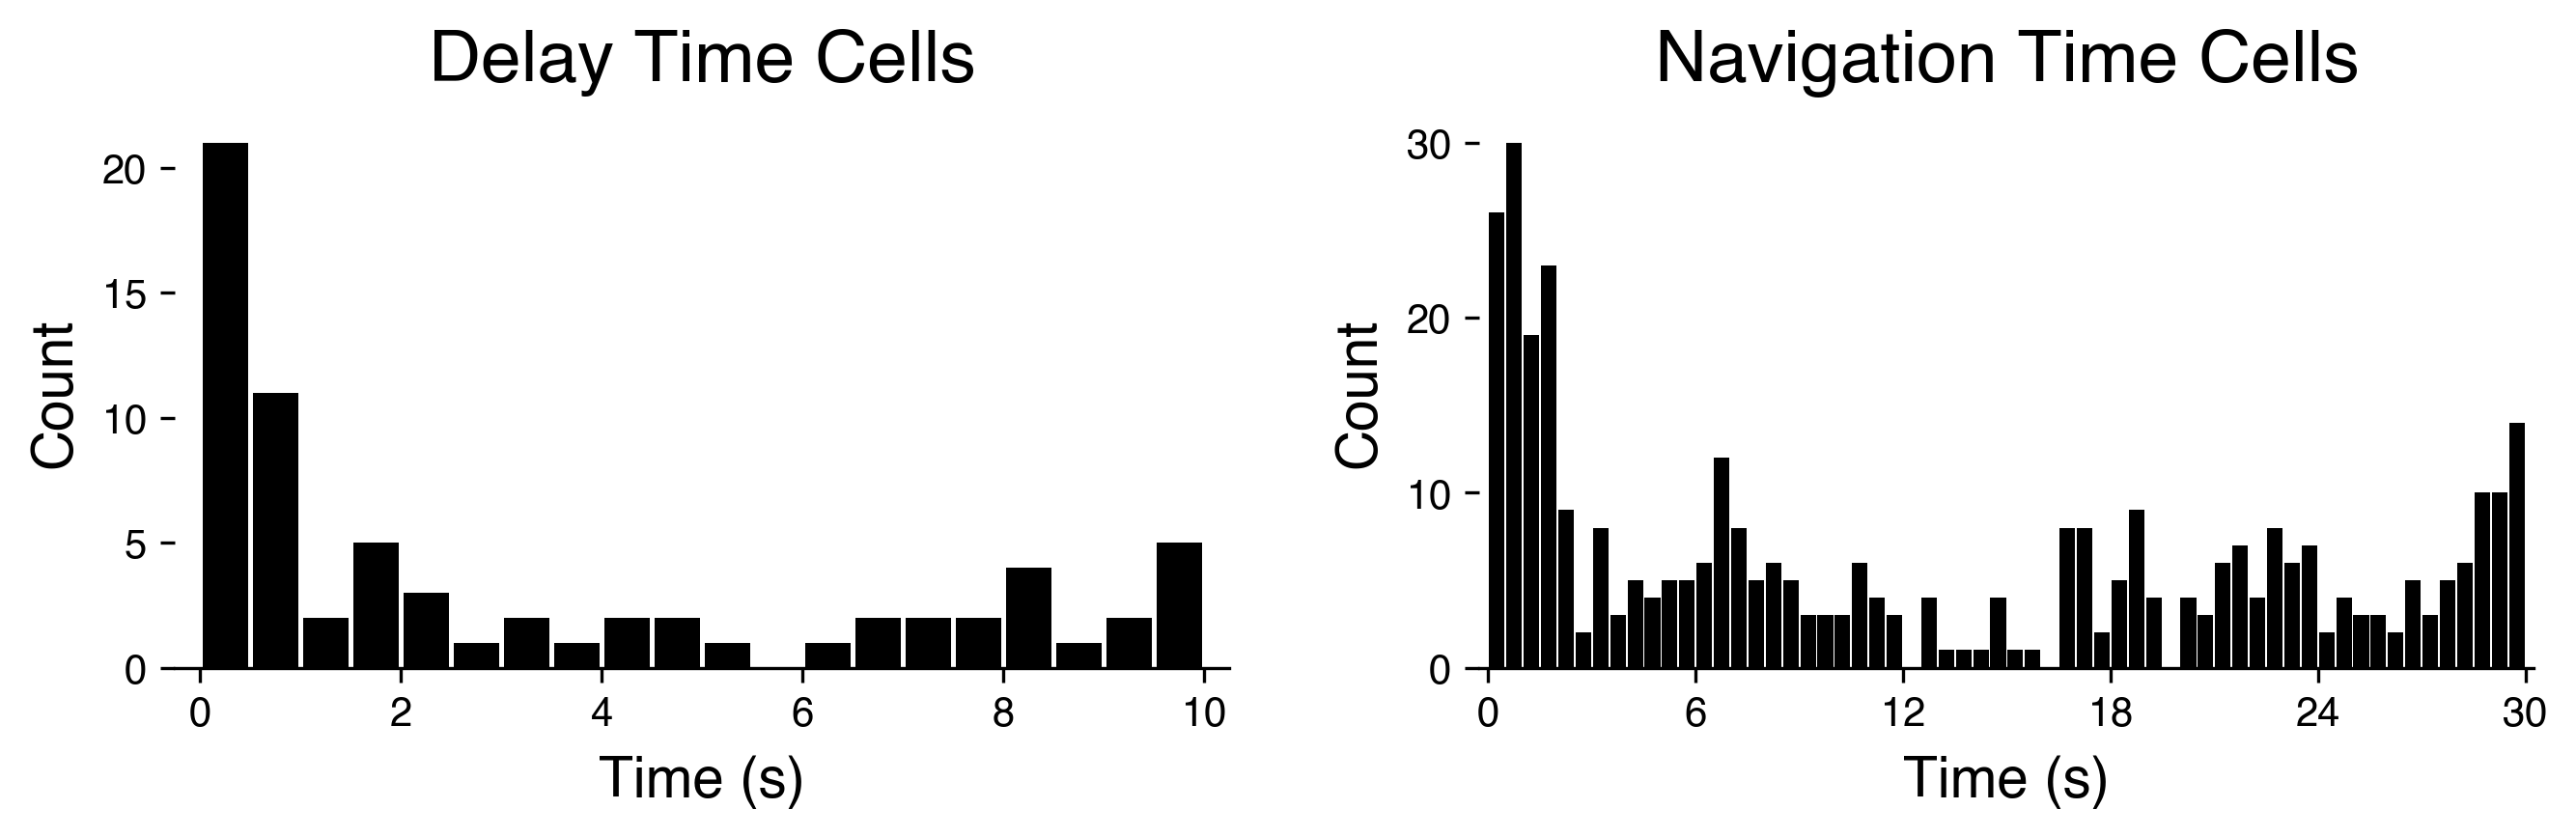

In [477]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
ax = np.ravel(ax)

font = od([('tick', 10),
           ('label', 14),
           ('annot', 12),
           ('fig', 18)])

n_bins = 20
d = mean_fr.query("(game_state==['Delay1', 'Delay2']) & (crit_sig==True)").groupby('obs_fr_z_max_ind').size().to_dict()
counts = []
for i in np.arange(n_bins):
    counts.append([d.get(i, 0)])
counts = pd.DataFrame(counts, columns=['val']).reset_index()

i = 0
ax[i].bar(counts.index+0.5, counts.val, width=0.9, color='k')
ax[i].set_xlim([-0.5, 20.5])
ax[i].set_xticks(np.linspace(0, 20, 6))
ax[i].set_xticklabels(np.linspace(0, 10, 6, dtype=np.int))
ax[i].tick_params(labelsize=font['tick'])
ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
ax[i].set_ylabel('Count', fontsize=font['label'], labelpad=5)
ax[i].spines['left'].set_visible(False)
# ax[i].grid(False)
ax[i].set_title('Delay Time Cells', fontsize=font['fig'], y=1.02)

n_bins = 60
d = mean_fr.query("(game_state==['Encoding', 'Retrieval']) & (crit_sig==True)").groupby('obs_fr_z_max_ind').size().to_dict()
counts = []
for i in np.arange(n_bins):
    counts.append([d.get(i, 0)])
counts = pd.DataFrame(counts, columns=['val']).reset_index()

i = 1
ax[i].bar(counts.index+0.5, counts.val, width=0.9, color='k')
ax[i].set_xlim([-0.5, 60.5])
ax[i].set_xticks(np.linspace(0, 60, 6))
ax[i].set_xticklabels(np.linspace(0, 30, 6, dtype=np.int))
ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
ax[i].set_ylabel('Count', fontsize=font['label'], labelpad=5)
ax[i].tick_params(labelsize=font['tick'])
ax[i].spines['left'].set_visible(False)
# ax[i].grid(False)
ax[i].set_title('Navigation Time Cells', fontsize=font['fig'], y=1.02)

fig.tight_layout(w_pad=2.5)

0.43833548768344693 0.0005158622407845418


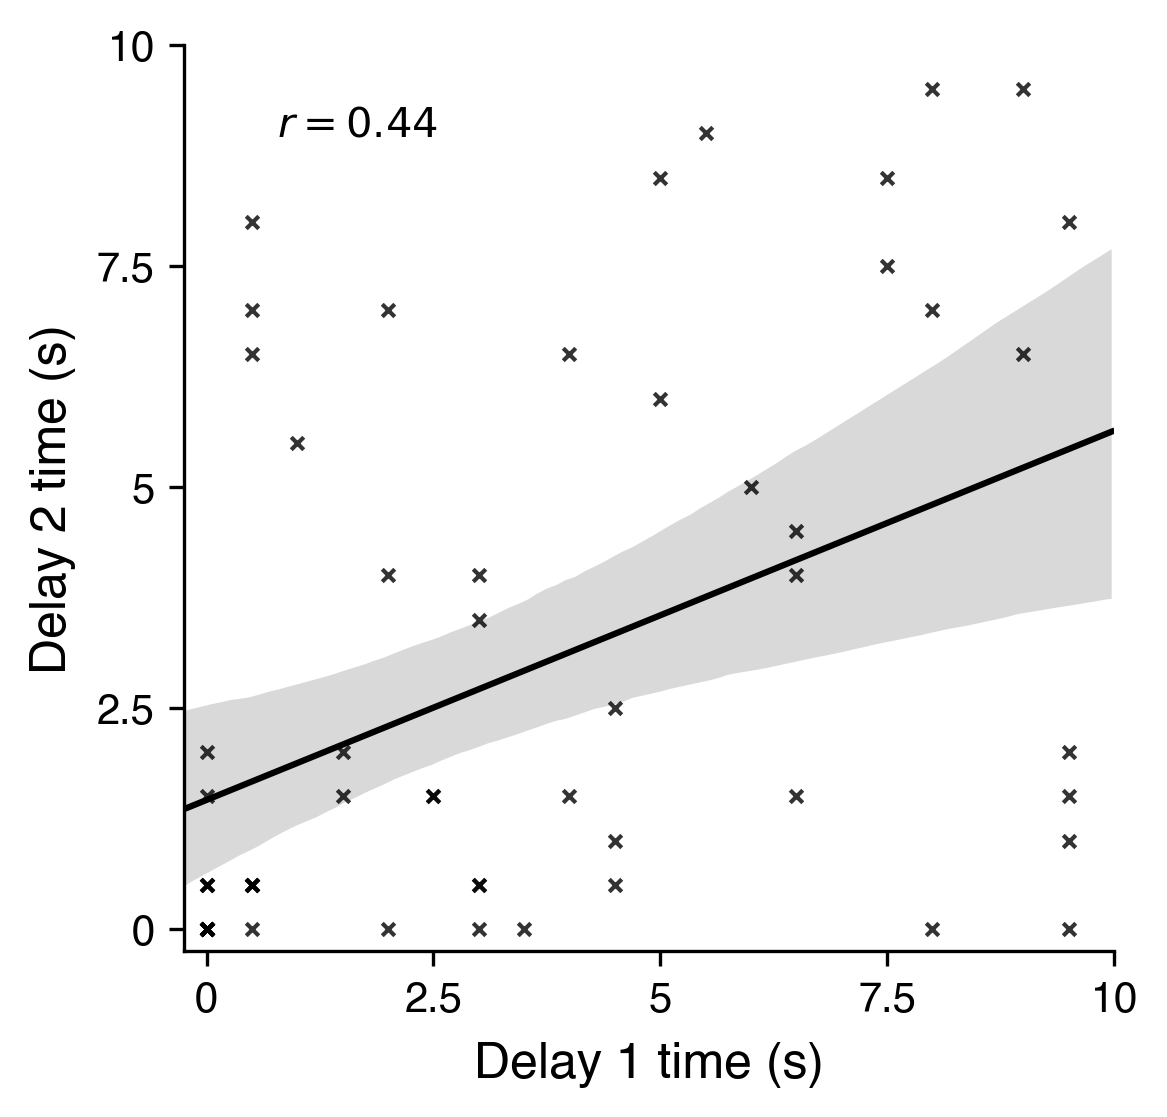

In [749]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

r, p = stats.pearsonr([mean_fr.query("(game_state=='Delay1') & (neuron=='{}')".format(x)).iloc[0]['obs_fr_z_max_ind'] for x in list(sig_cells[('delay', 'time')])],
                      [mean_fr.query("(game_state=='Delay2') & (neuron=='{}')".format(x)).iloc[0]['obs_fr_z_max_ind'] for x in list(sig_cells[('delay', 'time')])])
print(r, p)

sns.regplot([mean_fr.query("(game_state=='Delay1') & (neuron=='{}')".format(x)).iloc[0]['obs_fr_z_max_ind'] for x in list(sig_cells[('delay', 'time')])],
            [mean_fr.query("(game_state=='Delay2') & (neuron=='{}')".format(x)).iloc[0]['obs_fr_z_max_ind'] for x in list(sig_cells[('delay', 'time')])],
            ax=ax, marker='x', color='k')
ax.set_xlim([-0.5, 20])
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xticklabels([0, 2.5, 5, 7.5, 10], fontsize=font['tick'])
ax.set_xlabel('Delay 1 time (s)', fontsize=font['label'], labelpad=5)
ax.set_ylim([-0.5, 20])
ax.set_yticks([0, 5, 10, 15, 20])
ax.set_yticklabels([0, 2.5, 5, 7.5, 10], fontsize=font['tick'])
ax.set_ylabel('Delay 2 time (s)', fontsize=font['label'], labelpad=5)
ax.annotate('$r = {:.2f}$'.format(r), (0.1, 0.9), xycoords='axes fraction')
fig.show()

In [535]:
stats.pearsonr(field_size[0, :], field_size[1, :])

(0.13744964635053958, 0.2565114185180048)

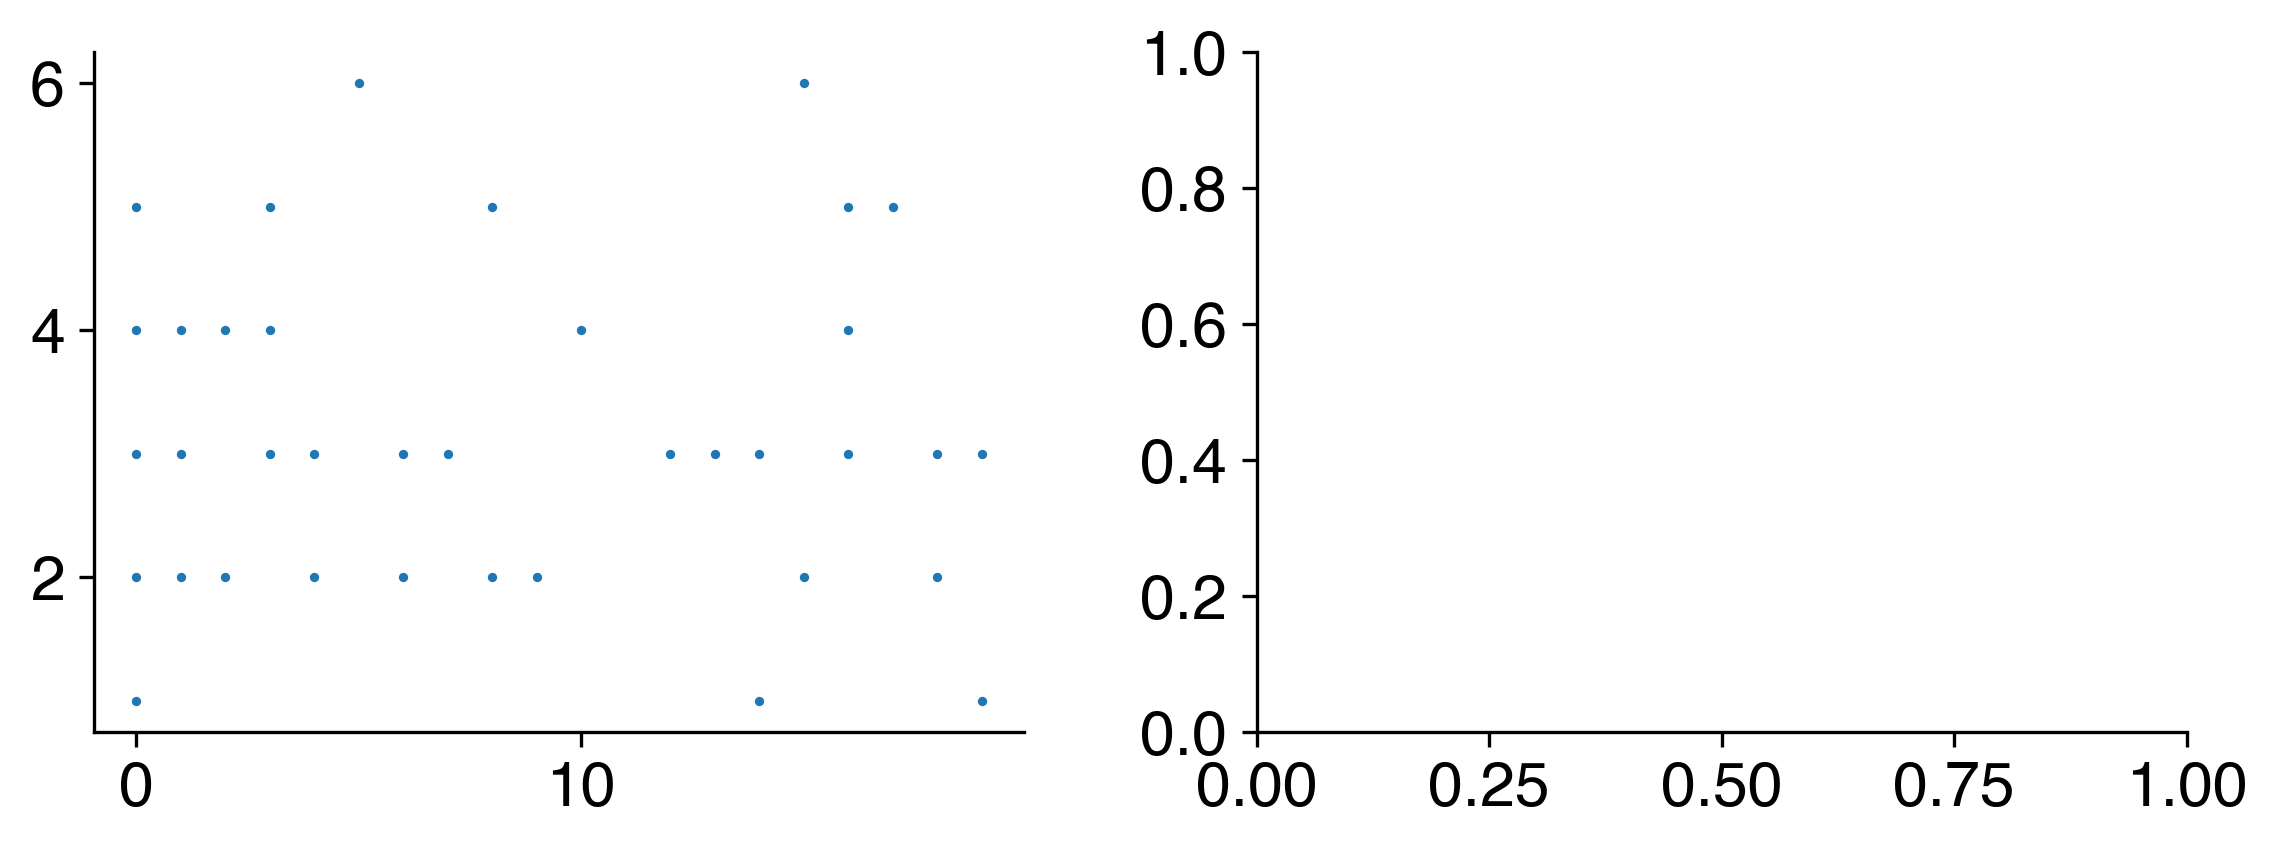

In [534]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=300)
ax = np.ravel(ax)

font = od([('tick', 10),
           ('label', 14),
           ('annot', 12),
           ('fig', 18)])

n_bins = 20
grp = mean_fr.query("(game_state==['Delay1', 'Delay2']) & (crit_sig==True)").groupby('obs_fr_z_max_ind')
field_size = [[], []]
for idx, df in grp:
    field_size[0].extend(list(idx * np.ones(len(df))))
    field_size[1].extend(df['time_field_size'].tolist())
field_size = np.array(field_size)

i = 0
ax[i] = sns.scatterplot(field_size[0, :], field_size[1, :], ax=ax[i])

In [1105]:
scaling_factor = 1

recalc_pos_intervals = False
if ('neuron' not in locals()) and ('neuron' not in globals()):
    recalc_pos_intervals = True
elif output.iloc[0]['subj_sess'] != neuron['subj_sess']:
    recalc_pos_intervals = True
if recalc_pos_intervals:
    events = goldmine_behavior.Events(output.iloc[0]['subj_sess'])
    events.log_position_intervals(idx_on='moved_pos')
    events.pos_intervals['pos'] = events.pos_intervals['pos'].apply(lambda x: (int(x[0]), int(x[1])))
    print(events.subj_sess)

neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'
                         .format(output.iloc[0]['subj_sess'], output.iloc[0]['chan'], output.iloc[0]['unit'])))

all_pos = od([])
fr_by_pos = od([])
for i, game_state in enumerate(['Encoding', 'Retrieval']):
    event_times_ = events.event_times.query("(gameState=='{}')".format(game_state)).copy()
    event_times_['spike_train'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0))
    spike_train_vec = np.concatenate(event_times_['spike_train'].tolist())
    event_times_['fr'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times']))
    fr_vec = np.concatenate(event_times_['fr'].tolist())

    positions_ = events.positions.query("(gameState=='{}')".format(game_state)).copy()
    all_pos[game_state] = od([])
    for trial, df in positions_.groupby('trial'):
        fr_arr = np.expand_dims(pd.merge(df[['gameState', 'trial', 'time', 'pos']], event_times_[['gameState', 'trial', 'time', 'fr']], 
                                         how='left', on=['gameState', 'trial']).apply(lambda x: x['fr'][x['time_x'] - x['time_y'][0]], axis=1),
                                axis=-1)
        all_pos[game_state][trial] = np.concatenate((np.array(df['pos'].tolist()) * scaling_factor, fr_arr), axis=-1)

    positions_['pos'] = positions_['pos'].apply(lambda x: (np.int(x[0]*scaling_factor), np.int(x[1]*scaling_factor)))
    idx_to_pos = positions_['pos'].value_counts().reset_index()['index'].to_dict()
    pos_to_idx = {v:k for k, v in idx_to_pos.items()}
    pos_vec = np.concatenate(positions_.apply(lambda x: pos_to_idx[x['pos']] * np.ones(x['dur']), axis=1).tolist())
    assert len(pos_vec) == len(fr_vec)
    dur_by_pos = {idx_to_pos[idx]:len(np.where(pos_vec==idx)[0]) for idx in idx_to_pos.keys()}
    trav_by_pos = events.pos_intervals.query("(gameState=='{}')".format(game_state))['pos'].apply(lambda x: (x[0]*scaling_factor, x[1]*scaling_factor)).value_counts().to_dict()
    fr_by_pos[game_state] = {idx_to_pos[idx]:np.mean(fr_vec[np.where(pos_vec==idx)[0]]) for idx in idx_to_pos.keys()}

U527_ses0


In [ ]:
plt.close()
fig = plt.figure(figsize=(9.5, 10.5), dpi=600)
n_rows = 105
n_cols = 95
ax = [plt.subplot2grid((n_rows, n_cols), (0, 0), rowspan=20, colspan=95),
      plt.subplot2grid((n_rows, n_cols), (35, 3), rowspan=30, colspan=52),
      plt.subplot2grid((n_rows, n_cols), (35, 60), rowspan=30, colspan=40),
      plt.subplot2grid((n_rows, n_cols), (75, 3), rowspan=30, colspan=52),
      plt.subplot2grid((n_rows, n_cols), (75, 60), rowspan=30, colspan=40)]
ax = np.ravel(ax)
events.plot_params['font'] = font

# Spike raster plot.
i = 0
ax[i] = trial_raster2('{}-{}-{}'.format(subj_sess, chan, unit),
                      events=events, plot_title=False, font=font, ax=ax[i])

# Mean firing rates, adj. or not adj. for position x head direction.
i = 1
ymin = np.max((0, np.floor(np.min((np.min(np.mean(twise_fr_by_time['Encoding'], axis=0) - stats.sem(twise_fr_by_time['Encoding'], axis=0)),
                                   np.min(np.mean(twise_fr_by_time['Retrieval'], axis=0) - stats.sem(twise_fr_by_time['Retrieval'], axis=0)))))))
ymax = np.ceil(np.max((np.max(np.mean(twise_fr_by_time['Encoding'], axis=0) + stats.sem(twise_fr_by_time['Encoding'], axis=0)),
                       np.max(np.mean(twise_fr_by_time['Retrieval'], axis=0) + stats.sem(twise_fr_by_time['Retrieval'], axis=0)))))
for game_state in ['Encoding', 'Retrieval']:
    # Actual firing rates
    means_ = np.mean(twise_fr_by_time[game_state], axis=0)
    sems_ = stats.sem(twise_fr_by_time[game_state], axis=0)
    ax[i].axhline(0, color='k', linewidth=0.8)
    ax[i].fill_between(np.arange(len(means_)), means_ + sems_, means_ - sems_,
                       color=colors[0], linewidth=0, alpha=0.3)
    ax[i].plot(means_, color=colors[0], linewidth=2)
    
    # Estimated firing rates (based on place and head direction)
    means_ = np.mean(twise_fr_by_time_subpos[game_state], axis=0)
    sems_ = stats.sem(twise_fr_by_time_subpos[game_state], axis=0)
    ax[i].fill_between(np.arange(len(means_)), means_ + sems_, means_ - sems_,
                       color=colors[1], linewidth=0, alpha=0.3)
    ax[i].plot(means_, color=colors[1], linewidth=2)
    
    ax[i].set_xticks(np.linspace(0, 60, 7))
    ax[i].set_xticklabels(np.linspace(0, 30, 7, dtype=np.int))
    ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
    ax[i].set_ylim([ymin, ymax])
    ax[i].set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=5)
    if game_state == 'Encoding':
        custom_lines = [Line2D([0], [0], label='Raw firing rate', color=colors[0], linewidth=2),
                        Line2D([0], [0], label='Place-adj. firing rate', color=colors[1], linewidth=2)]
        legend = ax[i].legend(handles=custom_lines, fontsize=font['tick'], loc='upper left', bbox_to_anchor=(0, 1.2))
    i += 2

# Mean firing rate map as a function of position.
i = 2
vmin = 0
vmax = np.max(np.concatenate([np.array(list(fr_by_pos[game_state].values())) for game_state in fr_by_pos.keys()]))
for game_state in ['Encoding', 'Retrieval']:
    ax[i], maze_map, mask = draw_maze_precise(events,
                                              fr_by_pos[game_state],
                                              scaling_factor=scaling_factor,
                                              do_convolve=False,
                                              all_pos=all_pos[game_state],
                                              show_nav=True,
                                              draw_base=True,
                                              cbar_label='Firing rate (Hz)',
                                              ax=ax[i],
                                              vmin=vmin,
                                              vmax=vmax,
                                              alpha_nav=0.4,
                                              square=True,
                                              cmap='rocket',
                                              cbar_kws={'pad': 0.05, 'shrink': 1})
    i += 2
    
l1 = Line2D([0.05, 0.95], [0.673, 0.673], color='k', linewidth=0.8, transform=fig.transFigure)
l2 = Line2D([0.05, 0.95], [0.355, 0.355], color='k', linewidth=0.8, transform=fig.transFigure)
fig.lines.extend([l1, l2])
fig.text(0.05, 0.522, 'Encoding', rotation=90, color='k', fontsize=font['fig']+4, ha='center', va='center')
fig.text(0.05, 0.236, 'Retrieval', rotation=90, color='k', fontsize=font['fig']+4, ha='center', va='center')
hemroi = output['hemroi'].iloc[0]
fig_title = '{}, {}, ch{}, unit{}'.format(subj_sess, hemroi, chan, unit)
fig.text(0.05, 0.93, fig_title, color='k', fontsize=font['fig']+4, ha='left', va='center')

savefig = False
if savefig:
    fstr = '{}-CSC{}-unit{}-{}'.format(subj_sess, chan, unit, hemroi)
    fig.savefig(os.path.join(proj_dir, 'figs', '{}-Encoding_Retrieval_activity.png'.format(fstr)),
                format='png', dpi=600, bbox_inches='tight')
    
fig.show()

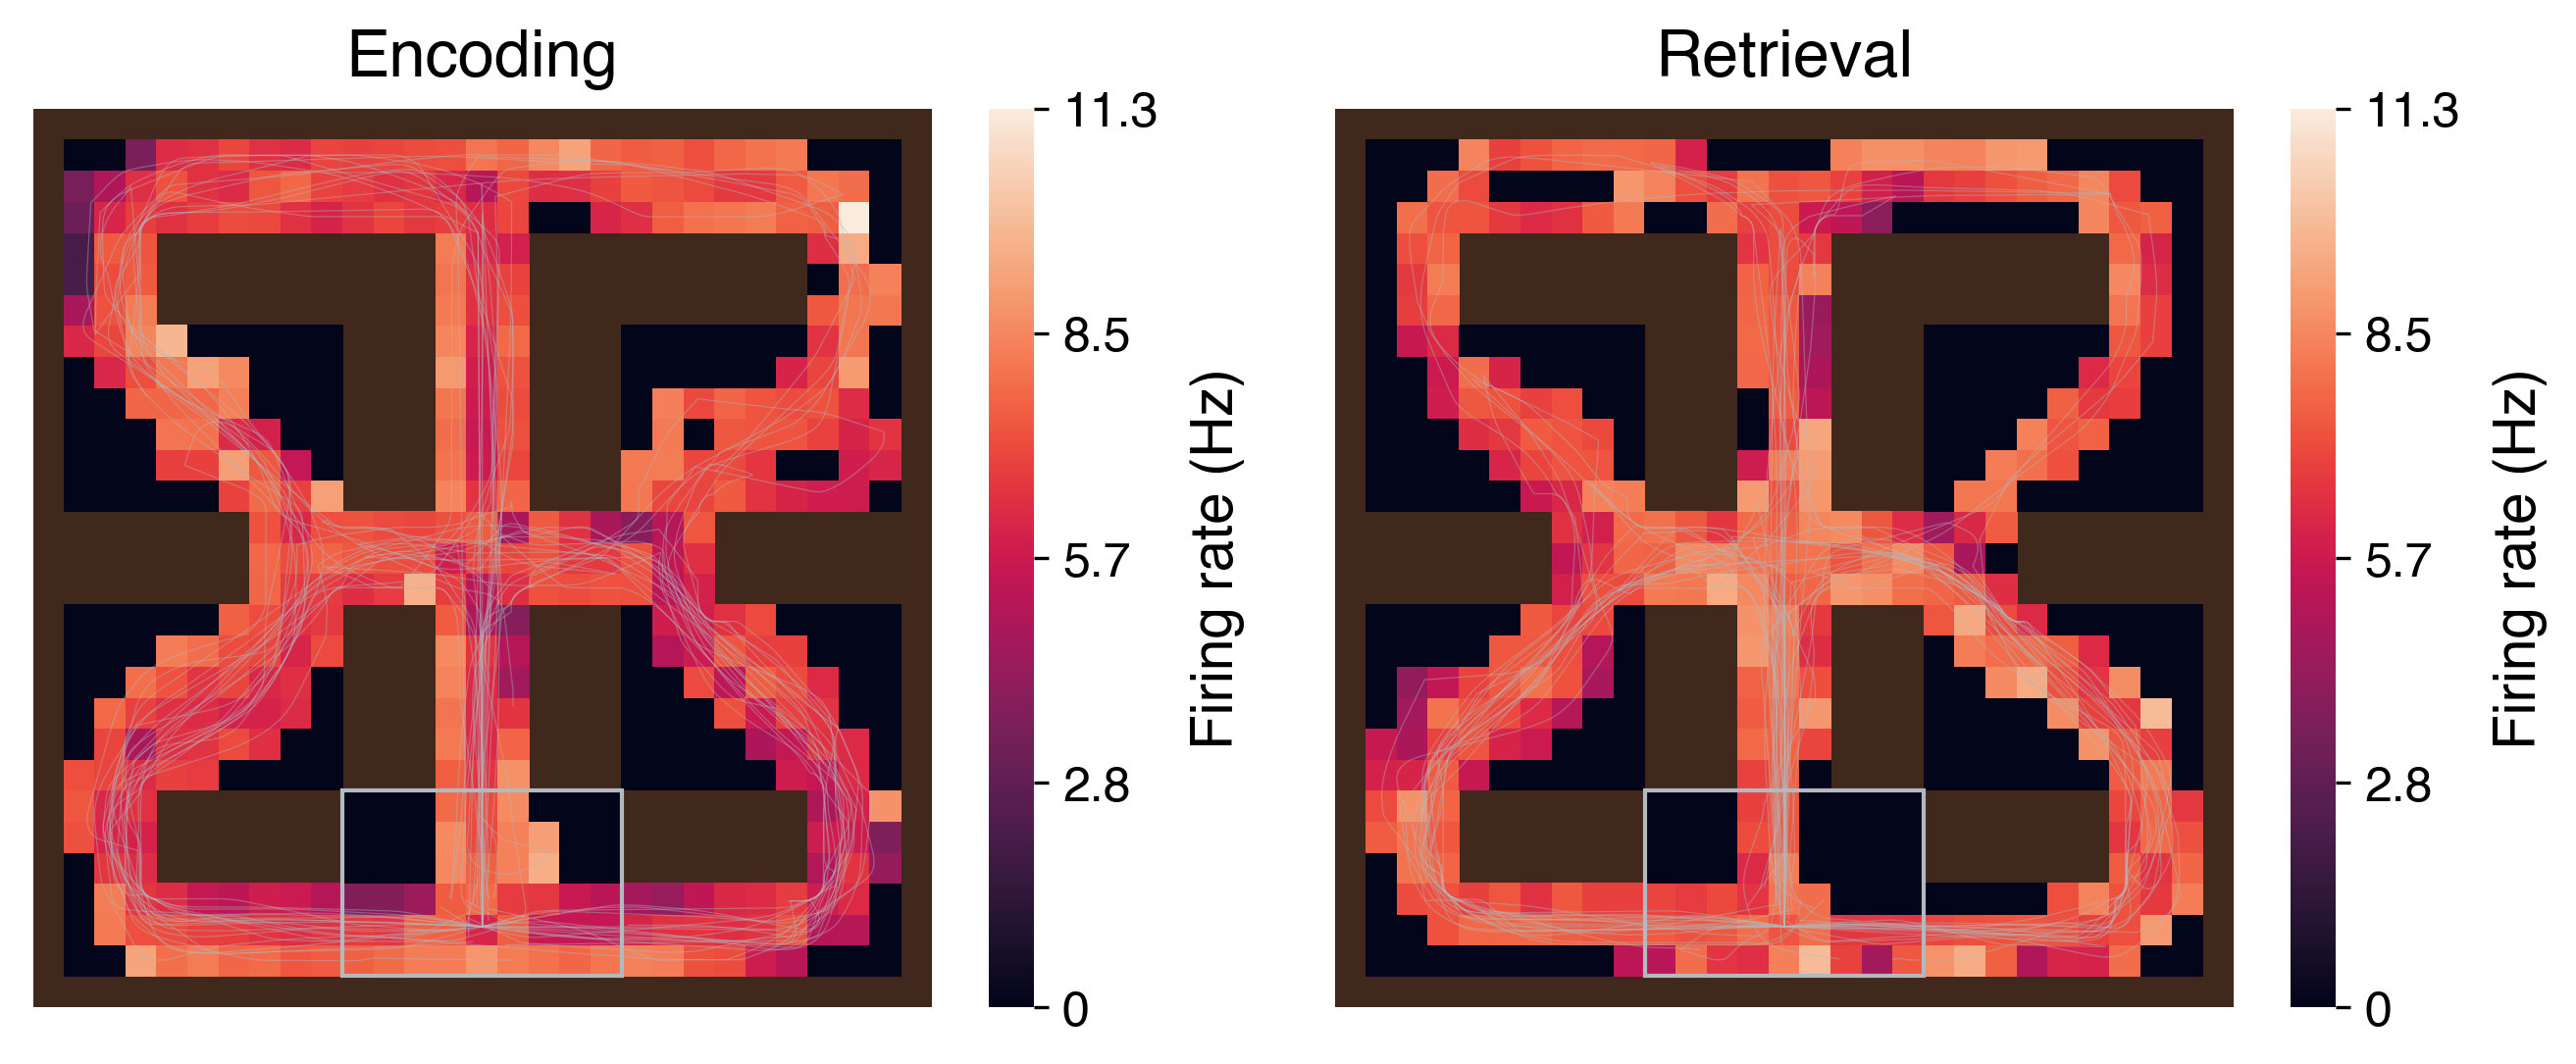

In [792]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(9, 3.6), dpi=300)
ax = np.ravel(ax)
    
vmin = 0
vmax = np.max(np.concatenate([np.array(list(fr_by_pos[game_state].values())) for game_state in fr_by_pos.keys()]))
    
for i, game_state in enumerate(['Encoding', 'Retrieval']):
    ax[i], maze_map, mask = draw_maze_precise(events,
                                              fr_by_pos[game_state],
                                              all_pos=all_pos[game_state],
                                              vmin=vmin,
                                              vmax=vmax,
                                              scaling_factor=scaling_factor,
                                              do_convolve=False,
                                              show_nav=True,
                                              draw_base=True,
                                              square=True,
                                              cmap='rocket',
                                              alpha_nav=0.4,
                                              cbar_label='Firing rate (Hz)',
                                              ax=ax[i])
    ax[i].set_title(game_state, fontsize=events.plot_params['font']['fig'], pad=8)

fig.tight_layout()

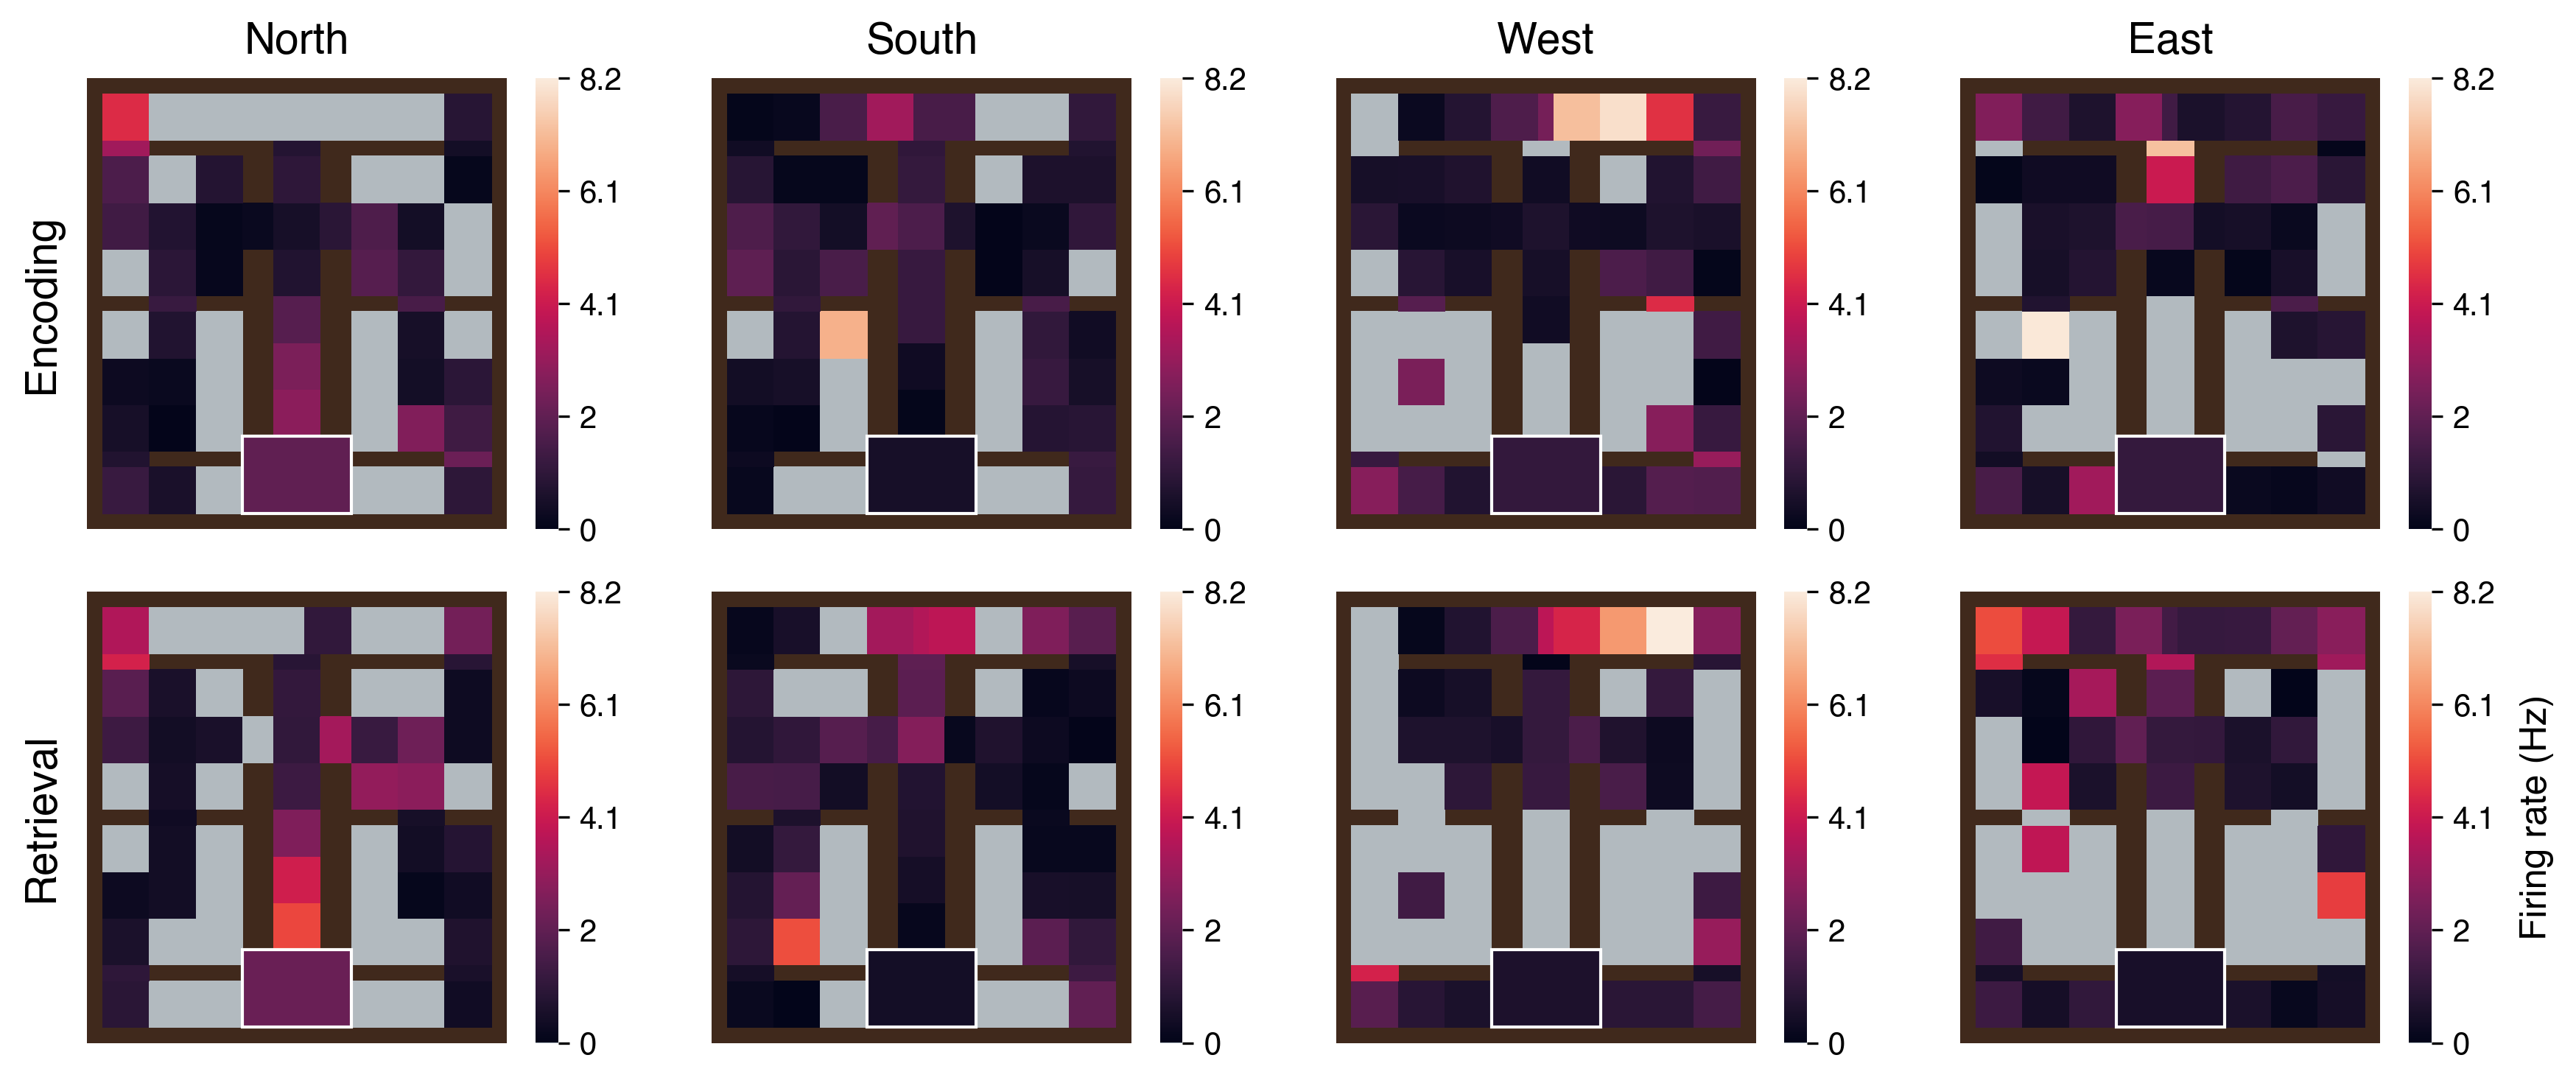

In [954]:
min_traversals = 3
game_states = ['Encoding', 'Retrieval']

events = goldmine_behavior.Events(output.iloc[0]['subj_sess'])
events.log_position_intervals(idx_on='moved_pos_or_hd')
neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'fr_by_time_and_pos', 
                                 '{}-CSC{}-unit{}-fr_by_time_and_pos.pkl'
                                 .format(output.iloc[0]['subj_sess'], output.iloc[0]['chan'], output.iloc[0]['unit'])))

fr_by_pos = neuron['mean_frs_obs']['fr_by_pos']

pos_traversals = {}
for game_state in game_states:
    pos_traversals[game_state] = {k:events.pos_intervals.query("(gameState=='{}')".format(game_state)).groupby('maze_idx_hd').size().to_dict().get(k, 0)
                                  for k in fr_by_pos[game_state].keys()}
    
plt.close()
fig, ax = plt.subplots(2, 4, figsize=(12, 5), dpi=300)
ax = np.ravel(ax)

vmin = 0
vmax = np.max([np.max(list(fr_by_pos[game_state].values())) for game_state in fr_by_pos.keys()])

for iRow, game_state in enumerate(game_states):
    i = (4*iRow) + 0
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k]
                                  for k in fr_by_pos[game_state]
                                  if np.all((k%1 == 0, 
                                             pos_traversals[game_state][k] >= min_traversals))},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 ax=ax[i])
    ax[i].set_ylabel(game_state, fontsize=events.plot_params['font']['fig'], labelpad=8)
    if iRow == 0:
        ax[i].set_title('North', fontsize=events.plot_params['font']['fig'], pad=8)

    i = (4*iRow) + 1
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0.5)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 ax=ax[i])
    if iRow == 0:
        ax[i].set_title('South', fontsize=events.plot_params['font']['fig'], pad=8)

    i = (4*iRow) + 2
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0.75)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 ax=ax[i])
    if iRow == 0:
        ax[i].set_title('West', fontsize=events.plot_params['font']['fig'], pad=8)

    i = (4*iRow) + 3
    cbar_label = 'Firing rate (Hz)' if (iRow == 1) else ''
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0.25)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 cbar_label=cbar_label,
                                 ax=ax[i])
    if iRow == 0:
        ax[i].set_title('East', fontsize=events.plot_params['font']['fig'], pad=8)

fig.tight_layout()

In [308]:
n_neurons = len(mean_fr['neuron'].unique())

fr_cat = 'fr_by_time'
n_enc = len(sig_cells[('Delay1', fr_cat)])
n_rec = len(sig_cells[('Delay2', fr_cat)])
n_both = len([x for x in sig_cells[('Delay1', fr_cat)] if x in sig_cells[('Delay2', fr_cat)]])
print('Time: {}/{} ({:.1%}) delay 1, {}/{} ({:.1%}) delay 2, {}/{} ({:.1%}) both'.format(
      n_enc, n_neurons, n_enc/n_neurons,
      n_rec, n_neurons, n_rec/n_neurons,
      n_both, n_neurons, n_both/n_neurons))

fr_cat = 'time'
n_enc = len(sig_cells[('Encoding', fr_cat)])
n_rec = len(sig_cells[('Retrieval', fr_cat)])
n_both = len([x for x in sig_cells[('Encoding', fr_cat)] if x in sig_cells[('Retrieval', fr_cat)]])
print('Time: {}/{} ({:.1%}) encoding, {}/{} ({:.1%}) retrieval, {}/{} ({:.1%}) both'.format(
      n_enc, n_neurons, n_enc/n_neurons,
      n_rec, n_neurons, n_rec/n_neurons,
      n_both, n_neurons, n_both/n_neurons))
      
fr_cat = 'pos'
n_enc = len(sig_cells[('Encoding', fr_cat)])
n_rec = len(sig_cells[('Retrieval', fr_cat)])
n_both = len([x for x in sig_cells[('Encoding', fr_cat)] if x in sig_cells[('Retrieval', fr_cat)]])
print('Place: {}/{} ({:.1%}) encoding, {}/{} ({:.1%}) retrieval, {}/{} ({:.1%}) both'.format(
      n_enc, n_neurons, n_enc/n_neurons,
      n_rec, n_neurons, n_rec/n_neurons,
      n_both, n_neurons, n_both/n_neurons))

game_state = 'Encoding'
n_time = len(sig_cells[(game_state, 'time')])
n_pos = len(sig_cells[(game_state, 'pos')])
n_both = len([x for x in sig_cells[(game_state, 'time')] if x in sig_cells[(game_state, 'pos')]])
print('Encoding: {}/{} ({:.1%}) time, {}/{} ({:.1%}) place, {}/{} ({:.1%}) both'.format(
      n_time, n_neurons, n_time/n_neurons,
      n_pos, n_neurons, n_pos/n_neurons,
      n_both, n_neurons, n_both/n_neurons))

game_state = 'Retrieval'
n_time = len(sig_cells[(game_state, 'time')])
n_pos = len(sig_cells[(game_state, 'pos')])
n_both = len([x for x in sig_cells[(game_state, 'time')] if x in sig_cells[(game_state, 'pos')]])
print('Retrieval: {}/{} ({:.1%}) time, {}/{} ({:.1%}) place, {}/{} ({:.1%}) both'.format(
      n_time, n_neurons, n_time/n_neurons,
      n_pos, n_neurons, n_pos/n_neurons,
      n_both, n_neurons, n_both/n_neurons))

Time: 39/270 (14.4%) delay 1, 31/270 (11.5%) delay 2, 11/270 (4.1%) both
Time: 19/270 (7.0%) encoding, 29/270 (10.7%) retrieval, 4/270 (1.5%) both
Place: 46/270 (17.0%) encoding, 49/270 (18.1%) retrieval, 20/270 (7.4%) both
Encoding: 19/270 (7.0%) time, 46/270 (17.0%) place, 2/270 (0.7%) both
Retrieval: 29/270 (10.7%) time, 49/270 (18.1%) place, 5/270 (1.9%) both


In [547]:
units_by_roi = mean_fr.groupby('roi').agg({'neuron': lambda x: len(np.unique(x))}).to_dict()['neuron']
delay_time_cell_rois = pd.Series([mean_fr.query("(neuron=='{}')".format(x)).iloc[0]['roi'] for x in sig_cells[('delay', 'time')]]).value_counts().to_dict()
nav_time_cell_rois = pd.Series([mean_fr.query("(neuron=='{}')".format(x)).iloc[0]['roi'] for x in sig_cells[('nav', 'time')]]).value_counts().to_dict()
place_cell_rois = pd.Series([mean_fr.query("(neuron=='{}')".format(x)).iloc[0]['roi'] for x in sig_cells[('nav', 'pos')]]).value_counts().to_dict()

roi_counts = []
for roi in units_by_roi:
    roi_counts.append([roi, units_by_roi[roi], delay_time_cell_rois[roi], nav_time_cell_rois[roi], place_cell_rois[roi]])
roi_counts = pd.DataFrame(roi_counts, columns=['roi', 'units', 'delay_time_cells', 'nav_time_cells', 'place_cells'])
roi_counts['delay_time_cell_pct'] = roi_counts.apply(lambda x: 100 * (x['delay_time_cells']/x['units']), axis=1)
roi_counts['nav_time_cell_pct'] = roi_counts.apply(lambda x: 100 * (x['nav_time_cells']/x['units']), axis=1)
roi_counts['place_cell_pct'] = roi_counts.apply(lambda x: 100 * (x['place_cells']/x['units']), axis=1)
roi_counts

,roi,units,delay_time_cells,nav_time_cells,place_cells,delay_time_cell_pct,nav_time_cell_pct,place_cell_pct
0,Amygdala,36,5,12,14,13.888889,33.333333,38.888889
1,Cortical,88,26,41,63,29.545455,46.590909,71.590909
2,EC,58,9,27,19,15.517241,46.551724,32.758621
3,Frontal,32,7,18,20,21.875000,56.250000,62.500000
4,Hippocampus,56,12,18,17,21.428571,32.142857,30.357143


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3), dpi=300)
ax = np.ravel(ax)



In [371]:
mean_fr.query("(game_state==['Delay1', 'Delay2']) & (sig==True)").groupby('obs_fr_z_abs_max_sign').agg({'neuron': len, 
                                                                                                        'obs_fr_z_max_ind': lambda x: np.round(np.mean(x), 1), 
                                                                                                        'obs_fr_z_max': lambda x: np.round(np.mean(x), 1),
                                                                                                        'crit_sig': np.sum,
                                                                                                        'time_field_size': np.mean})

,neuron,obs_fr_z_max_ind,obs_fr_z_max,crit_sig,time_field_size
obs_fr_z_abs_max_sign,,,,,
-1,22,9.2,2.2,0.0,1.272727
1,70,6.0,3.9,70.0,2.828571


In [483]:
sig_col = 'crit_sig'

neurons = [x for x in sig_cells[('Delay1', 'fr_by_time')] if x in sig_cells[('Delay2', 'fr_by_time')]]
print(len(neurons), stats.linregress(mean_fr.query("(neuron=={}) & (game_state=='Delay1')".format(neurons))['obs_fr_z_max_ind'],
                                     mean_fr.query("(neuron=={}) & (game_state=='Delay2')".format(neurons))['obs_fr_z_max_ind']))

neurons = [x for x in mean_fr.query("(game_state==['Delay1', 'Delay2']) & ({}==True)".format(sig_col))['neuron'].unique().tolist()
           if x not in neurons]
print(len(neurons), stats.linregress(mean_fr.query("(neuron=={}) & (game_state=='Delay1')".format(neurons))['obs_fr_z_max_ind'],
                                     mean_fr.query("(neuron=={}) & (game_state=='Delay2')".format(neurons))['obs_fr_z_max_ind']))

neurons = [x for x in mean_fr.query("(game_state==['Delay1', 'Delay2']) & ({}==True)".format(sig_col))['neuron'].unique().tolist()]
print(len(neurons), stats.linregress(mean_fr.query("(neuron=={}) & (game_state=='Delay1')".format(neurons))['obs_fr_z_max_ind'],
                                     mean_fr.query("(neuron=={}) & (game_state=='Delay2')".format(neurons))['obs_fr_z_max_ind']))

neurons = [x for x in mean_fr.query("(game_state==['Delay1', 'Delay2']) & ({}==True)".format(sig_col))['neuron'].unique().tolist()]
print(len(neurons), stats.linregress(mean_fr.query("(neuron=={}) & (game_state=='Delay1')".format(neurons))['obs_fr_z_max'],
                                     mean_fr.query("(neuron=={}) & (game_state=='Delay2')".format(neurons))['obs_fr_z_max']))

neurons = [x for x in mean_fr.query("(game_state==['Delay1', 'Delay2']) & ({}==True)".format(sig_col))['neuron'].unique().tolist()]
print(len(neurons), stats.linregress(mean_fr.query("(neuron=={}) & (game_state=='Delay1')".format(neurons))['obs_info_z'],
                                     mean_fr.query("(neuron=={}) & (game_state=='Delay2')".format(neurons))['obs_info_z']))

11 LinregressResult(slope=0.031249999999999993, intercept=0.34375, rvalue=0.0747017880833996, pvalue=0.8272061621093959, stderr=0.13905372163304366)
48 LinregressResult(slope=0.29964739957184233, intercept=4.55295302858582, rvalue=0.30639175512868416, pvalue=0.034173135008599365, stderr=0.13726138025905638)
59 LinregressResult(slope=0.417731672103096, intercept=2.9177584086412494, rvalue=0.43833548768344677, pvalue=0.0005158622407845449, stderr=0.11345455434353122)
59 LinregressResult(slope=0.22299087296307826, intercept=2.293522670414328, rvalue=0.25936816381791905, pvalue=0.04728832711520291, stderr=0.10997919480236903)
59 LinregressResult(slope=0.07965803424837219, intercept=1.9336795425751023, rvalue=0.10021328496901831, pvalue=0.4501366862774616, stderr=0.10475507916294105)


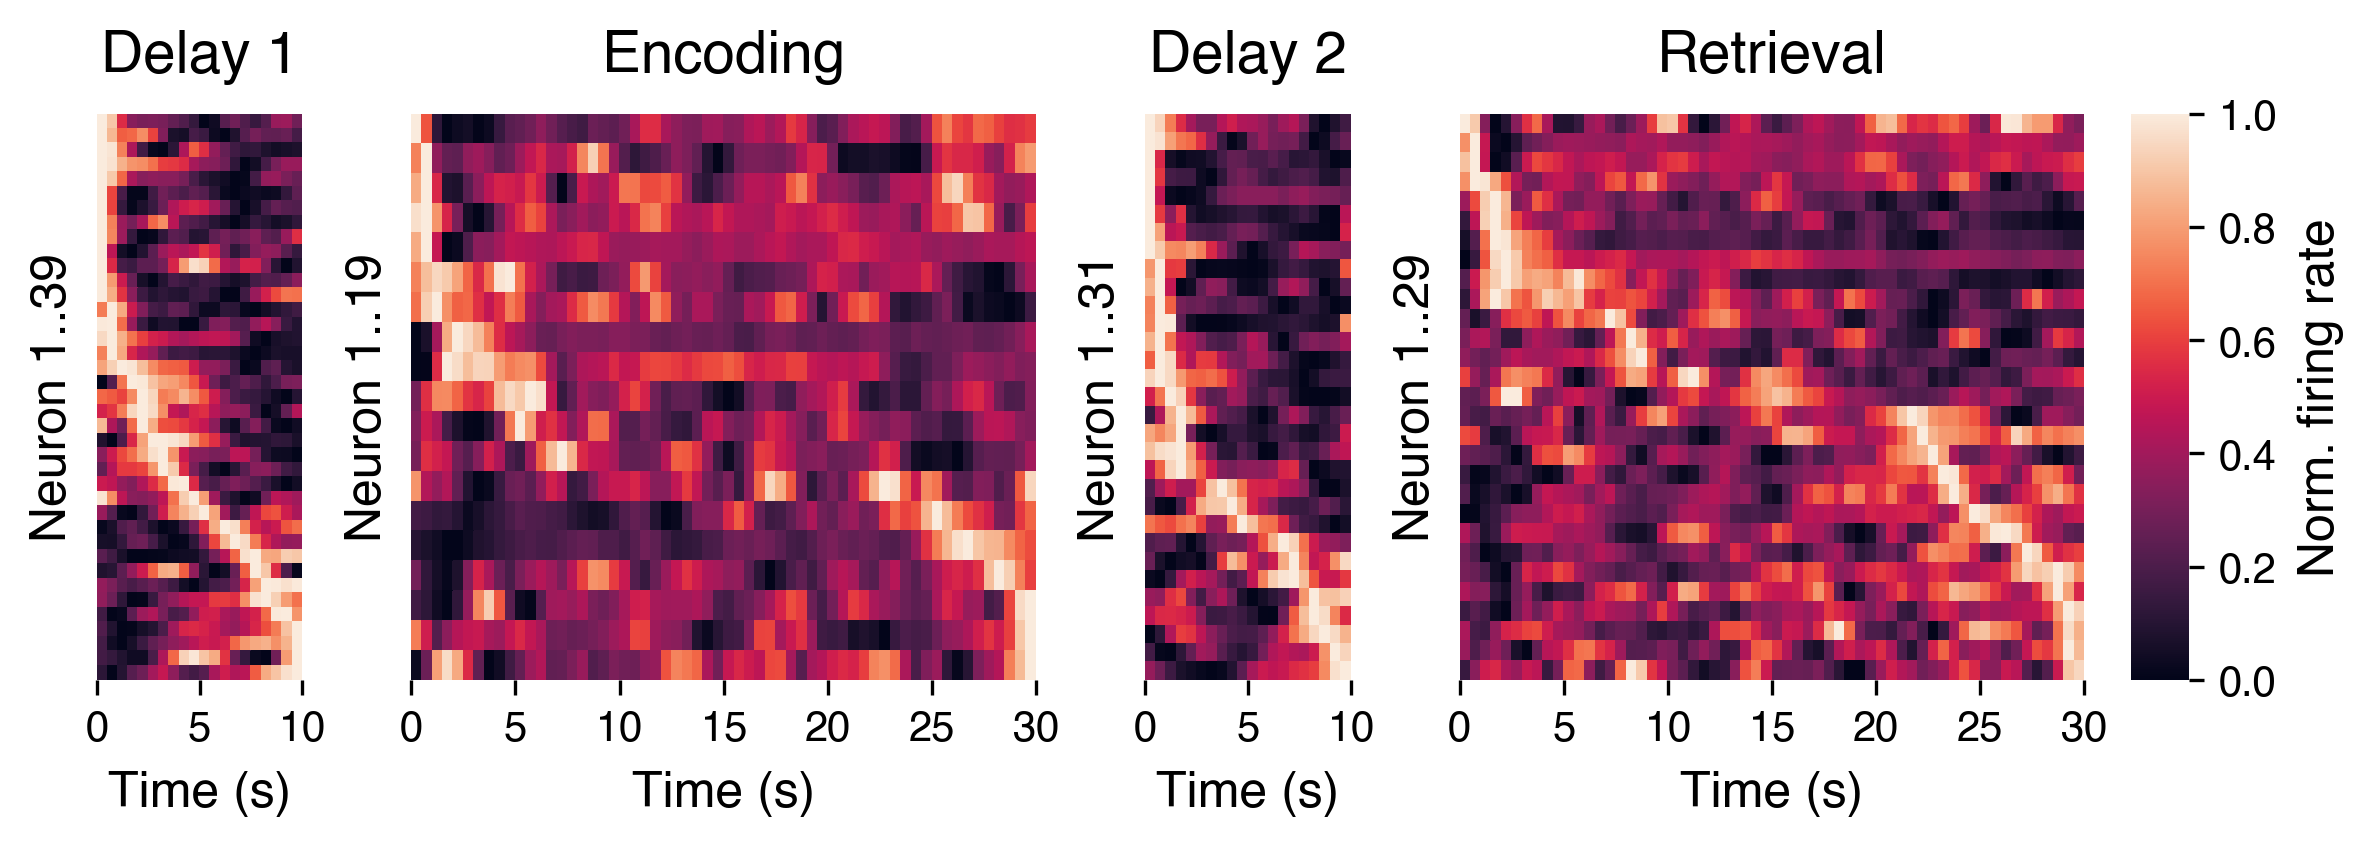

In [538]:
fr_cols = ['obs_fr_z_max_ind', 'obs_fr_z']
fr_cat_nav = 'fr_by_time_subpos'
sig_crit_nav = 'time'

plt.close()
fig = plt.figure(figsize=(9, 2.5), dpi=300)
grid_shp = (15, 100)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=15, colspan=10),
      plt.subplot2grid(grid_shp, (0, 15), rowspan=15, colspan=30),
      plt.subplot2grid(grid_shp, (0, 50), rowspan=15, colspan=10),
      plt.subplot2grid(grid_shp, (0, 65), rowspan=15, colspan=30),
      plt.subplot2grid(grid_shp, (0, 97), rowspan=15, colspan=3)]
ax = np.ravel(ax)

font = od([('tick', 10),
           ('label', 12),
           ('annot', 12),
           ('fig', 14)])

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2',
             'Encoding': 'Encoding',
             'Retrieval': 'Retrieval',
             'Delay1_Delay2': 'Delay',
             'Encoding_Retrieval': 'Navigation'}

# The trial phases we want to examine significant time cells for.
trial_phases = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
n_neurons = []
for i, trial_phase in enumerate(trial_phases):
    # Concat firing rates across trial phases, for each neuron.
    ii = i
    if trial_phase in ['Delay1', 'Delay2']:
        neurons = list(mean_fr.query("(fr_cat=='fr_by_time') & (neuron=={}) & (game_state=='{}')"
                                     .format(list(sig_cells[(trial_phase, 'fr_by_time')]), trial_phase))
                              .sort_values([fr_cols[0], 'roi', 'obs_info_z'], 
                                           ascending=(True, True, False))['neuron'].tolist())
        fr_mat = minmax_scale([mean_fr.query("(fr_cat=='fr_by_time') & (neuron=='{}') & (game_state=='{}')"
                                             .format(neuron, trial_phase)).iloc[0][fr_cols[1]].tolist()
                               for neuron in neurons], axis=1)
    elif trial_phase in ['Encoding', 'Retrieval']:
        neurons = list(mean_fr.query("(fr_cat=='fr_by_time') & (neuron=={}) & (game_state=='{}')"
                                     .format(list(sig_cells[(trial_phase, sig_crit_nav)]), trial_phase))
                              .sort_values([fr_cols[0], 'roi', 'obs_info_z'], 
                                           ascending=(True, True, False))['neuron'].tolist())
        fr_mat = minmax_scale([mean_fr.query("(fr_cat=='{}') & (neuron=='{}') & (game_state=='{}')"
                                             .format(fr_cat_nav, neuron, trial_phase)).iloc[0][fr_cols[1]].tolist()
                               for neuron in neurons], axis=1)
    
    n_neurons.append(fr_mat.shape[0])
    
    # Plot the firing rate heatmap.
    vmin = 0
    vmax = 1
    add_cbar = False
    if ii == len(ax) - 2:
        add_cbar = True
    ax[ii] = sns.heatmap(fr_mat, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket', square=False, 
                         cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[ii].tick_params(axis='y', which='both', length=0, pad=8)
    ax[ii].set_xticks(np.arange(0, fr_mat.shape[1]+1, 10))
    ax[ii].set_xticklabels(np.arange(0, (fr_mat.shape[1]+1)/2, 5, dtype=np.int), 
                           fontsize=font['tick'], rotation=0)
    ax[ii].set_xlabel('Time (s)', fontsize=font['label'], labelpad=5)
    ax[ii].set_yticks([])
    ax[ii].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=5)
    ax[ii].set_title(ax_titles[trial_phase], pad=10, fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'])
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=5)

if False:
    fstr = '-'.join(['{}{}'.format(n_neurons[ii], trial_phases[ii]) for ii in range(len(trial_phases))])
    fig.savefig(os.path.join(proj_dir, 'figs', 'all_time_cell_FRs_over_time-pos_adj-{}.pdf'.format(fstr)),
                format='pdf', dpi=600, bbox_inches='tight')

In [ ]:
def save_time_indices(self,
                      idx_on=('moved_pos_or_hd', 'maze_idx_hd'),
                      pos_states=['Encoding', 'Retrieval'],
                      tbin_states=['Delay1', 'Encoding', 'Delay2', 'Retrieval'],
                      trialwise=False,
                      overwrite=False,
                      save_output=True,
                      verbose=True):
    """Save vectorized indices for each time bin and position."""
    # Load the output file if it exists.
    output_f = op.join(self.proj_dir, 'analysis', 'events', 'time_and_pos', 
                       '{}_event_objs.pkl'.format(self.subj_sess))
    if op.exists(output_f) and not overwrite:
        return dio.open_pickle(output_f)

    # Determine when the player was at each position.
    if not hasattr(self, 'positions'):
        self.log_position_intervals(idx_on[0])

    # Store indices for each time bin and position.
    self.set_pos_time_idx(idx_on=idx_on[1], 
                          game_states=pos_states,
                          trialwise=trialwise)
    self.set_tbin_time_idx(game_state=tbin_states,
                           trialwise=trialwise)

    # Save outputs.
    if save_output:
        _d = {'event_times': self.event_times,
              'pos_time_idx': self.pos_time_idx,
              'pos_time_dur': self.pos_time_dur,
              'tbin_time_idx': self.tbin_time_idx}
        dio.save_pickle(_d, output_f, verbose)

    return _d
    
def set_pos_time_idx(self,
                     idx_on='maze_idx_hd',                        
                     game_states=['Encoding', 'Retrieval'],
                     trialwise=False):
    """Store indices for each position in the mine.

    Positions are taken from self.position_intervals

    pos_time_idx[gameState] is a dict for which:
        - Keys are unique positions or behavioral states.
        - Values are indices to the flattened firing rate vector
          for gameState (from time windows in self.event_times).

    pos_time_dur[gameState] is a dict for which:
        - Keys are unique positions or behavioral states.
        - Values are ms for which each position was occupied.
    """
    pos_time_idx = od([])
    pos_time_dur = od([])
    for game_state in game_states:
        pos_intervals_ = self.pos_intervals.query("(gameState=='{}')".format(game_state))
        pos_keys = list(pos_intervals_[idx_on].unique())
        pos_vec = np.concatenate(pos_intervals_.apply(lambda x: x[idx_on] * np.ones(x['dur']), 
                                                      axis=1).tolist())
        pos_time_idx[game_state] = {pos_key: np.where(pos_vec==pos_key)[0] 
                                    for pos_key in pos_keys}
        pos_time_dur[game_state] = {k: len(v) 
                                    for k, v in pos_time_idx[game_state].items()}

    self.pos_time_idx = pos_time_idx
    self.pos_time_dur = pos_time_dur
        
def set_tbin_time_idx(self,
                      game_states=['Encoding', 'Retrieval'],
                      trialwise=False):
    """Store indices for each trial phase time bin.

    Number of bins is taken from self.event_times

    tbin_time_idx[gameState] is a dict for which:
        - Keys are unique time bins that evenly divide
          the trial phase from 0, 1, ..., n_bins-1.
        - Values are indices to the flattened firing rate vector
          for gameState (from time windows in self.event_times).
    """
    def _f(x):
        split_inds = np.array_split(np.arange(x['duration']), x['n_time_bins'])
        return np.concatenate([iBin * np.ones(len(split_inds[iBin]), dtype=np.uint8)
                               for iBin in range(x['n_time_bins'])])

    tbin_time_idx = od([])
    for game_state in game_states:
        trials = list(np.unique(self.event_times.query("(gameState=='{}')".format(game_state))['trial']))
        for trial in trials:
            event_times_ = self.event_times.query("(gameState=='{}') & (trial=={})".format(game_state, trial))
            tbin_vec = np.concatenate(event_times_.apply(lambda x: _f(x), axis=1).tolist())
            tbin_keys = list(np.unique(tbin_vec))
            tbin_time_idx[game_state] = {tbin_key: np.where(tbin_vec==tbin_key)[0] 
                                         for tbin_key in tbin_keys}

    self.tbin_time_idx = tbin_time_idx

def log_position_intervals(self, 
                           idx_on='moved_pos_or_hd'):
    """Store a DataFrame of all recorded player position intevals.

    Each row gives the game state, trial, player position, head
    direction, time window, and duration for one player position
    interval, which begins when the player enters a maze tile and 
    ends when they leave it. The first position of a trial phase 
    begins with the trial phase start time, and the last position 
    ends with the trial phase stop time.
    """
    if not hasattr(self, 'positions'):
        self.log_positions()

    cols = ['gameState', 'trial', 'pos', 'maze_idx', 'head_direc', 'maze_idx_hd', 'time', 'dur']
    pos_intervals = []
    grp = self.positions.query("({}==True)".format(idx_on)).groupby(['gameState', 'trial'])
    for idx, df in grp:
        gameState, trial = idx
        qry = "(gameState=='{}') & (trial=={})".format(gameState, trial)
        event_start, event_stop = self.event_times.query(qry)['time'].iloc[0]
        for iRow in range(len(df)):
            if iRow == 0:
                if len(df) == 1:
                    pos_start, pos_stop = event_start, event_stop
                else:
                    pos_start, pos_stop = event_start, df.iloc[iRow+1]['time']
            elif iRow == len(df) - 1:
                pos_start, pos_stop = df.iloc[iRow]['time'], event_stop
            else:
                pos_start, pos_stop = df.iloc[iRow]['time'], df.iloc[iRow+1]['time']
            pos_intervals.append([gameState, 
                                  trial,
                                  df.iloc[iRow]['pos'],
                                  df.iloc[iRow]['maze_idx'], 
                                  df.iloc[iRow]['head_direc'],
                                  df.iloc[iRow]['maze_idx_hd'],
                                  (pos_start, pos_stop), 
                                  pos_stop - pos_start])
    self.pos_intervals = pd.DataFrame(pos_intervals, columns=cols)

def set_trialwise_tbin_time_idx(self,
                                game_states=['Encoding', 'Retrieval']):
    """Store indices for each trial phase time bin.

    Number of bins is taken from self.event_times

    tbin_time_idx[gameState] is a dict for which:
        - Keys are unique time bins that evenly divide
          the trial phase from 0, 1, ..., n_bins-1.
        - Values are indices to the flattened firing rate vector
          for gameState (from time windows in self.event_times).
    """
    def _f(x):
        split_inds = np.array_split(np.arange(x['duration']), x['n_time_bins'])
        return np.concatenate([iBin * np.ones(len(split_inds[iBin]), dtype=np.uint8)
                               for iBin in range(x['n_time_bins'])])

    tbin_time_idx = od([])
    for game_state in game_states:
        for trial in self.event_times['trial'].unique():
            event_times_ = self.event_times.query("(gameState=='{}') & (trial=={})"
                                                  .format(game_state, trial))
            tbin_vec = np.concatenate(event_times_.apply(lambda x: _f(x), axis=1).tolist())
            tbin_keys = list(np.unique(tbin_vec))
            tbin_time_idx[game_state] = {tbin_key: np.where(tbin_vec==tbin_key)[0] 
                                         for tbin_key in tbin_keys}

    self.tbin_time_idx = tbin_time_idx

In [ ]:
def trialwise_mean_frs(spike_times):
    """
    Convolve spikes with a Gaussian to obtain a vector of firing rates
    at every ms, separately for each trial phase window. Compare the 
    flattened firing rate vector to the flattened subject position and
    trial phase time bin vector indices to calculate mean firing rate
    at each position and trial phase time bin.
    """
    fr_by_time = od([])
    fr_by_pos = od([])
    fr_by_time_subpos = od([])
    fr_by_pos_subtime = od([])
    for game_state in game_states:
        for trial in trials:
            gstate_trial = '{}_{}'.format(game_state, trial)
            # Firing rate each ms from start to end of each trial phase,
            # unraveled into a vector.
            fr_vec = np.concatenate(
                event_times.query("(gameState=='{}') & (trial=={})".format(game_state, trial))['time']
                           .apply(lambda x: apply_spike_times_to_fr(x, spike_times))
                           .tolist())

            # Mean firing rate within each time bin, across trials.
            fr_by_time[game_state] = {k: np.mean(fr_vec[tbin_time_idx[game_state][k]])
                                      for k in tbin_time_idx[game_state].keys()}

            # Mean firing rate at each position index, across trials.
            fr_by_pos[game_state] = {k: np.mean(fr_vec[pos_time_idx[game_state][k]])
                                     for k in pos_time_idx[game_state].keys()}

            # Residual firing rate each ms after subtracting the influence
            # of trial phase time.
            fr_vec_subtime = fr_vec.copy()
            for k in tbin_time_idx[game_state].keys():
                fr_vec_subtime[tbin_time_idx[game_state][k]] -= fr_by_time[game_state][k]

            # Residual firing rate each ms after subtracting the influence
            # of subject position.
            fr_vec_subpos = fr_vec.copy()
            for k in pos_time_idx[game_state].keys():
                fr_vec_subpos[pos_time_idx[game_state][k]] -= fr_by_pos[game_state][k]

            # Mean firing rate within each time bin, across trials,
            # subtracting the expected firing rate based on subject position alone.
            fr_by_time_subpos[game_state] = {k: np.mean(fr_vec_subpos[tbin_time_idx[game_state][k]])
                                             for k in tbin_time_idx[game_state].keys()}

            # Mean firing rate at each position index, subtracting the 
            # expected firing rate based on time alone.
            fr_by_pos_subtime[game_state] = {k: np.mean(fr_vec_subtime[pos_time_idx[game_state][k]])
                                             for k in pos_time_idx[game_state].keys()}

    mean_frs = {'fr_by_time': fr_by_time,
                'fr_by_pos': fr_by_pos,
                'fr_by_time_subpos': fr_by_time_subpos,
                'fr_by_pos_subtime': fr_by_pos_subtime}

    return mean_frs

In [ ]:
subj_sess = 'U530_ses0'
events = goldmine_behavior.Events(subj_sess)
events.log_position_intervals('moved_pos_or_hd')

In [17]:
# Load output files from place_analysis.calc_fr_by_time_and_pos()
proj_dir = '/home1/dscho/projects/time_cells'

files = np.sort(glob(os.path.join(proj_dir, 'analysis', 'spikes', '*unit*.pkl')))
print('{} files'.format(len(files)))

iUnit = 18
neuron = dio.open_pickle(files[iUnit])

168 files


In [144]:
tp_sessions = {'U518_ses0': ['Encoding', 'Retrieval'],
               'U521_ses0': ['Encoding', 'Retrieval'],
               'U526_ses0': ['Encoding', 'Retrieval'],
               'U527_ses0': ['Encoding'],
               'U530_ses0': ['Encoding', 'Retrieval']}

In [198]:
list(mean_fr.query("(neuron=={}) & (game_state=='{}') & (fr_cat=='fr_by_time') & (obs_fr_max_ind>1)".format(list(sig_cells[('Encoding', 'time')]), game_state))['neuron'].unique())

33

In [199]:
start_time = time()

cols = ['neuron', 'hemroi', 'game_state', 'fr_cat', 'time_penalty', 'fr_corr']
tp_corrs = []
#for neuron in list(np.unique(sig_cells[('Encoding', 'time')] + sig_cells[('Retrieval', 'time')])):
for game_state in ['Encoding', 'Retrieval']:
    test_neurons = list(mean_fr.query("(neuron=={}) & (game_state=='{}') & (fr_cat=='fr_by_time') & (obs_fr_max_ind>1)"
                                      .format(list(sig_cells[('Encoding', 'time')]), game_state))['neuron'].unique())
    for neuron in test_neurons:
        subj_sess, chan, unit = neuron.split('-')
        if subj_sess not in tp_sessions:
            continue
        if game_state not in tp_sessions[subj_sess]:
            continue
        hemroi = mean_fr.query("(neuron=='{}')".format(neuron)).iloc[0]['hemroi']

        # Load events, firing rate vectors, and time bin indices.
        if ('events' not in locals()) and ('events' not in globals()):
            events = goldmine_behavior.Events(subj_sess)
        elif subj_sess != events.event_times.iloc[0]['subj_sess']:
            events = goldmine_behavior.Events(subj_sess)
        fr_vecs = dio.open_pickle(op.join(proj_dir, 'analysis', 'fr_by_time_and_pos',
                                          '{}-CSC{}-unit{}-fr_by_time_and_pos.pkl'.format(subj_sess, chan, unit)))['fr_vecs']
        events_f = op.join(proj_dir, 'analysis', 'events', 'time_and_pos',
                           '{}_event_objs.pkl'.format(subj_sess))
        events_d = dio.open_pickle(events_f)
        tbin_time_idx = events_d['tbin_time_idx']

        # Calculate firing rate by trial x time.
        twise_fr_by_time = od([])
        for fr_cat in ['fr_vec', 'fr_vec_subpos']:
            fr_vec = fr_vecs[game_state][fr_cat]
            twise_fr_by_time[(game_state, fr_cat)] = []
            time_bins = np.sort(list(tbin_time_idx[game_state].keys()))
            for iTime in time_bins:
                trial_divs = np.where(np.diff(tbin_time_idx[game_state][iTime])>1)[0] + 1
                twise_idx = np.split(tbin_time_idx[game_state][iTime], trial_divs)
                twise_fr_by_time[(game_state, fr_cat)].append([np.mean(fr_vec[idx]) for idx in twise_idx])
            twise_fr_by_time[(game_state, fr_cat)] = np.swapaxes(twise_fr_by_time[(game_state, fr_cat)], 0, 1) # trial x time

        # Get a mapping to trials with and w/o a time penalty.
        events.time_penalty = events.events.query("(key=='trialComplete')").set_index('trial')['time_penalty']
        tp_trials = {0: events.time_penalty.loc[lambda x: x==0].index.to_numpy(),
                     1: events.time_penalty.loc[lambda x: x==1].index.to_numpy()}

        # Calculate mean correlations between firing rate vectors across trials.
        for game_state, fr_cat in twise_fr_by_time:
            for had_tp in [0, 1]:
                fr_mat = twise_fr_by_time[(game_state, fr_cat)][tp_trials[had_tp]-1, :] # trial x time
                trial_pairs = [(x, y) 
                               for x in range(fr_mat.shape[0]) 
                               for y in range(fr_mat.shape[0]) 
                               if (x<y)]
                corrs = []
                for x, y in trial_pairs:
                    corrs.append(stats.pearsonr(fr_mat[x, :], fr_mat[y, :])[0])
                mean_corr = np.nanmean(corrs)
                tp_corrs.append([neuron, hemroi, game_state, fr_cat, had_tp, mean_corr])

tp_corrs = pd.DataFrame(tp_corrs, columns=cols)

print('Done in {:.1f}s'.format(time() - start_time))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Done in 104.2s


In [170]:
#units = list(tp_corrs['neuron'].unique())
#tp_corrs.query("(fr_cat=='fr_vec') & (time_penalty==1)").sort_values('neuron')['fr_corr'].tolist()

In [203]:
print(stats.ttest_rel(tp_corrs.query("(fr_cat=='fr_vec') & (time_penalty==1)").sort_values('neuron')['fr_corr'].tolist(),
                      tp_corrs.query("(fr_cat=='fr_vec') & (time_penalty==0)").sort_values('neuron')['fr_corr'].tolist()))

print(stats.ttest_rel(tp_corrs.query("(fr_cat=='fr_vec_subpos') & (time_penalty==1)").sort_values('neuron')['fr_corr'].tolist(),
                      tp_corrs.query("(fr_cat=='fr_vec_subpos') & (time_penalty==0)").sort_values('neuron')['fr_corr'].tolist()))

Ttest_relResult(statistic=0.13573072735961503, pvalue=0.8925483740171012)
Ttest_relResult(statistic=-1.63091320847156, pvalue=0.10883767119884274)


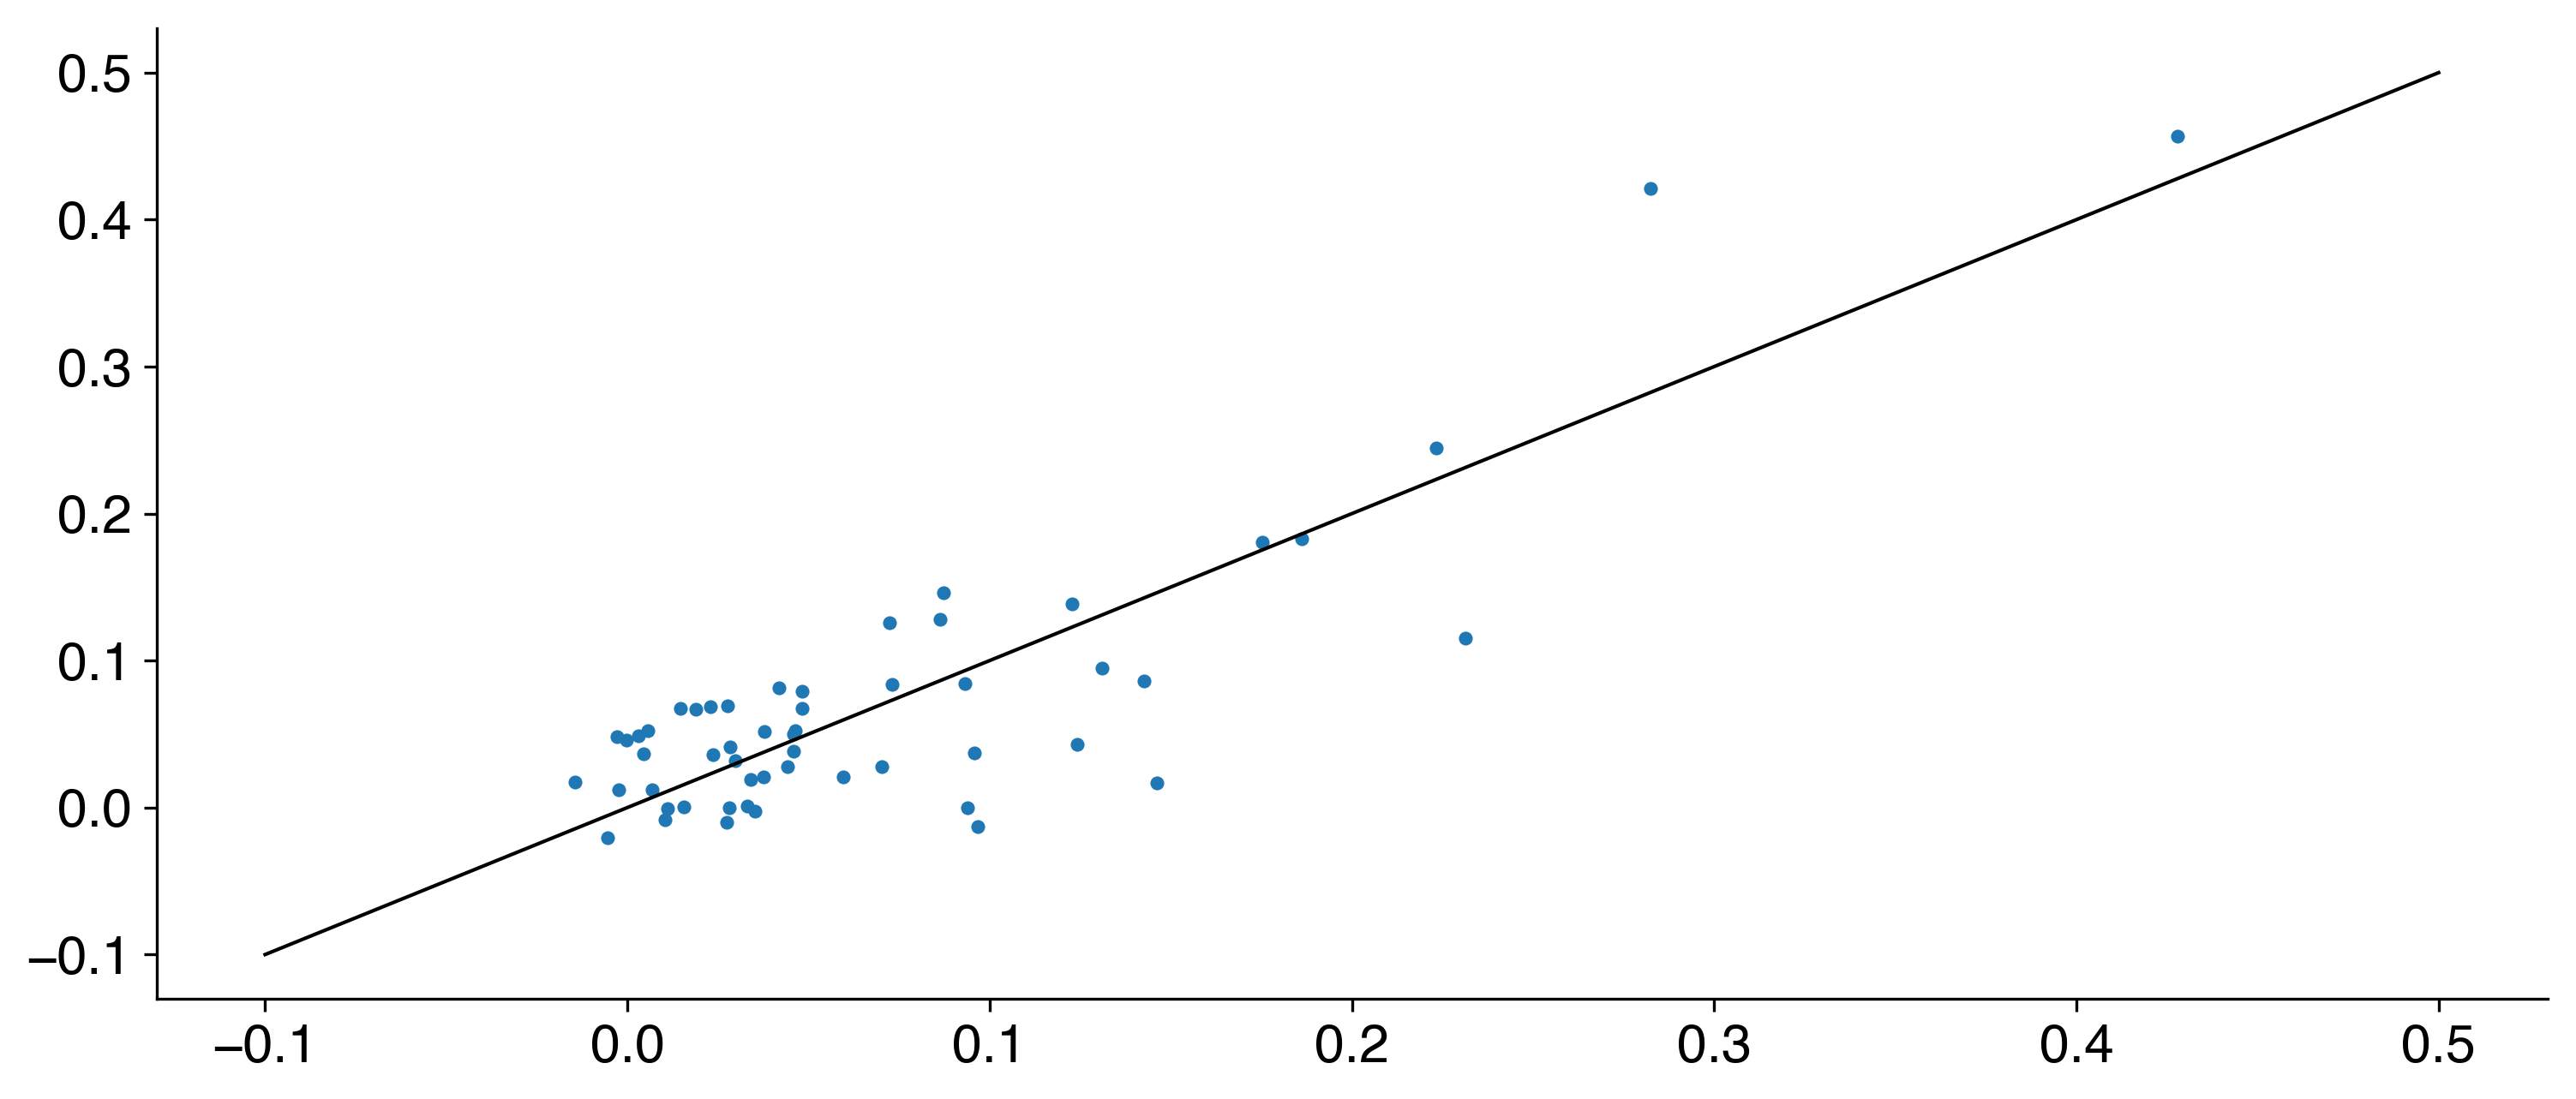

In [202]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

sns.scatterplot(tp_corrs.query("(fr_cat=='fr_vec') & (time_penalty==1)").sort_values('neuron')['fr_corr'].tolist(),
                tp_corrs.query("(fr_cat=='fr_vec') & (time_penalty==0)").sort_values('neuron')['fr_corr'].tolist(),
                s=15, linewidth=0, ax=ax)
ax.plot([-0.1, 0.5], [-0.1, 0.5], color='k')

In [165]:
tp_corrs.groupby(['fr_cat', 'time_penalty']).agg({'fr_corr': lambda x: '{:.3f} +/- {:.3f}'.format(np.mean(x), stats.sem(x))})

fr_corr
fr_cat        time_penalty                 
fr_vec        0             0.053 +/- 0.008
              1             0.056 +/- 0.007
fr_vec_subpos 0             0.019 +/- 0.003
              1             0.017 +/- 0.003

# Delay time cell examples

# Delay time cells by region

In [281]:
roi_nums = {'total': mean_fr.query("(game_state=='Delay1')").groupby('roi').size().to_dict(),
            'delay_sig': mean_fr.query("(neuron=={}) & (game_state=='Delay1')".format(list(sig_cells[('delay', 'time')]))).groupby('roi').size().to_dict()}
for roi in np.sort(list(roi_nums['total'].keys())):
    print(roi, '{}/{} ({:.1%})'.format(roi_nums['delay_sig'].get(roi, 0), 
                                       roi_nums['total'].get(roi, 0), 
                                       roi_nums['delay_sig'].get(roi, 0)/roi_nums['total'].get(roi, 0)))

Amygdala 5/36 (13.9%)
Cortical 29/88 (33.0%)
EC 9/58 (15.5%)
Frontal 8/32 (25.0%)
Hippocampus 12/56 (21.4%)


# Single-unit, single-trial phase example rasters

In [287]:
time_bins = 20

all_spikes = []
for game_state in ['Delay1', 'Delay2']:
    for iUnit in range(len(sig_cells[(game_state, 'fr_by_time')])):
        neuron = sig_cells[(game_state, 'fr_by_time')][iUnit]
        subj_sess, chan, unit = neuron.split('-')
        spikes = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))

        # Load events, firing rate vectors, and time bin indices.
        if ('events' not in locals()) and ('events' not in globals()):
            events = goldmine_behavior.Events(subj_sess)
        elif subj_sess != events.event_times.iloc[0]['subj_sess']:
            events = goldmine_behavior.Events(subj_sess)
        if subj_sess == 'U518_ses1':
            events.event_times = events.event_times.loc[events.event_times['trial']!=31].reset_index(drop=True)
            
        twise_spikes = (events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                          .apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, spikes['spike_times'], sigma=0)).tolist())
        fr_by_tbin = np.array([[(2 * np.nansum(x))
                                for x in np.array_split(x, time_bins)] 
                               for x in twise_spikes]) # trial x time_bin
        mean_frs = np.mean(fr_by_tbin, axis=0) # time_bin; mean over trials
        sem_frs = stats.sem(fr_by_tbin, axis=0) # time_bin; mean over trials
        
        # Append to the df.
        all_spikes.append([neuron, game_state, fr_by_tbin, mean_frs, sem_frs])
        
all_spikes = pd.DataFrame(all_spikes, columns=['neuron', 'game_state', 'fr_by_tbin', 'mean_fr', 'sem_fr'])

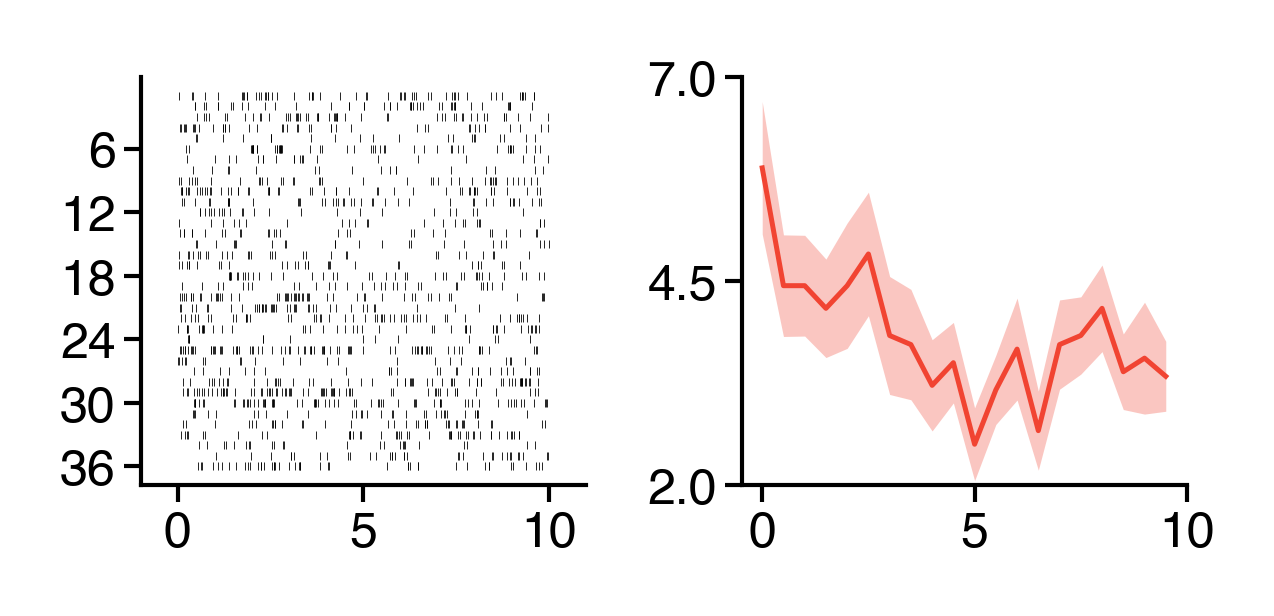

In [470]:
# Save spike raster and mean firing rate for single trial
# phases at a time, for every neuron in the dataset.
savefig = False
overwrite = True
plot_labels = False
plot_title = False
game_states = ['Delay1', 'Delay2']

font = {'tick': 6, 'label': 6, 'annot': 6, 'fig': 6}

for game_state in game_states:
    neurons = np.sort(all_spikes.query("(game_state=='{}')".format(game_state))['neuron'].tolist())
    for neuron in neurons:
        subj_sess, chan, unit = neuron.split('-')
        hemroi = mean_fr.query("(neuron=='{}')".format(neuron)).iloc[0]['hemroi']
        
        # Check if output file exists.
        fstr = '{}-CSC{}-unit{}-{}'.format(subj_sess, chan, unit, hemroi)
        fname = op.join(proj_dir, 'figs', 'single_unit_single_tphase', '{}-{}_activity.pdf'.format(fstr, game_state))
        if op.exists(fname) and not overwrite:
            continue
        
        # Load events, firing rate vectors, and time bin indices.
        if ('events' not in locals()) and ('events' not in globals()):
            events = goldmine_behavior.Events(subj_sess)
        elif subj_sess != events.event_times.iloc[0]['subj_sess']:
            events = goldmine_behavior.Events(subj_sess)
        if subj_sess == 'U518_ses1':
            events.event_times = events.event_times.loc[events.event_times['trial']!=31].reset_index(drop=True)
            
        # -------------------------------------------
        # PLOTTING
        plt.close()
        fig = plt.figure(figsize=(2.25, 2.25*(14/35)), dpi=600)
        n_rows = 14
        n_cols = 35
        ax = [plt.subplot2grid((n_rows, n_cols), (0, 0), rowspan=14, colspan=15),
              plt.subplot2grid((n_rows, n_cols), (0, 20), rowspan=14, colspan=15)]
        ax = np.ravel(ax)
        events.plot_params['font'] = font

        # Spike raster plot.
        i = 0
        ax[i] = trial_raster3(neuron, trial_phases=[game_state], events=events, 
                              plot_vlines=False, plot_labels=plot_labels, plot_trial_phases=False, plot_title=plot_title, 
                              xtick_inc=5, font=font, ax=ax[i])
        
        # Firing rate plot.
        i = 1
        all_spikes_ = all_spikes.query("(neuron=='{}') & (game_state=='{}')".format(neuron, game_state)).iloc[0]
        mean_frs = all_spikes_['mean_fr']
        sem_frs = all_spikes_['sem_fr']
        ymin = np.max((0, np.floor(np.min(mean_frs - sem_frs))))
        ymax = np.ceil(np.max(mean_frs + sem_frs))
        ax[i].fill_between(np.arange(len(mean_frs)), mean_frs + sem_frs, mean_frs - sem_frs,
                           color=colors[ii], linewidth=0, alpha=0.3)
        ax[i].plot(mean_frs, color=colors[ii], linewidth=0.6)
        for axis in ['left', 'bottom']:
            ax[i].spines[axis].set_linewidth(0.5)
        ax[i].tick_params(axis='both', which='both', length=2, width=0.5, pad=1)
        ax[i].set_xticks(np.linspace(0, 20, 3))
        ax[i].set_xticklabels(np.linspace(0, 10, 3, dtype=np.int), fontsize=font['tick'])
#         ax[i].set_xlabel('Time (s)', fontsize=font['label'], labelpad=1)
        ax[i].set_ylim([ymin, ymax])
        ax[i].set_yticks(np.round(np.linspace(ymin, ymax, 3), 1))
        ax[i].set_yticklabels(np.round(np.linspace(ymin, ymax, 3), 1), fontsize=font['tick'])
        if plot_labels:
            ax[i].set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=1)
        
        if savefig:
            fig.savefig(fname, format='pdf', bbox_inches='tight')

fig.show()

# Delay time cells over time

In [ ]:
time_bins = 20

spikes_by_time = od([('Delay1', []), ('Delay2', [])])
for game_state in ['Delay1', 'Delay2']:
    mean_spikes = []
    for iUnit in range(len(sig_cells[(game_state, 'fr_by_time')])):
        subj_sess, chan, unit = sig_cells[(game_state, 'fr_by_time')][iUnit].split('-')
        neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))

        # Load events, firing rate vectors, and time bin indices.
        if ('events' not in locals()) and ('events' not in globals()):
            events = goldmine_behavior.Events(subj_sess)
        elif subj_sess != events.event_times.iloc[0]['subj_sess']:
            events = goldmine_behavior.Events(subj_sess)
        if subj_sess == 'U518_ses1':
            events.event_times = events.event_times.loc[events.event_times['trial']!=31].reset_index(drop=True)
            
        twise_spikes = (events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                          .apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0)).tolist())
        spikes_by_time[game_state].append(np.mean([[(2 * np.nansum(x)) for x in np.array_split(x, time_bins)]
                                                   for x in twise_spikes], axis=0)) # time_bin; mean over trials
    spikes_by_time[game_state] = np.array(spikes_by_time[game_state]) # neuron x time_bin

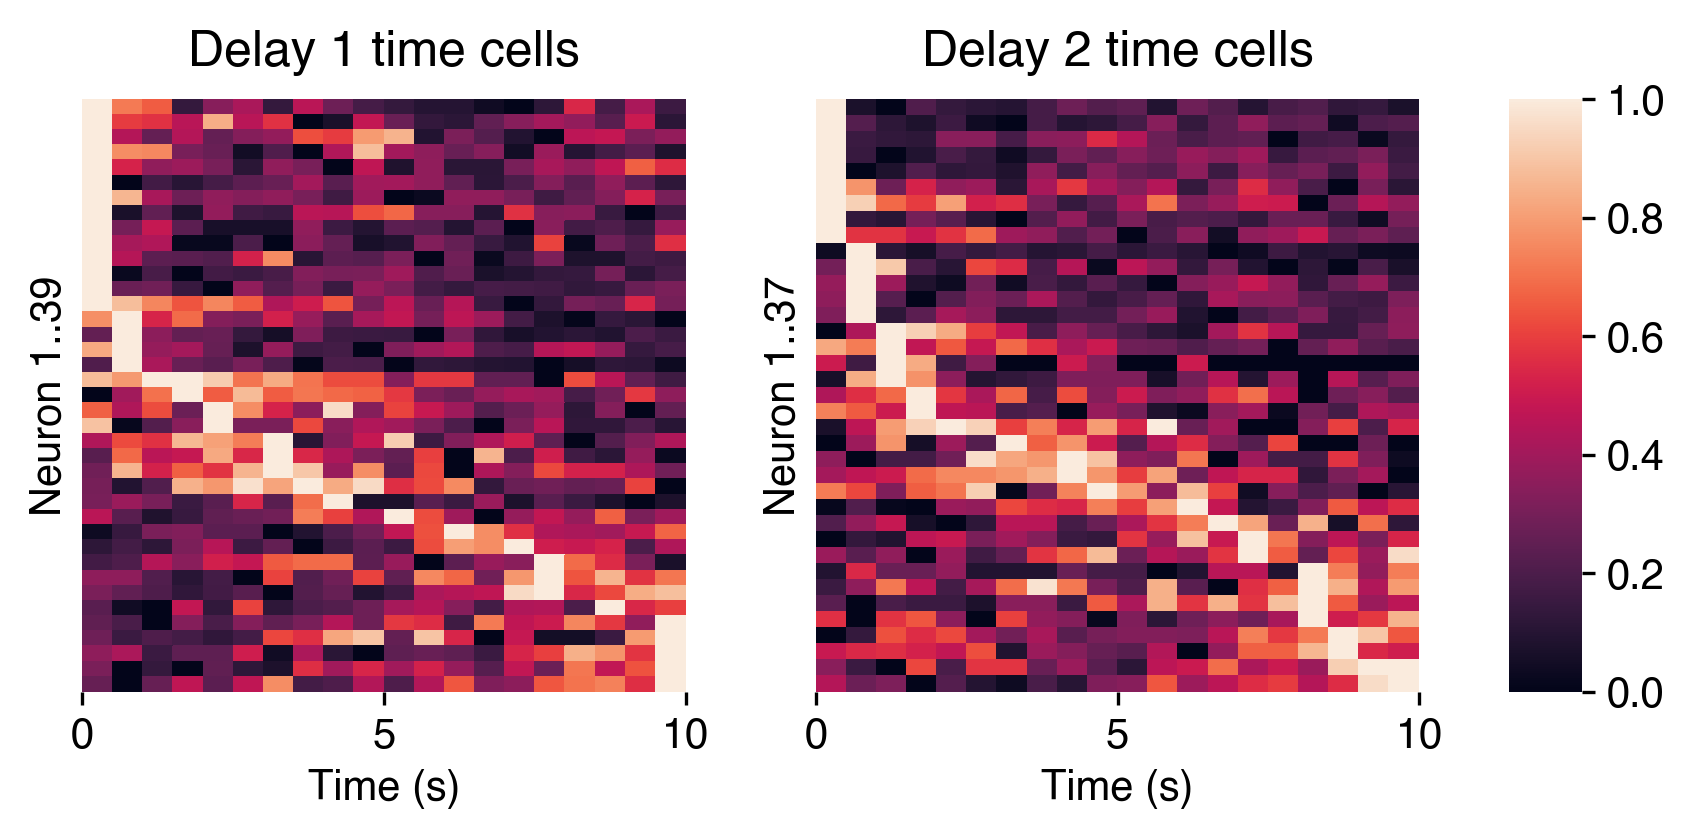

In [282]:
plt.close()
fig = plt.figure(figsize=(colws[3], colws[3]*(15/37)), dpi=300)
grid_shp = (15, 37)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 18), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 35), rowspan=15, colspan=2)]
ax = np.ravel(ax)

font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}

ax_labels = {'Delay1': 'Delay 1',
             'Delay2': 'Delay 2'}
ax_titles = {'Delay1': 'Delay 1 time cells',
             'Delay2': 'Delay 2 time cells'}

# The trial phases we want to examine significant time cells for.
game_states = ['Delay1', 'Delay2']
n_neurons = []
for i, game_state in enumerate(game_states):
    # Concat firing rates across trial phases, for each neuron.
    ii = i
    
    xsort = np.argsort(np.argmax(spikes_by_time[game_state], axis=1))
    fr_mat = minmax_scale(spikes_by_time[game_state], axis=1)[xsort, :]
    n_neurons.append(fr_mat.shape[0])
    
    # Plot the firing rate heatmap.
    vmin = 0
    vmax = 1
    add_cbar = False
    if ii == len(ax) - 2:
        add_cbar = True
    ax[ii] = sns.heatmap(fr_mat, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket',
                         square=False, cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[i].tick_params(axis='x', which='both', length=3, pad=3)
    ax[ii].tick_params(axis='y', which='both', length=0, pad=3)
    ax[ii].set_xticks(np.arange(0, fr_mat.shape[1]+1, 10))
    ax[ii].set_xticklabels(np.arange(0, (fr_mat.shape[1]+1)/2, 5, dtype=np.int), 
                           fontsize=font['tick'], rotation=0)
    ax[ii].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
    ax[ii].set_yticks([])
    ax[ii].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
    ax[ii].set_title(ax_titles[game_state], pad=8, fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=3)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)

if False:
    fig.savefig(os.path.join(proj_dir, 'figs', 'delay_time_cells.pdf'),
                format='pdf', dpi=600, bbox_inches='tight')

# Navigation time cells over time

In [283]:
time_bins = 60

if ('spikes_by_time' not in locals()) and ('spikes_by_time' not in globals()):
    spikes_by_time = od([('Encoding', []), ('Retrieval', [])])
else:
    if 'Encoding' not in spikes_by_time:
        spikes_by_time['Encoding'] = []
    if 'Retrieval' not in spikes_by_time:
        spikes_by_time['Retrieval'] = []
    
for game_state in ['Encoding', 'Retrieval']:
    mean_spikes = []
    for iUnit in range(len(sig_cells[(game_state, 'fr_by_time')])):
        subj_sess, chan, unit = sig_cells[(game_state, 'fr_by_time')][iUnit].split('-')
        neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))

        # Load events, firing rate vectors, and time bin indices.
        if ('events' not in locals()) and ('events' not in globals()):
            events = goldmine_behavior.Events(subj_sess)
        elif subj_sess != events.event_times.iloc[0]['subj_sess']:
            events = goldmine_behavior.Events(subj_sess)
        if subj_sess == 'U518_ses1':
            events.event_times = events.event_times.loc[events.event_times['trial']!=31].reset_index(drop=True)
            
        twise_spikes = (events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                          .apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0)).tolist())
        spikes_by_time[game_state].append(np.mean([[(2 * np.nansum(x)) for x in np.array_split(x, time_bins)]
                                                   for x in twise_spikes], axis=0)) # time_bin; mean over trials
    spikes_by_time[game_state] = np.array(spikes_by_time[game_state]) # neuron x time_bin

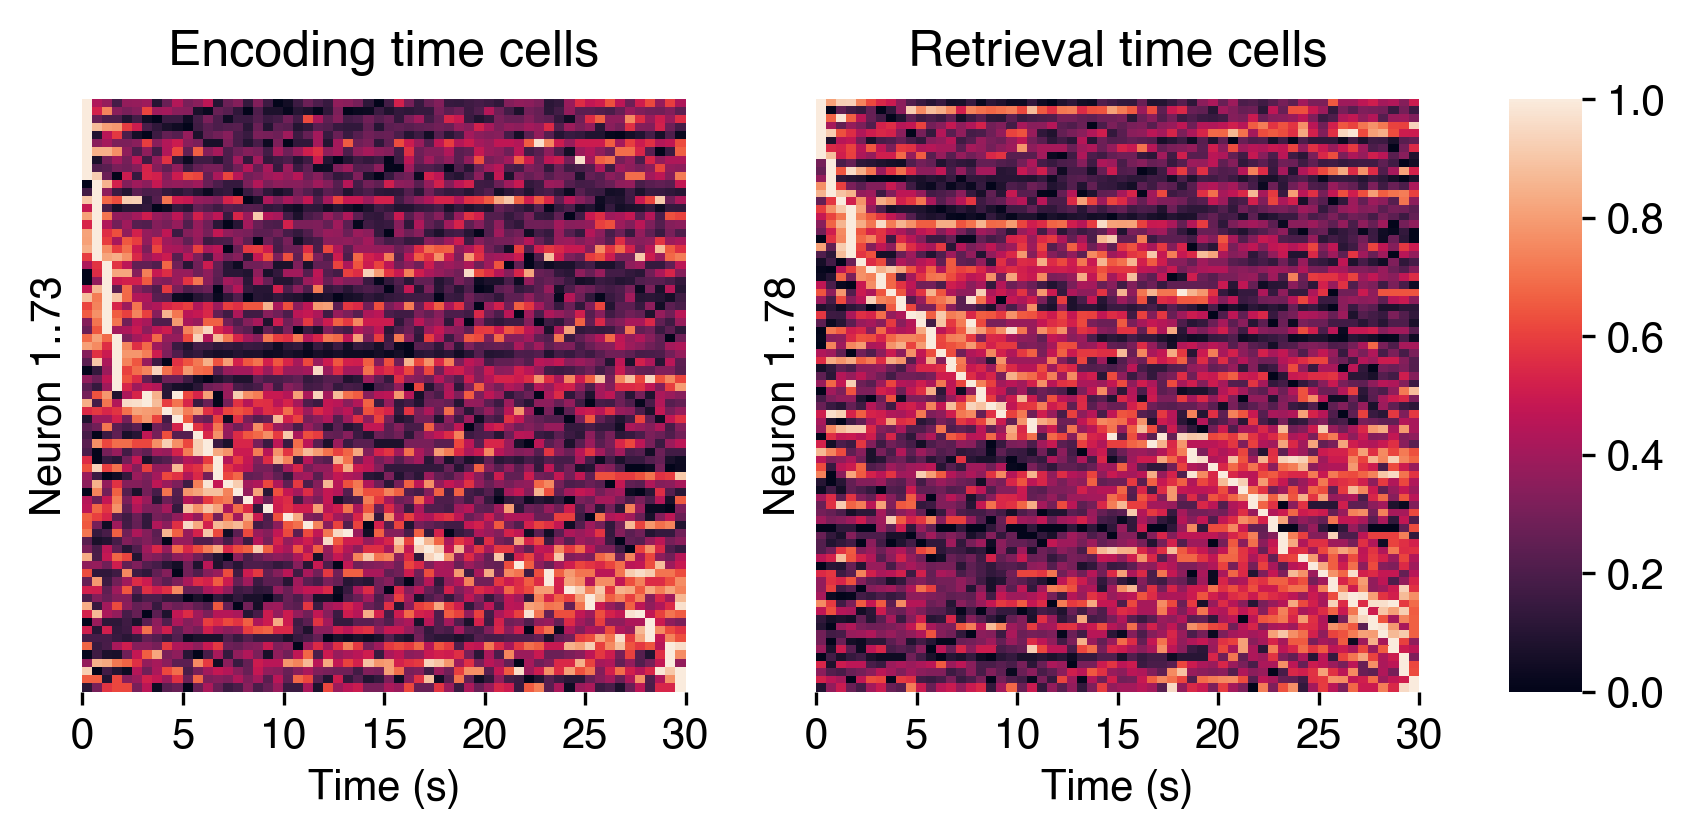

In [285]:
plt.close()
fig = plt.figure(figsize=(colws[3], colws[3]*(15/37)), dpi=300)
grid_shp = (15, 37)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 18), rowspan=15, colspan=15),
      plt.subplot2grid(grid_shp, (0, 35), rowspan=15, colspan=2)]
ax = np.ravel(ax)

font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}

ax_labels = {'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Encoding': 'Encoding time cells',
             'Retrieval': 'Retrieval time cells'}

# The trial phases we want to examine significant time cells for.
game_states = ['Encoding', 'Retrieval']
n_neurons = []
for i, game_state in enumerate(game_states):
    # Concat firing rates across trial phases, for each neuron.
    ii = i
    
    xsort = np.argsort(np.argmax(spikes_by_time[game_state], axis=1))
    fr_mat = minmax_scale(spikes_by_time[game_state], axis=1)[xsort, :]
    n_neurons.append(fr_mat.shape[0])
    
    # Plot the firing rate heatmap.
    vmin = 0
    vmax = 1
    add_cbar = False
    if ii == len(ax) - 2:
        add_cbar = True
    ax[ii] = sns.heatmap(fr_mat, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket',
                         square=False, cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[i].tick_params(axis='x', which='both', length=3, pad=3)
    ax[ii].tick_params(axis='y', which='both', length=0, pad=3)
    ax[ii].set_xticks(np.arange(0, fr_mat.shape[1]+1, 10))
    ax[ii].set_xticklabels(np.arange(0, (fr_mat.shape[1]+1)/2, 5, dtype=np.int), 
                           fontsize=font['tick'], rotation=0)
    ax[ii].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
    ax[ii].set_yticks([])
    ax[ii].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
    ax[ii].set_title(ax_titles[game_state], pad=8, fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=3)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)

if False:
    fig.savefig(os.path.join(proj_dir, 'figs', 'navigation_time_cells.pdf'),
                format='pdf', dpi=600, bbox_inches='tight')

# Delay time cell peak firing times

In [ ]:
time_bins = 5
n_perm = 1000

twise_spikes_by_time = od([('Delay1', od([])),
                           ('Delay2', od([]))])
for game_state in ['Delay1', 'Delay2']:
    for iUnit in range(len(sig_cells[(game_state, 'fr_by_time')])):
        subj_sess, chan, unit = sig_cells[(game_state, 'fr_by_time')][iUnit].split('-')
        neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))

        # Load events, firing rate vectors, and time bin indices.
        if ('events' not in locals()) and ('events' not in globals()):
            events = goldmine_behavior.Events(subj_sess)
        elif subj_sess != events.event_times.iloc[0]['subj_sess']:
            events = goldmine_behavior.Events(subj_sess)
        if subj_sess == 'U518_ses1':
            events.event_times = events.event_times.loc[events.event_times['trial']!=31].reset_index(drop=True)

        twise_spikes = (events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                          .apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0)).tolist()) 
        twise_spikes_by_time[game_state]['{}-{}-{}'.format(subj_sess, chan, unit)] = np.array([[np.nansum(x) for x in np.array_split(x, time_bins)]
                                                                                               for x in twise_spikes]) # trial x time_bin

In [ ]:
peak_fr_counts = od([('Delay1', np.zeros(time_bins)),
                     ('Delay2', np.zeros(time_bins))])
peak_fr_counts_null = od([('Delay1', np.zeros((n_perm, time_bins))),
                          ('Delay2', np.zeros((n_perm, time_bins)))])

for game_state in ['Delay1', 'Delay2']:
    for neuron in twise_spikes_by_time[game_state]:
        mat = twise_spikes_by_time[game_state][neuron]
        ind = np.argmax(np.mean(mat, axis=0))
        peak_fr_counts[game_state][ind] += 1

peak_fr_counts = pd.DataFrame(peak_fr_counts).T.stack().reset_index().rename(columns={'level_0': 'game_state', 'level_1': 'time', 0: 'count'})

# peak_fr_counts = pd.DataFrame(peak_fr_counts, columns=['game_state', 'neuron', 'peak_ind'])
#         for iPerm in range(n_perm):
#             mat_shifted = np.array([np.roll(mat[iTrial, :], np.random.randint(0, mat.shape[1]))
#                                     for iTrial in range(mat.shape[0])])
#             ind = np.argmax(np.mean(mat_shifted, axis=0))
#             peak_fr_counts_null[game_state][iPerm, ind] += 1

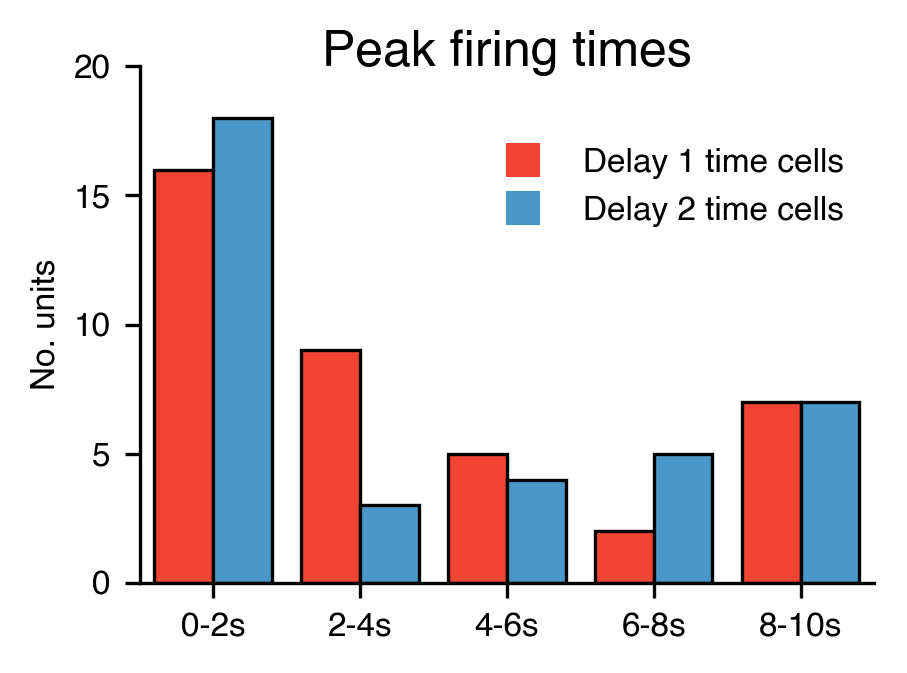

In [249]:
fig, ax = plt.subplots(1, 1, figsize=(colws[2], (3/4) * colws[2]), dpi=300)
ax = np.ravel(ax)

font = {'tick': 8, 'label': 8, 'annot': 8, 'fig': 12}

i = 0
ax[i] = sns.barplot(x='time', y='count', hue='game_state', data=peak_fr_counts, 
                    linewidth=0.8, edgecolor='k', palette=[colors[1], colors[0]], saturation=1, 
                    ax=ax[i])
ax[i].tick_params(axis='x=both', which='both', length=2.5, pad=2)
ax[i].set_xticklabels(['0-2s', '2-4s', '4-6s', '6-8s', '8-10s'], fontsize=font['tick'])
ax[i].set_ylim([0, 20])
ax[i].set_yticks([0, 5, 10, 15, 20])
ax[i].set_yticklabels([0, 5, 10, 15, 20], fontsize=font['tick'])
# ax[i].set_xlabel('Time bin (s)', fontsize=font['label'], labelpad=3)
ax[i].set_xlabel('')
ax[i].set_ylabel('No. units', fontsize=font['label'], labelpad=3)
ax[i].set_title('Peak firing times', fontsize=font['fig'], pad=0)
ax[i].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Delay 1 time cells', mfc=colors[1], ms=font['annot'], mew=0),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Delay 2 time cells', mfc=colors[0], ms=font['annot'], mew=0)]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], loc=1, bbox_to_anchor=(1, 0.9))

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

if False:
    fig.savefig(op.join(proj_dir, 'figs', 'delay_time_cells_peak_firing_times.pdf'), 
                format='pdf', bbox_inches='tight')

In [106]:
for game_state in ['Delay1', 'Delay2']:
    diff = peak_fr_counts[game_state][0] - np.mean(peak_fr_counts[game_state][1:])
    diff_null = peak_fr_counts_null[game_state][:, 0] - np.mean(peak_fr_counts_null[game_state][:, 1:], axis=1)

    pval_ind = np.sum(diff_null >= diff)
    pval = (1 + pval_ind) / (1 + n_perm)
    
    print(game_state, 'First 2s > 2-10: diff={:.1f}, pval_ind={}, pval={:.4f}'.format(diff, pval_ind, pval))

Delay1 First 2s > 2-10: diff=10.2, pval_ind=4, pval=0.0050
Delay2 First 2s > 2-10: diff=13.2, pval_ind=0, pval=0.0010


In [102]:
for game_state in ['Delay1', 'Delay2']:
    diff = peak_fr_counts[game_state][4] - np.mean(peak_fr_counts[game_state][1:4])
    diff_null = peak_fr_counts_null[game_state][:, 4] - np.mean(peak_fr_counts_null[game_state][:, 1:4], axis=1)

    pval_ind = np.sum(diff_null >= diff)
    pval = (1 + pval_ind) / (1 + n_perm)
    
    print(game_state, 'Last 2s > 2-8: diff={:.1f}, pval_ind={}, pval={:.4f}'.format(diff, pval_ind, pval))

Delay1 Last 2s > 2-8: diff=1.7, pval_ind=298, pval=0.2987
Delay2 Last 2s > 2-8: diff=3.0, pval_ind=191, pval=0.1918


# Time cell stats by peak firing time

In [528]:
len(np.unique(list(sig_cells[('Delay1', 'fr_by_time')]) + 
              list(sig_cells[('Encoding', 'fr_by_time')]) + 
              list(sig_cells[('Delay2', 'fr_by_time')]) + 
              list(sig_cells[('Retrieval', 'fr_by_time')])))

146

In [540]:
mean_fr.columns

Index(['neuron', 'subj_sess', 'subj', 'sess', 'chan', 'unit', 'fr', 'hemroi',
       'roi', 'fr_cat', 'game_state', 'obs_fr', 'obs_fr_max_ind', 'obs_fr_max',
       'obs_fr_z', 'obs_fr_z_max_ind', 'obs_fr_z_max', 'obs_fr_z_abs_max_ind',
       'obs_fr_z_abs_max', 'obs_fr_z_abs_max_sign',
       'obs_fr_z_abs_max_above_thresh', 'time_field', 'time_field_size',
       'obs_info', 'obs_info_z', 'pval_ind', 'pval', 'sig', 'sig_fdr',
       'crit_sig'],
      dtype='object')

In [558]:
mean_fr.query("(game_state=='Delay1') & (obs_fr_z_abs_max_sign==1) & (pval<.01)").shape

(24, 30)

In [556]:
0.05/4, 1 - (1 - 0.01)**4

(0.0125, 0.039403990000000055)

In [535]:
len(sig_cells[('delay', 'time')])

63

In [504]:
time_bins = 5
n_perm = 1000

twise_spikes_by_time = od([('Delay1', od([])),
                           ('Delay2', od([]))])
for game_state in ['Delay1', 'Delay2']:
    for iUnit in range(len(sig_cells[('delay', 'time')])):
        subj_sess, chan, unit = sig_cells[('delay', 'time')][iUnit].split('-')
        neuron = dio.open_pickle(op.join(proj_dir, 'analysis', 'spikes', '{}-CSC{}-unit{}-spikes.pkl'.format(subj_sess, chan, unit)))

        # Load events, firing rate vectors, and time bin indices.
        if ('events' not in locals()) and ('events' not in globals()):
            events = goldmine_behavior.Events(subj_sess)
        elif subj_sess != events.event_times.iloc[0]['subj_sess']:
            events = goldmine_behavior.Events(subj_sess)
        if subj_sess == 'U518_ses1':
            events.event_times = events.event_times.loc[events.event_times['trial']!=31].reset_index(drop=True)

        twise_spikes = (events.event_times.query("(gameState=='{}')".format(game_state))['time']
                                          .apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0)).tolist()) 
        twise_spikes_by_time[game_state]['{}-{}-{}'.format(subj_sess, chan, unit)] = np.array([[np.nansum(x) for x in np.array_split(x, time_bins)]
                                                                                               for x in twise_spikes]) # trial x time_bin

In [472]:
df = pd.concat([mean_fr.query("(game_state=='{}') & (neuron=={})".format(game_state, list(sig_cells[(game_state, 'fr_by_time')])))
                for game_state in ['Delay1', 'Delay2']])
df.insert(12, 'obs_fr_max_ind_5bin', df.apply(lambda x: np.argmax(np.sum(twise_spikes_by_time[x['game_state']][x['neuron']], axis=0)), axis=1))
df.shape

(76, 30)

In [495]:
delay_remapping = pd.DataFrame(dio.open_pickle(op.join(proj_dir, 'analysis', 'tmp', 'delay_remapping.pkl')))
df['asym_z'] = df['neuron'].apply(lambda x: delay_remapping.query("(neuron=='{}')".format(x)).iloc[0]['asym_z'])
df['asym_z_sig'] = df['neuron'].apply(lambda x: delay_remapping.query("(neuron=='{}')".format(x)).iloc[0]['sig'])

In [498]:
def mean_sem(x):
    return '{:.2f} ± {:.2f}'.format(np.mean(x), stats.sem(x))
def sum_pct(x):
    return '{}/{} ({:.1%})'.format(np.sum(x), len(x), np.mean(x))
    
df.groupby(['game_state', 'obs_fr_max_ind_5bin']).agg({'neuron': len,
                                                       'obs_info_z': lambda x: mean_sem(x),
                                                       'time_field_size': lambda x: mean_sem(x),
                                                       'asym_z': lambda x: mean_sem(x),
                                                       'asym_z_sig': lambda x: sum_pct(x)})

neuron   obs_info_z time_field_size  \
game_state obs_fr_max_ind_5bin                                        
Delay1     0                        16  6.55 ± 0.88     2.69 ± 0.20   
           1                         9  3.16 ± 0.44     2.89 ± 0.45   
           2                         5  2.69 ± 0.38     1.80 ± 0.58   
           3                         2  3.44 ± 0.41     3.00 ± 0.00   
           4                         7  3.99 ± 0.64     3.29 ± 0.64   
Delay2     0                        18  4.79 ± 0.59     2.89 ± 0.28   
           1                         3  1.73 ± 0.56     3.00 ± 1.15   
           2                         4  0.51 ± 1.12     1.25 ± 0.48   
           3                         5  1.47 ± 0.71     1.80 ± 0.58   
           4                         7  2.81 ± 0.77     2.86 ± 0.55   

                                      asym_z    asym_z_sig  
game_state obs_fr_max_ind_5bin                              
Delay1     0                     1.43 ± 0.50  7/16 (43.8%)  
           1                     1.02 ± 0.44   3/9 (33.3%)  
           2                     2.02 ± 0.73   3/5 (60.0%)  
           3                     2.05 ± 0.19  2/2 (100.0%)  
           4                     2.17 ± 0.87   4/7 (57.1%)  
Delay2     0                     1.35 ± 0.45  8/18 (44.4%)  
           1                    -0.61 ± 0.23    0/3 (0.0%)  
           2                     3.05 ± 1.28   3/4 (75.0%)  
           3                     1.75 ± 0.83   3/5 (60.0%)  
           4                     4.09 ± 1.03   6/7 (85.7%)

In [507]:
delay_remapping['obs_fr_max_ind_5bin'] = delay_remapping.apply(lambda x: np.argmax(np.sum(twise_spikes_by_time[x['game_state']][x['neuron']], axis=0)), axis=1)

In [511]:
delay_remapping.columns

Index(['neuron', 'subj_sess', 'chan', 'unit', 'nsig', 'game_state',
       'fr_max_ind', 'time_field_size', 'info_z', 'asym', 'asym_z', 'pval_ind',
       'pval', 'sig', 'dummy', 'obs_fr_max_ind_5bin'],
      dtype='object')

In [510]:
delay_remapping.groupby('obs_fr_max_ind_5bin').agg({'neuron': len,
                                                    'asym_z': lambda x: mean_sem(x),
                                                    'sig': lambda x: sum_pct(x)})

,neuron,asym_z,sig
obs_fr_max_ind_5bin,,,
0,27,1.51 ± 0.39,12/27 (44.4%)
1,10,0.38 ± 0.31,2/10 (20.0%)
2,7,3.38 ± 0.81,6/7 (85.7%)
3,6,1.76 ± 0.67,4/6 (66.7%)
4,13,2.95 ± 0.73,9/13 (69.2%)


In [518]:
print(stats.ttest_ind(delay_remapping.query("(sig==True)")['info_z'],
                      delay_remapping.query("(sig==False)")['info_z']))

Ttest_indResult(statistic=-0.4172452976063857, pvalue=0.6779638550764542)


(-0.07165845319823153, 0.5767761064891939)


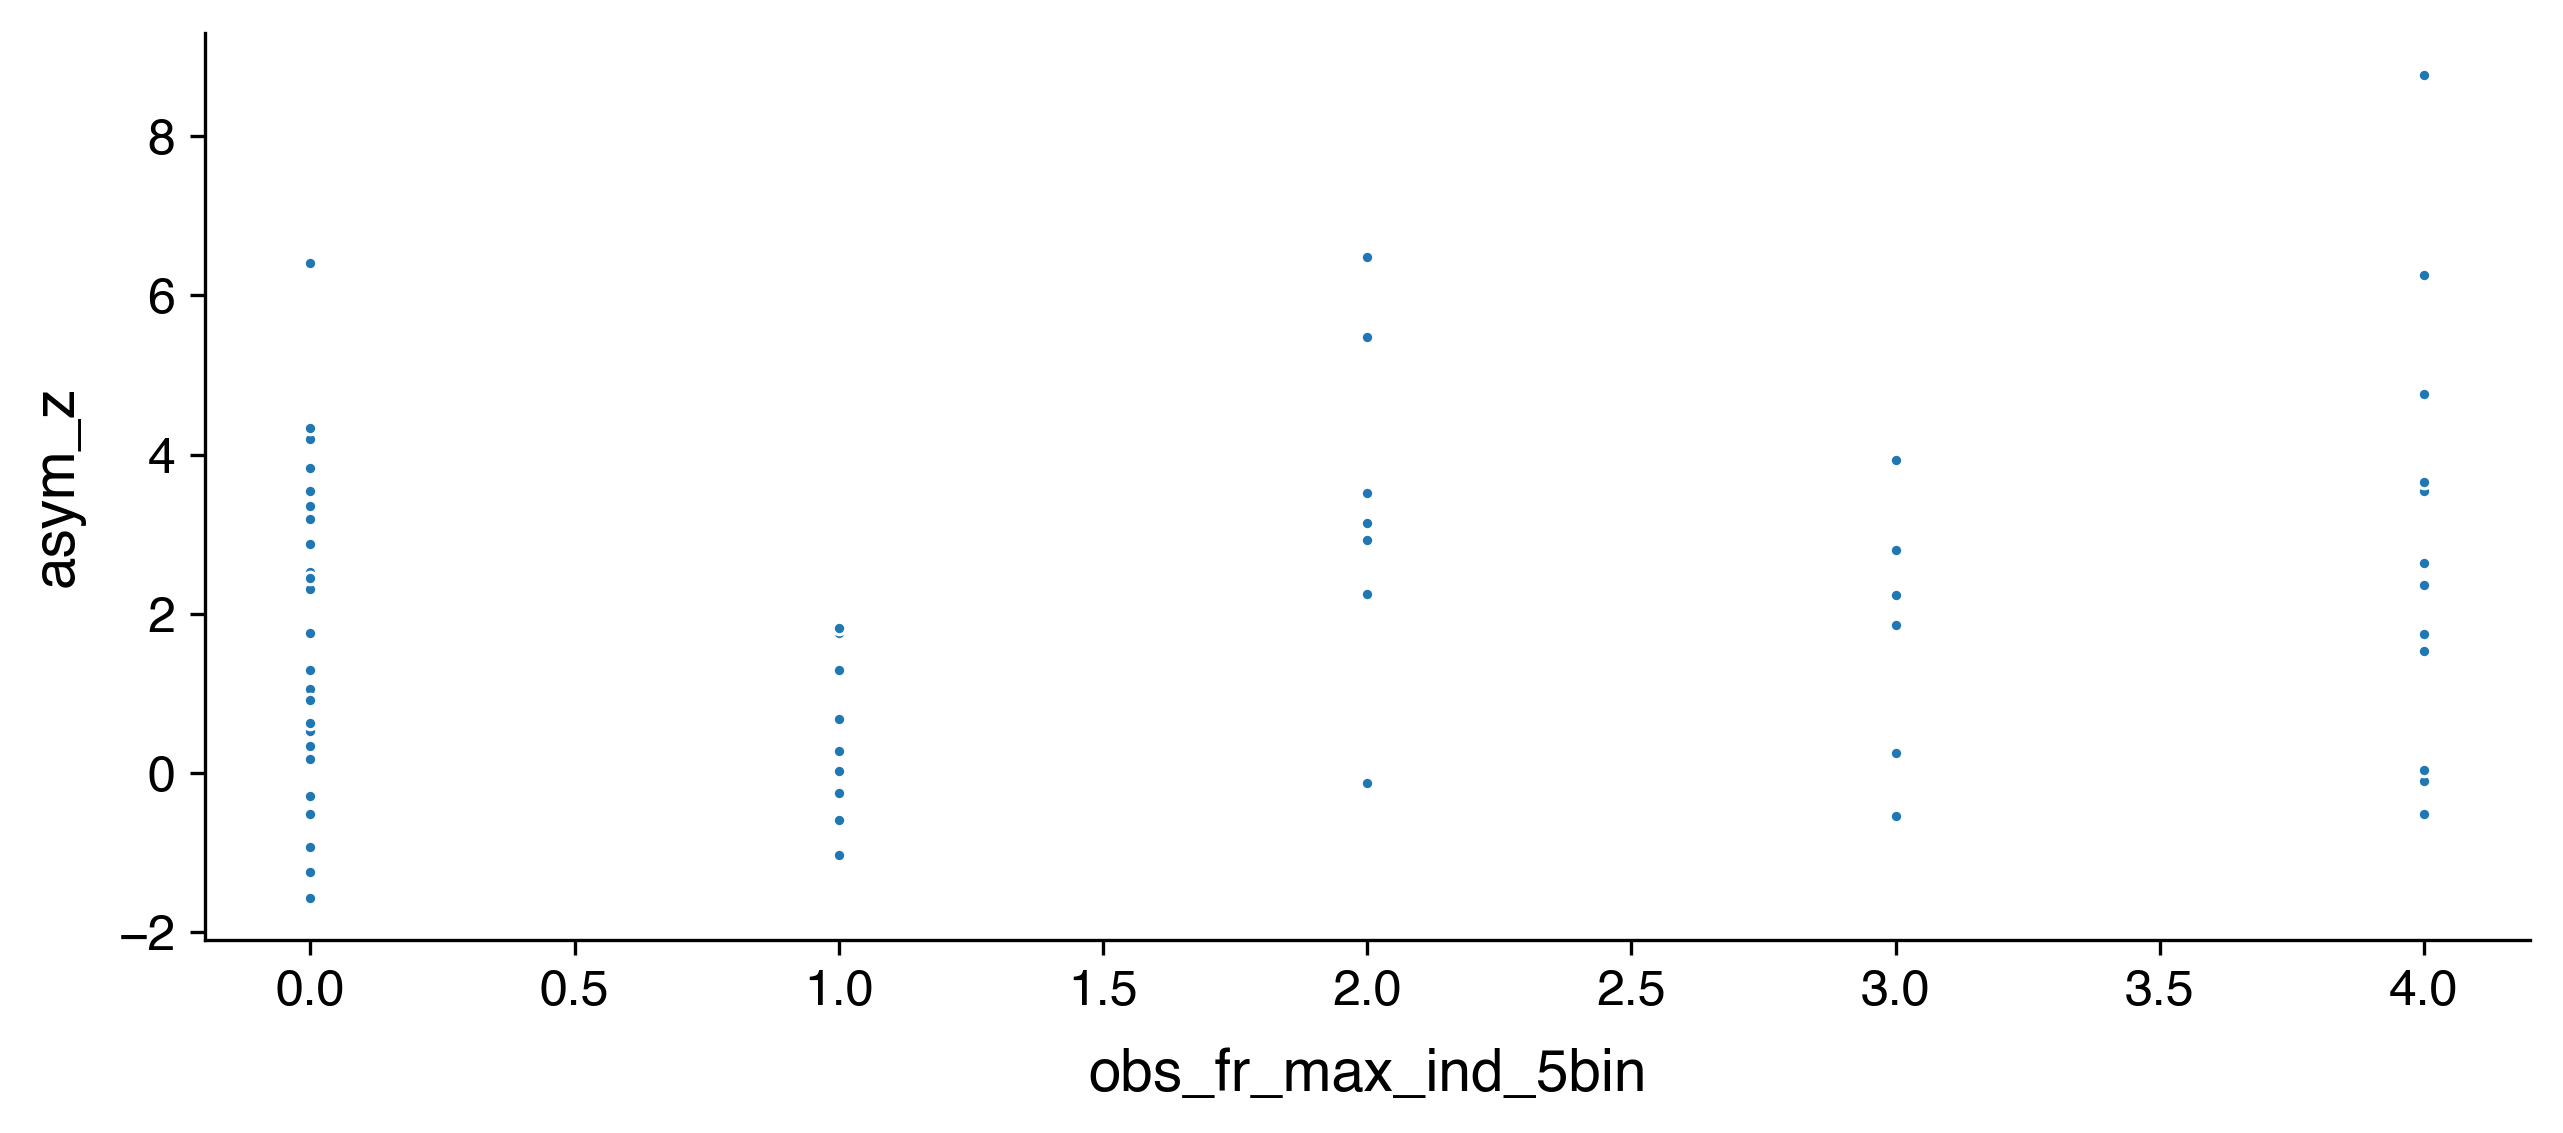

In [516]:
print(stats.pearsonr(delay_remapping['info_z'], delay_remapping['asym_z']))
sns.scatterplot(delay_remapping['obs_fr_max_ind_5bin'], delay_remapping['asym_z'])

In [517]:
print(stats.ttest_ind(delay_remapping.query("(sig==True)")['obs_fr_max_ind_5bin'],
                      delay_remapping.query("(sig==False)")['obs_fr_max_ind_5bin']))

Ttest_indResult(statistic=2.0572365123303413, pvalue=0.04394569595342425)


(0.28276893149375876, 0.024735562281540027)


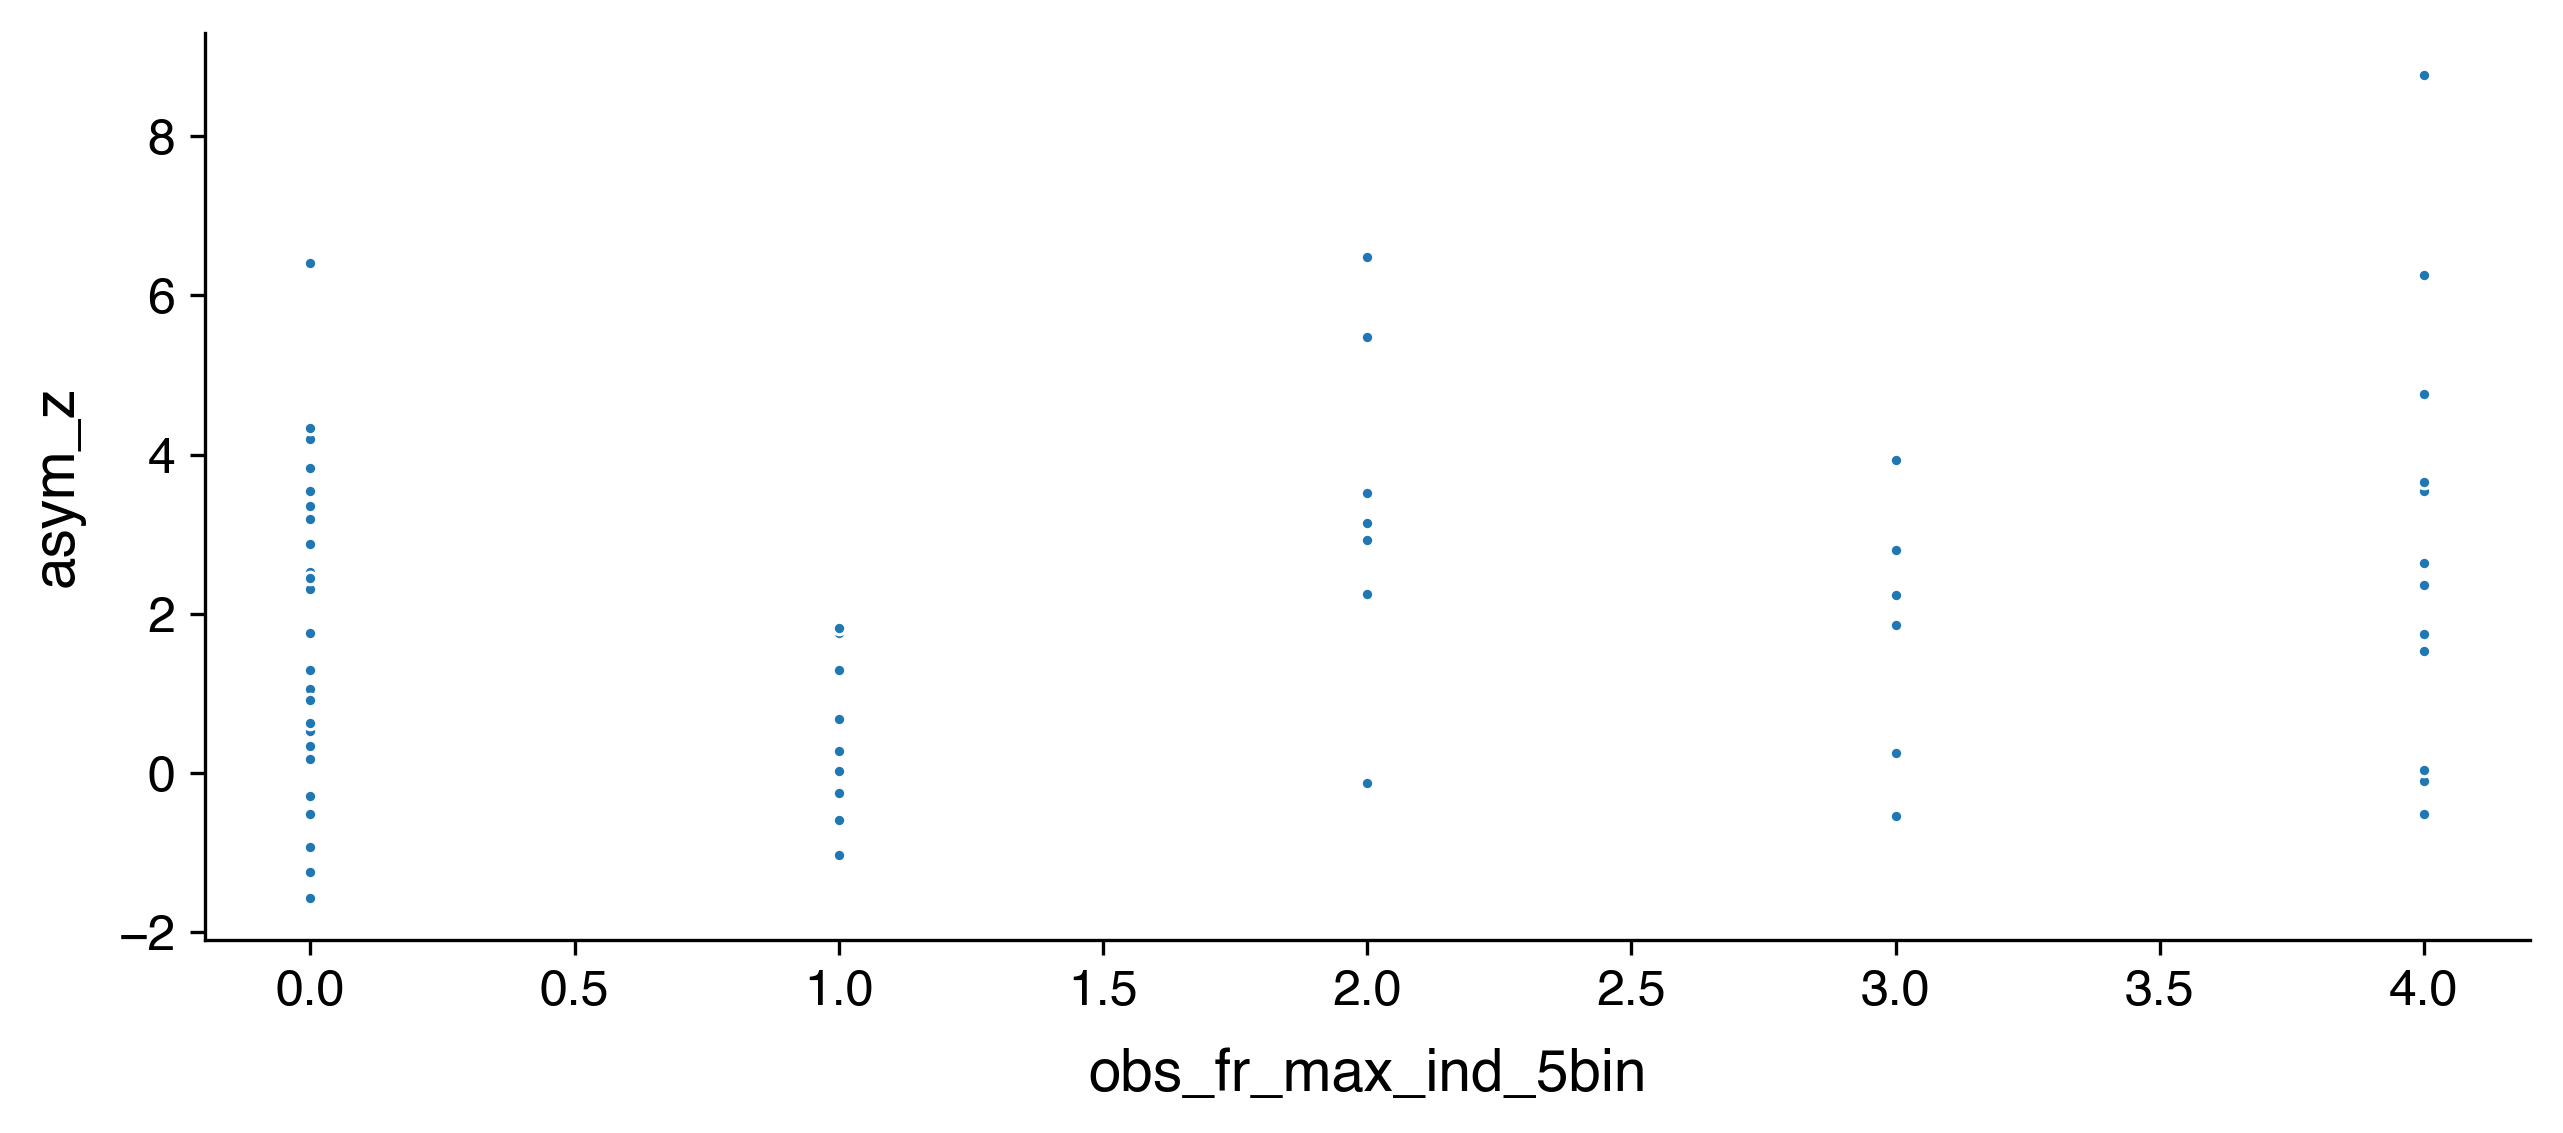

In [515]:
print(stats.pearsonr(delay_remapping['obs_fr_max_ind_5bin'], delay_remapping['asym_z']))
sns.scatterplot(delay_remapping['obs_fr_max_ind_5bin'], delay_remapping['asym_z'])